In [ ]:
#on importe les librairies
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn 
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from scipy.optimize import minimize
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
import scipy

Detection de ruptures dans les signaux 
---------------------------


In [462]:
def changepoint_detection(ts,percent=0.05,plot=True,num_c=4):
    import ruptures as rpt
    from pyinform.blockentropy import block_entropy
    dic = {}
    length = len(ts)
    bar = int(percent*length)
    ts = np.array(ts) [bar:-bar]
    min_val = length
    model = "l1" 
    algo = rpt.Dynp(model="normal").fit(np.array(ts))
    dic = {"best":[0,length]}
    try :
        for i in range(num_c) :
            my_bkps = algo.predict(n_bkps=i)
            if plot :
                rpt.show.display(np.array(ts), my_bkps, figsize=(10, 6))
                plt.show()
            start_borne = 0
            full_entro = 0
            for borne in my_bkps :
                val = block_entropy(ts[start_borne:borne], k=1)   
                full_entro = val + full_entro
                start_borne = borne
            if full_entro == 0 :
                break
            elif full_entro < min_val :
                #print(min_val)
                #print(i,full_entro)
                min_val = full_entro
                print(my_bkps)
                dic["best"] = [0]+my_bkps
            else :
                pass 
    except Exception as e :
        print(e)
        print("Not enough point")
        return {"best":[0,length]}
    return dic

Calcul des kernels (projections des données dans l'espace des fonctions)
---------------------------

In [609]:
# librairies de kernels
def dist(x1,x2):
    return abs(x1-x2)

def Exponential_kernel(data,data_2,l,plot=False):
    dim = len(data)
    cov_mat = np.zeros((dim,len(data_2)))
    for i in range(dim):
        for j in range(len(data_2)):
            cov_mat[i,j]=np.exp(-(dist(data[i],data_2[j])/2*l**2))
    if plot :
        sn.heatmap(cov_mat)
        plt.show()
    return cov_mat

def ExpQuad(data,data_2,l,plot=False):
    dim = len(data)
    cov_mat = np.zeros((dim,len(data_2)))
    for i in range(dim):
        for j in range(len(data_2)):
            dista = pow(abs(data[i]-data_2[j]),2)
            cov_mat[i,j]=np.exp(-1*(dista/2*pow(l,2)))
    if plot :
        sn.heatmap(cov_mat)
        plt.show()
    return cov_mat
    
def Lin(data,data_2,c,plot=False):
    dim = len(data)
    cov_mat = np.zeros((dim,len(data_2)))
    for i in range(dim):
        for j in range(len(data_2)):
            cov_mat[i,j]=(data[i]-c)*(data_2[j]-c)
    if plot :
        sn.heatmap(cov_mat)
        plt.show()
    return cov_mat

def Periodic(data,data_2,l,sigma,p,plot=False):
    dim = len(data)
    cov_mat = np.zeros((dim,len(data_2)))
    for i in range(dim):
        for j in range(len(data_2)):
            dista = pow(np.sin(np.pi*(abs(data[i]-data_2[j]))/p),2)
            cov_mat[i,j]=sigma**2*np.exp(-2*dista/pow(l,2))
    if plot :
        sn.heatmap(cov_mat)
        plt.show()
    return cov_mat

def Constant(data,data_2,c):
    return c*np.ones((len(data),len(data_2)))

Fonctions utilitaires 
----------------

In [564]:
# fonction utilitaires 
def get_values(mu_s,cov_s,nb_samples=100):
    samples = np.random.multivariate_normal(mu_s,cov_s,100)
    stdp = [np.mean(samples[:,i])+1.96*np.std(samples[:,i]) for i in range(samples.shape[1])]
    stdi = [np.mean(samples[:,i])-1.96*np.std(samples[:,i]) for i in range(samples.shape[1])]
    mean = [np.mean(samples[:,i])for i in range(samples.shape[1])]
    return mean,stdp,stdi

def get_prior(mu,cov,samples=100,plot=False):
    samples = np.random.multivariate_normal(mu,cov,samples)
    if plot :
        for i in range(samples.shape[0]) :
            plt.plot(samples[i,:])
        plt.show()
    return samples
    
def plot_gs(true_data,mean,X_train,X_s,stdp,stdi,color="blue"):
    plt.figure(figsize=(32,16), dpi=100)
    plt.plot(X_s,mean,color="green",label="Predicted values")
    plt.fill_between(X_s.reshape(-1,),stdp,stdi, facecolor=color, alpha=0.2,label="Conf I")
    plt.plot(X_train,true_data,color="red",label="True data")
    plt.legend()
    
    

Les solutions analytiques pour obtenir la distributions à postériori (qui est complètement déterminer par la fonction moyenne et la matrice de covariance

**μ**<sub>\*</sub> = **K**<sub>\*</sub><sup>*T*</sup>**K**<sup> − 1</sup>**f**

**Σ**<sub>\*</sub> = **K**<sub> \* \*</sub> − **K**<sub>\*</sub><sup>*T*</sup>**K**<sup> − 1</sup>**K**<sub>\*</sub>



In [565]:
# Calcul posterior

def compute_posterior(data,y,X_s,kernel="Exponential_kernel",l=None,c=None,sigma=None,p=None): 
    mean = np.zeros((1,len(data))).reshape(-1,)
    if kernel == "ExpQuad" :
        cov = ExpQuad(data,data,l)
        cov_s = ExpQuad(data,X_s,l)
        cov_ss = ExpQuad(X_s,X_s,l)
    elif kernel == "Exponential_kernel" :
        cov = Exponential_kernel(data,data,l)
        cov_s = Exponential_kernel(data,X_s,l)
        cov_ss = Exponential_kernel(X_s,X_s,l)
    elif kernel == "Lin" :
        cov = Lin(data,data,c)
        cov_s = Lin(data,X_s,c)
        cov_ss = Lin(X_s,X_s,c)
    elif kernel =="Periodic" :
        cov = Periodic(data,data,p,sigma,l)
        cov_s = Periodic(data,X_s,p,sigma,l)
        cov_ss = Periodic(X_s,X_s,p,sigma,l)
    elif kernel == "Constant" :
        cov = Constant(data,data,c)
        cov_s = Constant(data,X_s,c)
        cov_ss = Constant(X_s,X_s,c)
    cov_1 = np.linalg.inv(cov+0.01*np.random.rand()*np.eye((len(cov))))
    mu = np.dot(np.dot(cov_s.T,cov_1),y)
    cov_f = cov_ss - np.dot(np.dot(cov_s.T,cov_1),cov_s)
    return mu,cov_f


In [466]:
#Preparer les données 
def prepare_data(Y_train,split=True,test_percent=0.2):
    if split :
        X_s=np.linspace(0,len(Y_train)-1,len(Y_train))
        test_size = int(test_percent*len(Y_train))
        Y_train = Y_train[:-test_size]
        Y_test = Y_train[-test_size:]
        X_train=np.linspace(0,len(Y_train)-1,len(Y_train))
        return Y_train,X_train,X_s,Y_test
    else :
        Y_train = pd.read_csv("1.csv")["x"]
        X_s=np.linspace(0,len(Y_train)+1,len(Y_train))
        X_train=np.linspace(0,len(Y_train)-1,len(Y_train))
        return Y_train,X_train,X_s

In [467]:
def Grid_Search_periodic():
    parameters_dic_periodic = {
    "p": [1,2,3,4,5,6,7,8,9,10],
    "sigma" : [1,2,3,4,5,6,7,8,9,10],
    "l": [1,2,3,4,5,6,7,8,9,10]
    }
    for l in parameters_dic_periodic["l"] :
        for sigma in parameters_dic_periodic["sigma"] :
            for p in parameters_dic_periodic["p"] :
                mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=p,sigma=sigma,l=l)
                param = [p,sigma,l]
                mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
                score = mse(mean[-test_size:],Y_test)
                print(score)
                if score < np.min(best_res["score"]) : 
                    best_res["parameters"]=param 
                    best_res["score"]=score
    return best_res

Fonction à maximiser (donc - minimiser)

$\log \mathcal{N}\left(\mathbf{y} \mid \mathbf{0}, \mathbf{K}_{y}\right)=-\frac{1}{2} \mathbf{y}^{T} \mathbf{K}_{y}^{-1} \mathbf{y}-\frac{1}{2} \log \left|\mathbf{K}_{y}\right|-\frac{N}{2} \log (2 \pi)$




In [682]:

def cov_ll(X_train,Y_train,kernel="Exponential_kernel"):

    if kernel == "ExpQuad" :
        cov = ExpQuad(X_train,X_train,tab[0])
    elif kernel == "Exponential_kernel" :
        cov = Exponential_kernel(X_train,X_train,tab[0])
    elif kernel == "Lin" :
        cov = Lin(X_train,X_train,tab[0])
    elif kernel =="Periodic" :
        cov = Periodic(X_train,X_train,tab[0],tab[1],tab[2])
    elif kernel == "Constant" :
        cov = Constant(X_train,X_train,tab[0])
        
    def ll(tab):
        def ls(a, b):
            return lstsq(a, b, rcond=-1)[0]
        if kernel =="Periodic" :
            cov = Periodic(X_train,X_train,tab[0],tab[1],tab[2])
        elif kernel == "Exponential_kernel" :
            cov = Exponential_kernel(X_train,X_train,tab[0])
        elif kernel == "ExpQuad":
            cov = ExpQuad(X_train,X_train,tab[0])
        elif kernel == "Lin" :
            cov = Lin(X_train,X_train,tab[0])
        elif kernel == "Constant" :
            cov = Constant(X_train,X_train,tab[0])
        cov =cov + 0.01*np.random.rand()*np.eye(len(cov))
        try :
            L = scipy.linalg.cholesky(cov,lower=True)
            return np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.dot(ls(L.T, ls(L, Y_train))) + 0.5 * len(X_train) * np.log(2*np.pi)
        except Exception as e :
            return np.random.rand()*1000
    return ll

Fonctions pour le tunning des hyperparamètres
-------------------

In [687]:
def optimize(X_train,Y_train,kernel="Periodic",num_restart=10,bounds=10,method="Nelder-Mead",disp=False):
    extremum = 1000000000
    for i in range(num_restart) :
        x,y,z = np.random.rand()*bounds,np.random.rand()*bounds,np.random.rand()*bounds
        print("Roound n° ",str(i)+"/"+str(num_restart),"started at point : ",x,y,z)
        tab = [x,y,z]
        res = minimize(cov_ll(X_train, Y_train,kernel),tab,
                       bounds=((0.1,bounds),(0.1,bounds),(0.1,bounds)),method=method,options={'disp': disp})
        if res.fun < extremum :
            p,sigma,l = res.x
        print("            score :",res.fun)
        print("            ended at point :",res.x)
    return p,sigma,l


In [699]:
def optimize_one(X_train,Y_train,kernel="ExpQuad",num_restart=10,bounds=10,method="Nelder-Mead",disp=False):
    extremum = 1000000000
    for i in range(num_restart) :
        x = np.random.rand()*bounds
        print("Roound n° ",str(i)+"/"+str(num_restart),"started at point : ",x)
        tab = [x]
        res = minimize(cov_ll(X_train, Y_train,kernel),tab,
                       bounds=((0.1,bounds),),method=method,options={'disp': disp})
        if res.fun < extremum :
            p = res.x
        print("            score :",res.fun)
        print("            ended at point :",res.x)
    return p

# Quelques priors



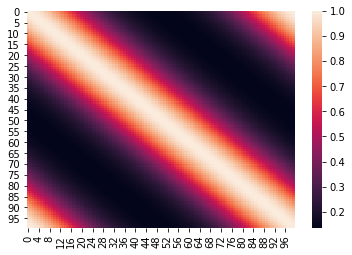

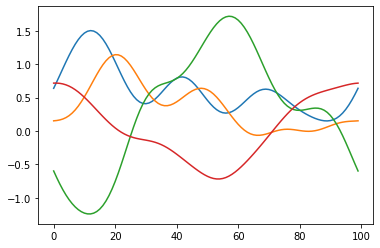

In [584]:
# kernel periodique  
%matplotlib inline

data = np.linspace(0,100,100)
mu = np.zeros((len(data),1)).reshape(-1,)
cov = Periodic(data,data,1,1,1,plot=True)
samples = get_prior(mu,cov,4,plot=True)


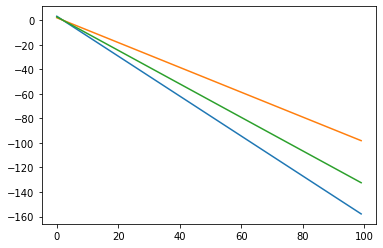

In [596]:
# kernel linéaire 
cov = Lin(data,data,2)
samples = get_prior(mu,cov,4,plot=True)


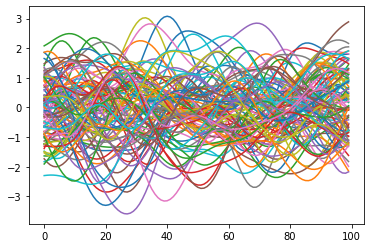

In [616]:
# kernel exponentiel quadratic
cov = ExpQuad(data,data,l=0.1)
samples = get_prior(mu,cov,100,plot=True)


Regression avec des processus gaussiens sur un signal synthétique et visualisation de l'effet des hyperparamètres
------------------------------------------------------------------------------------------------------------------------

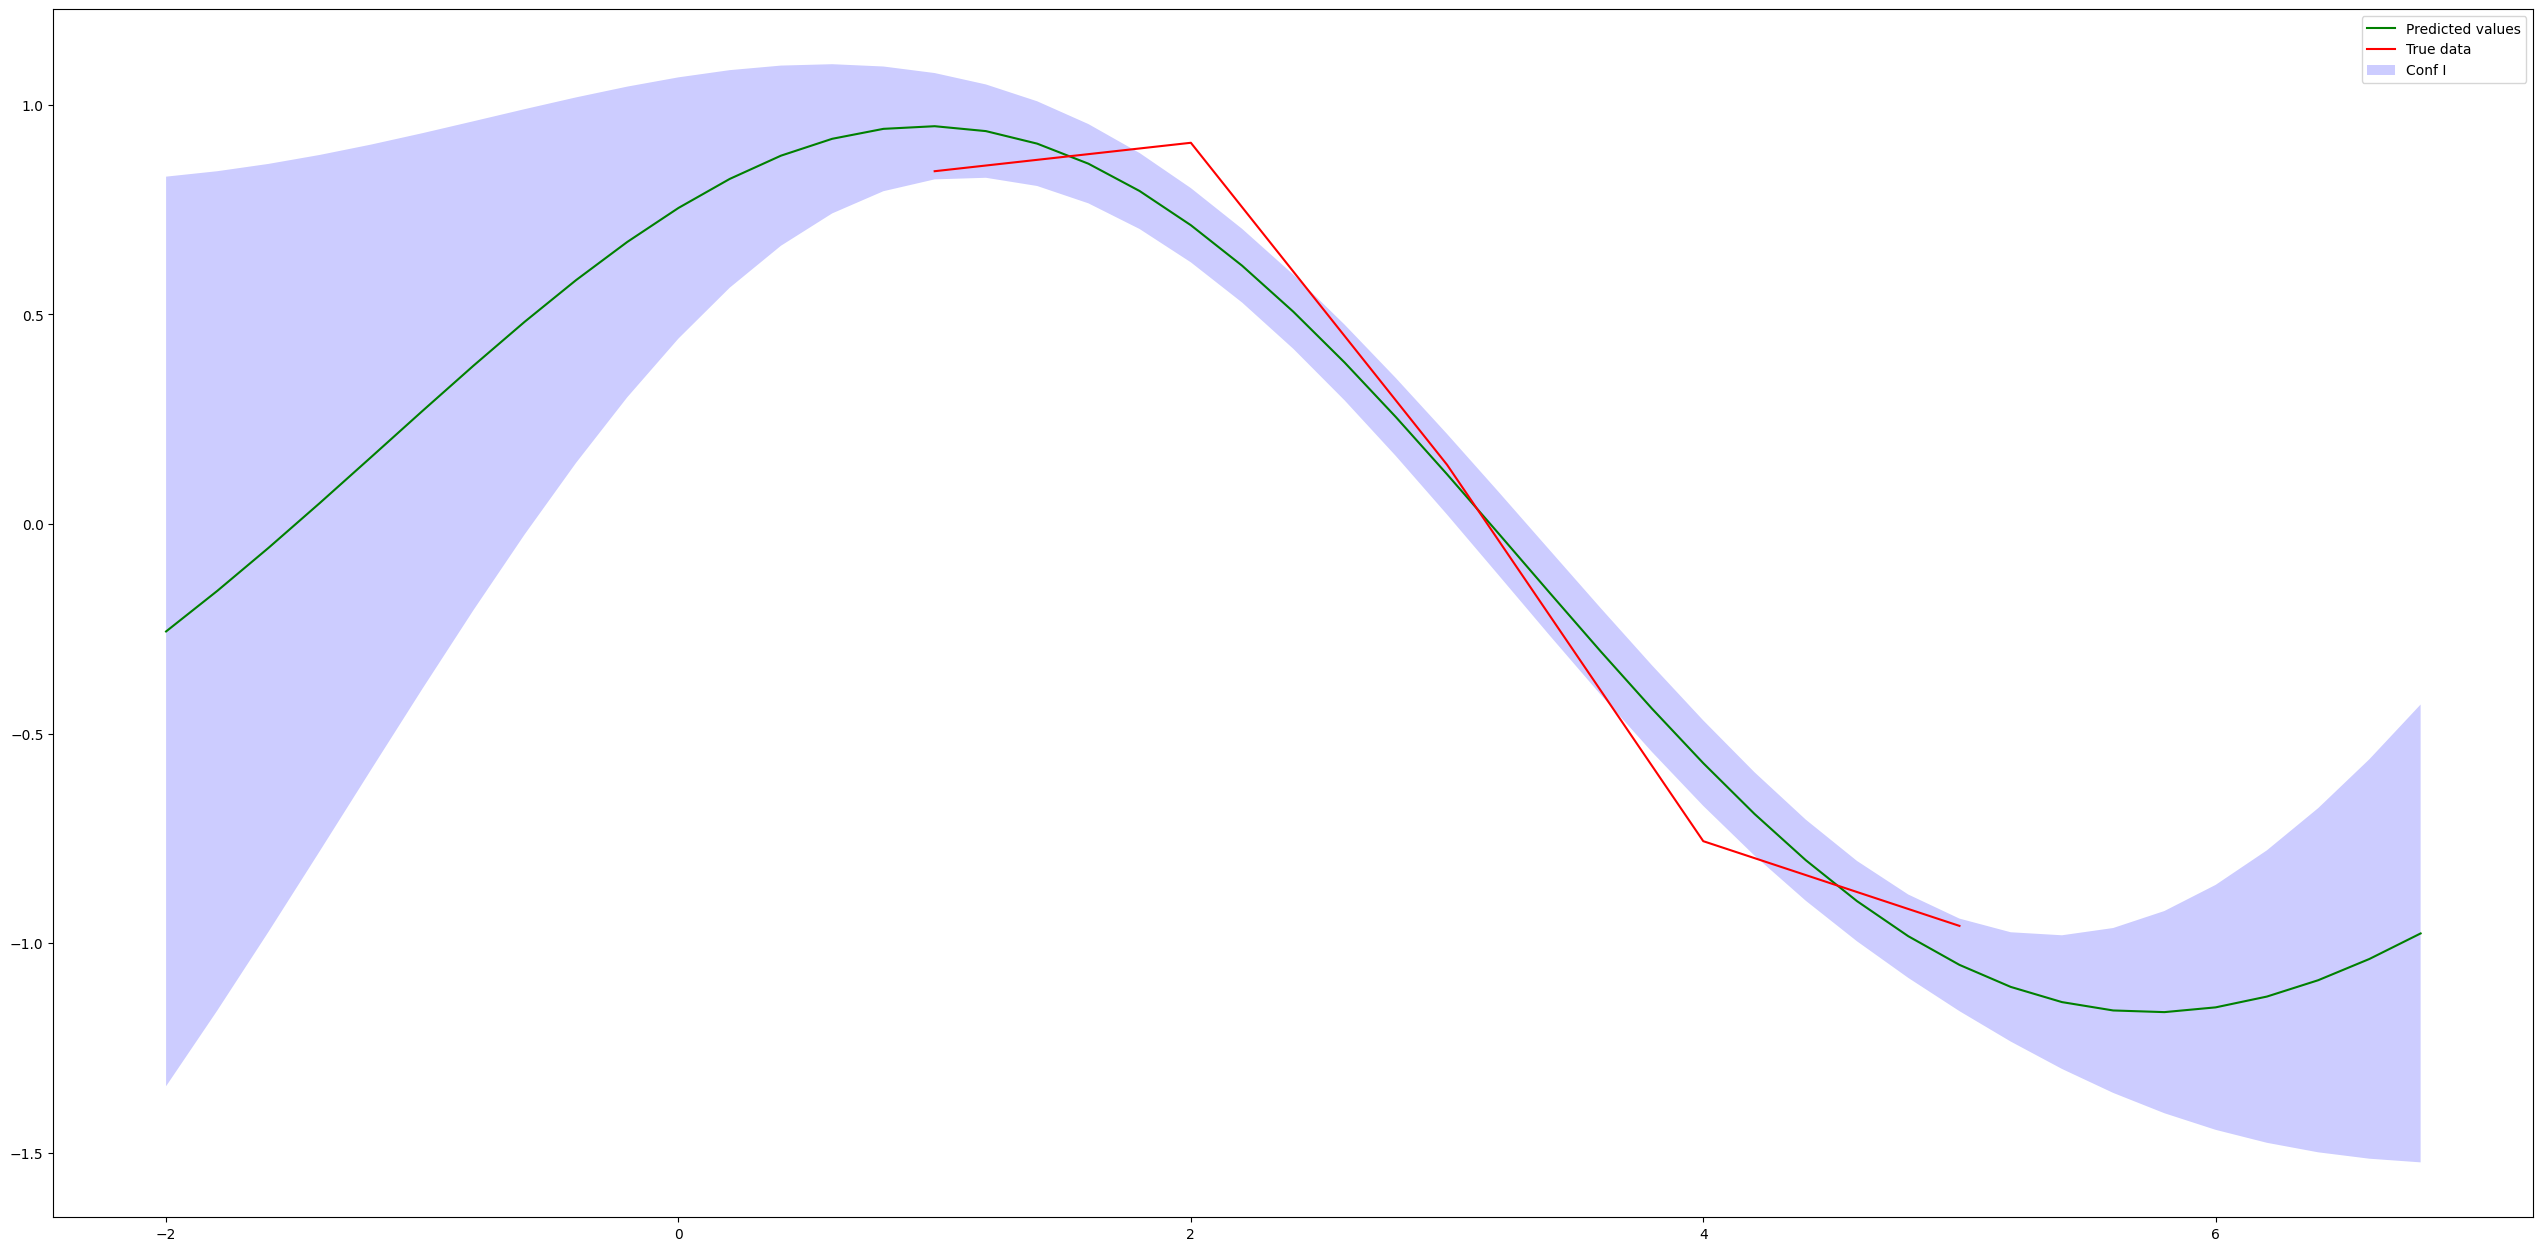

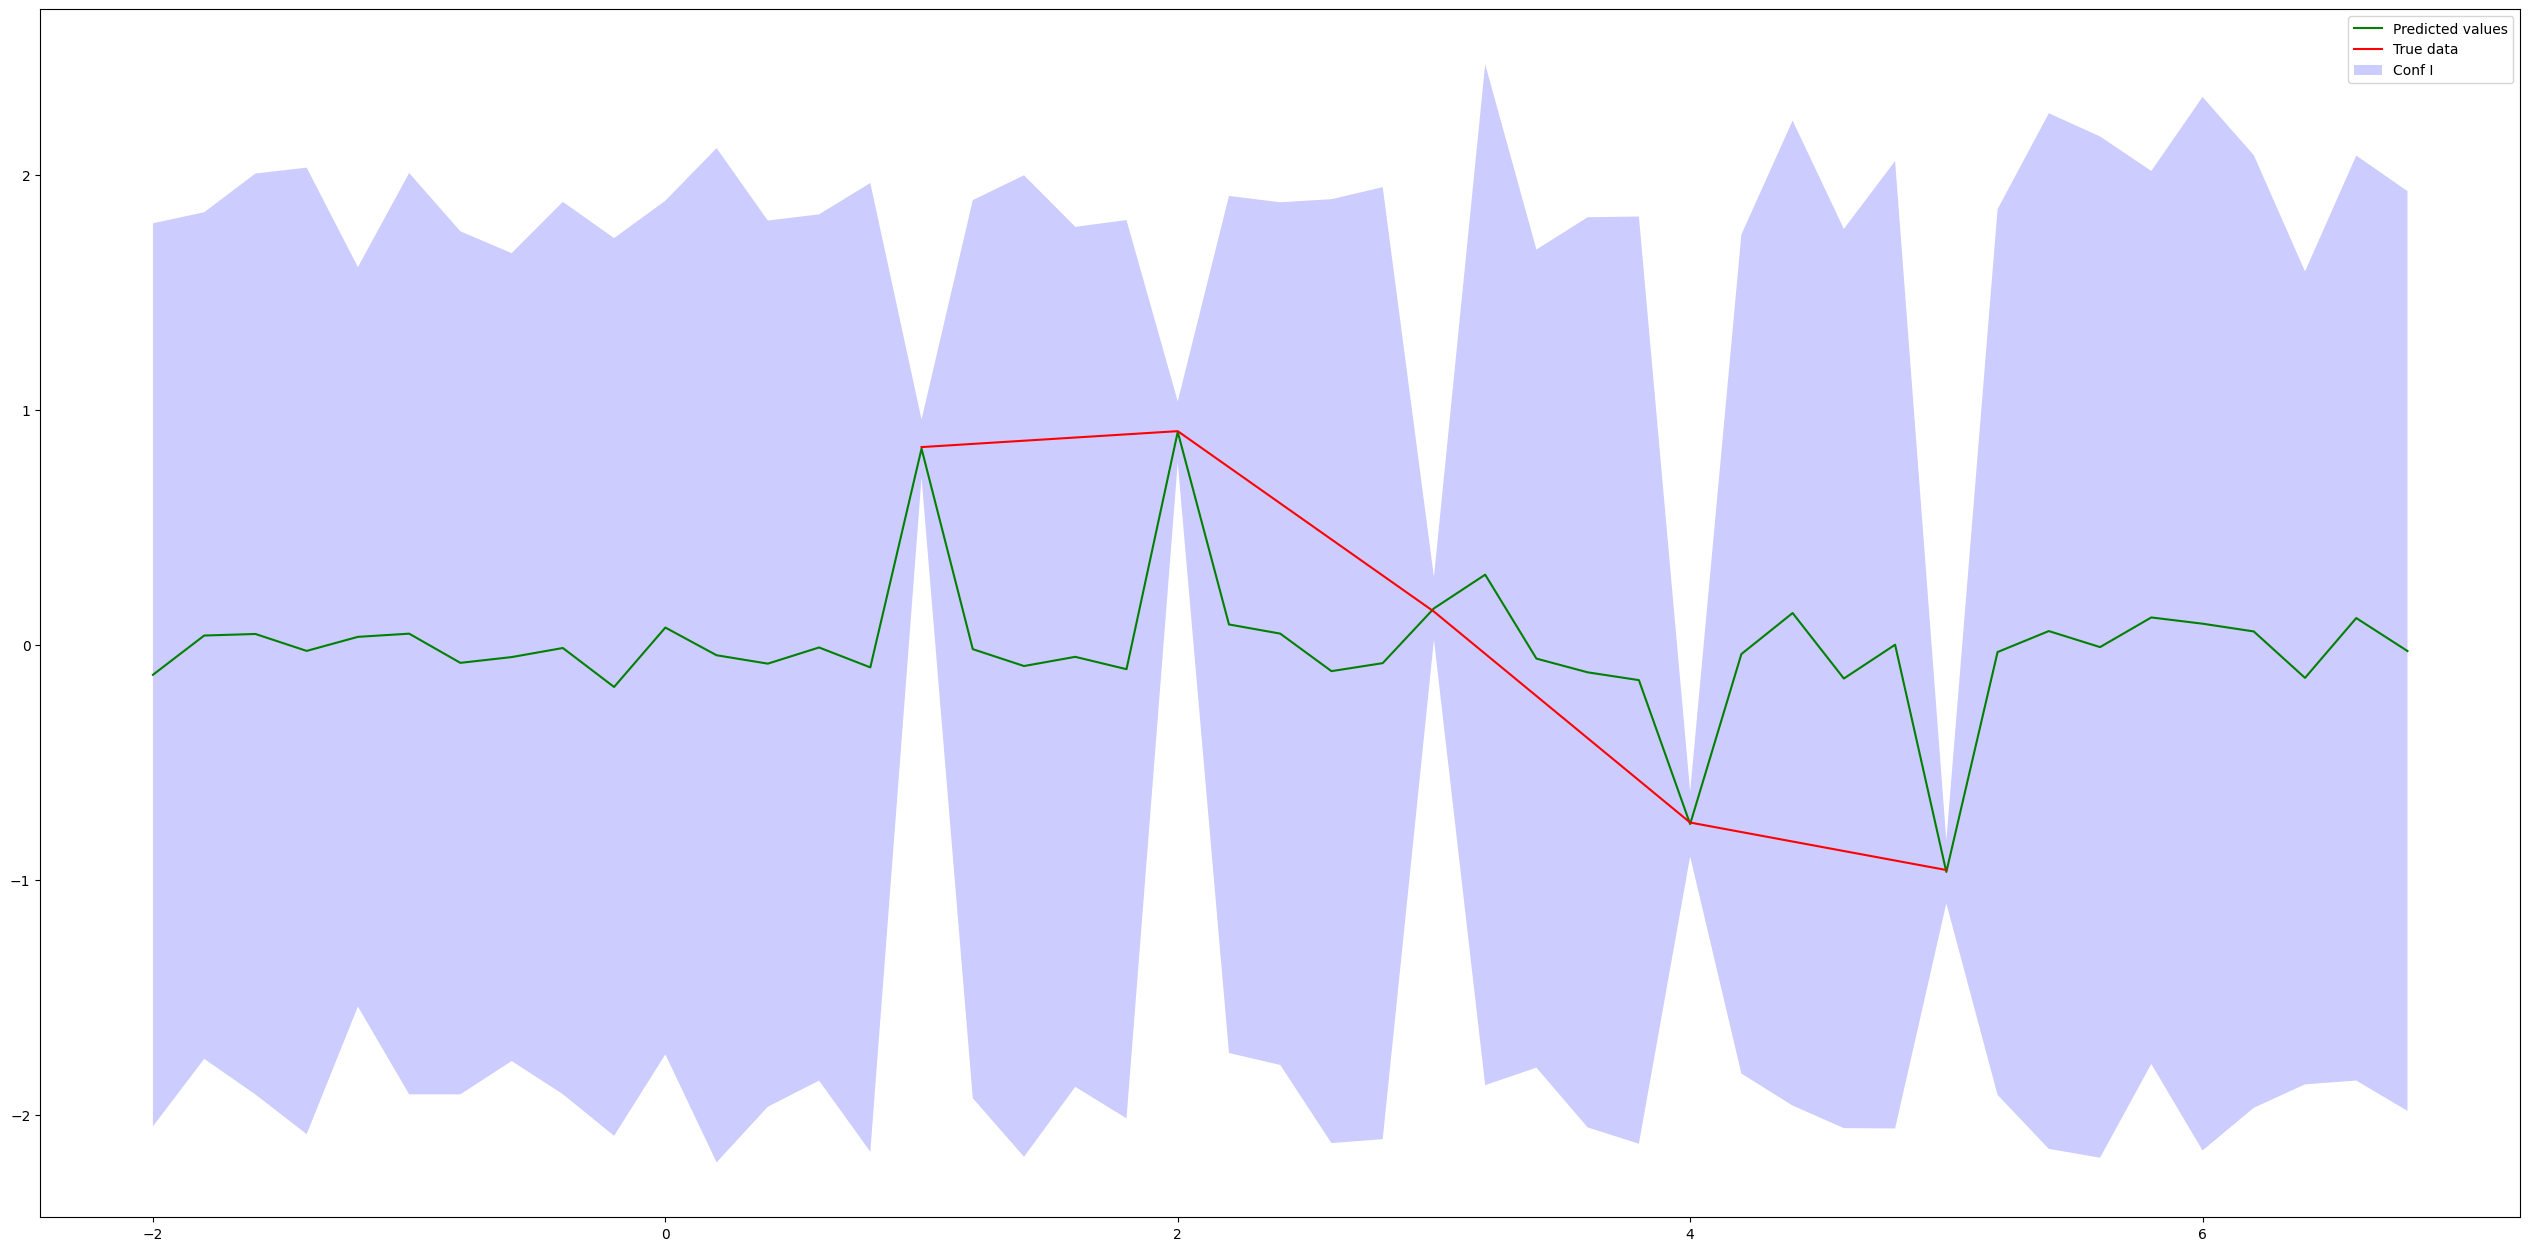

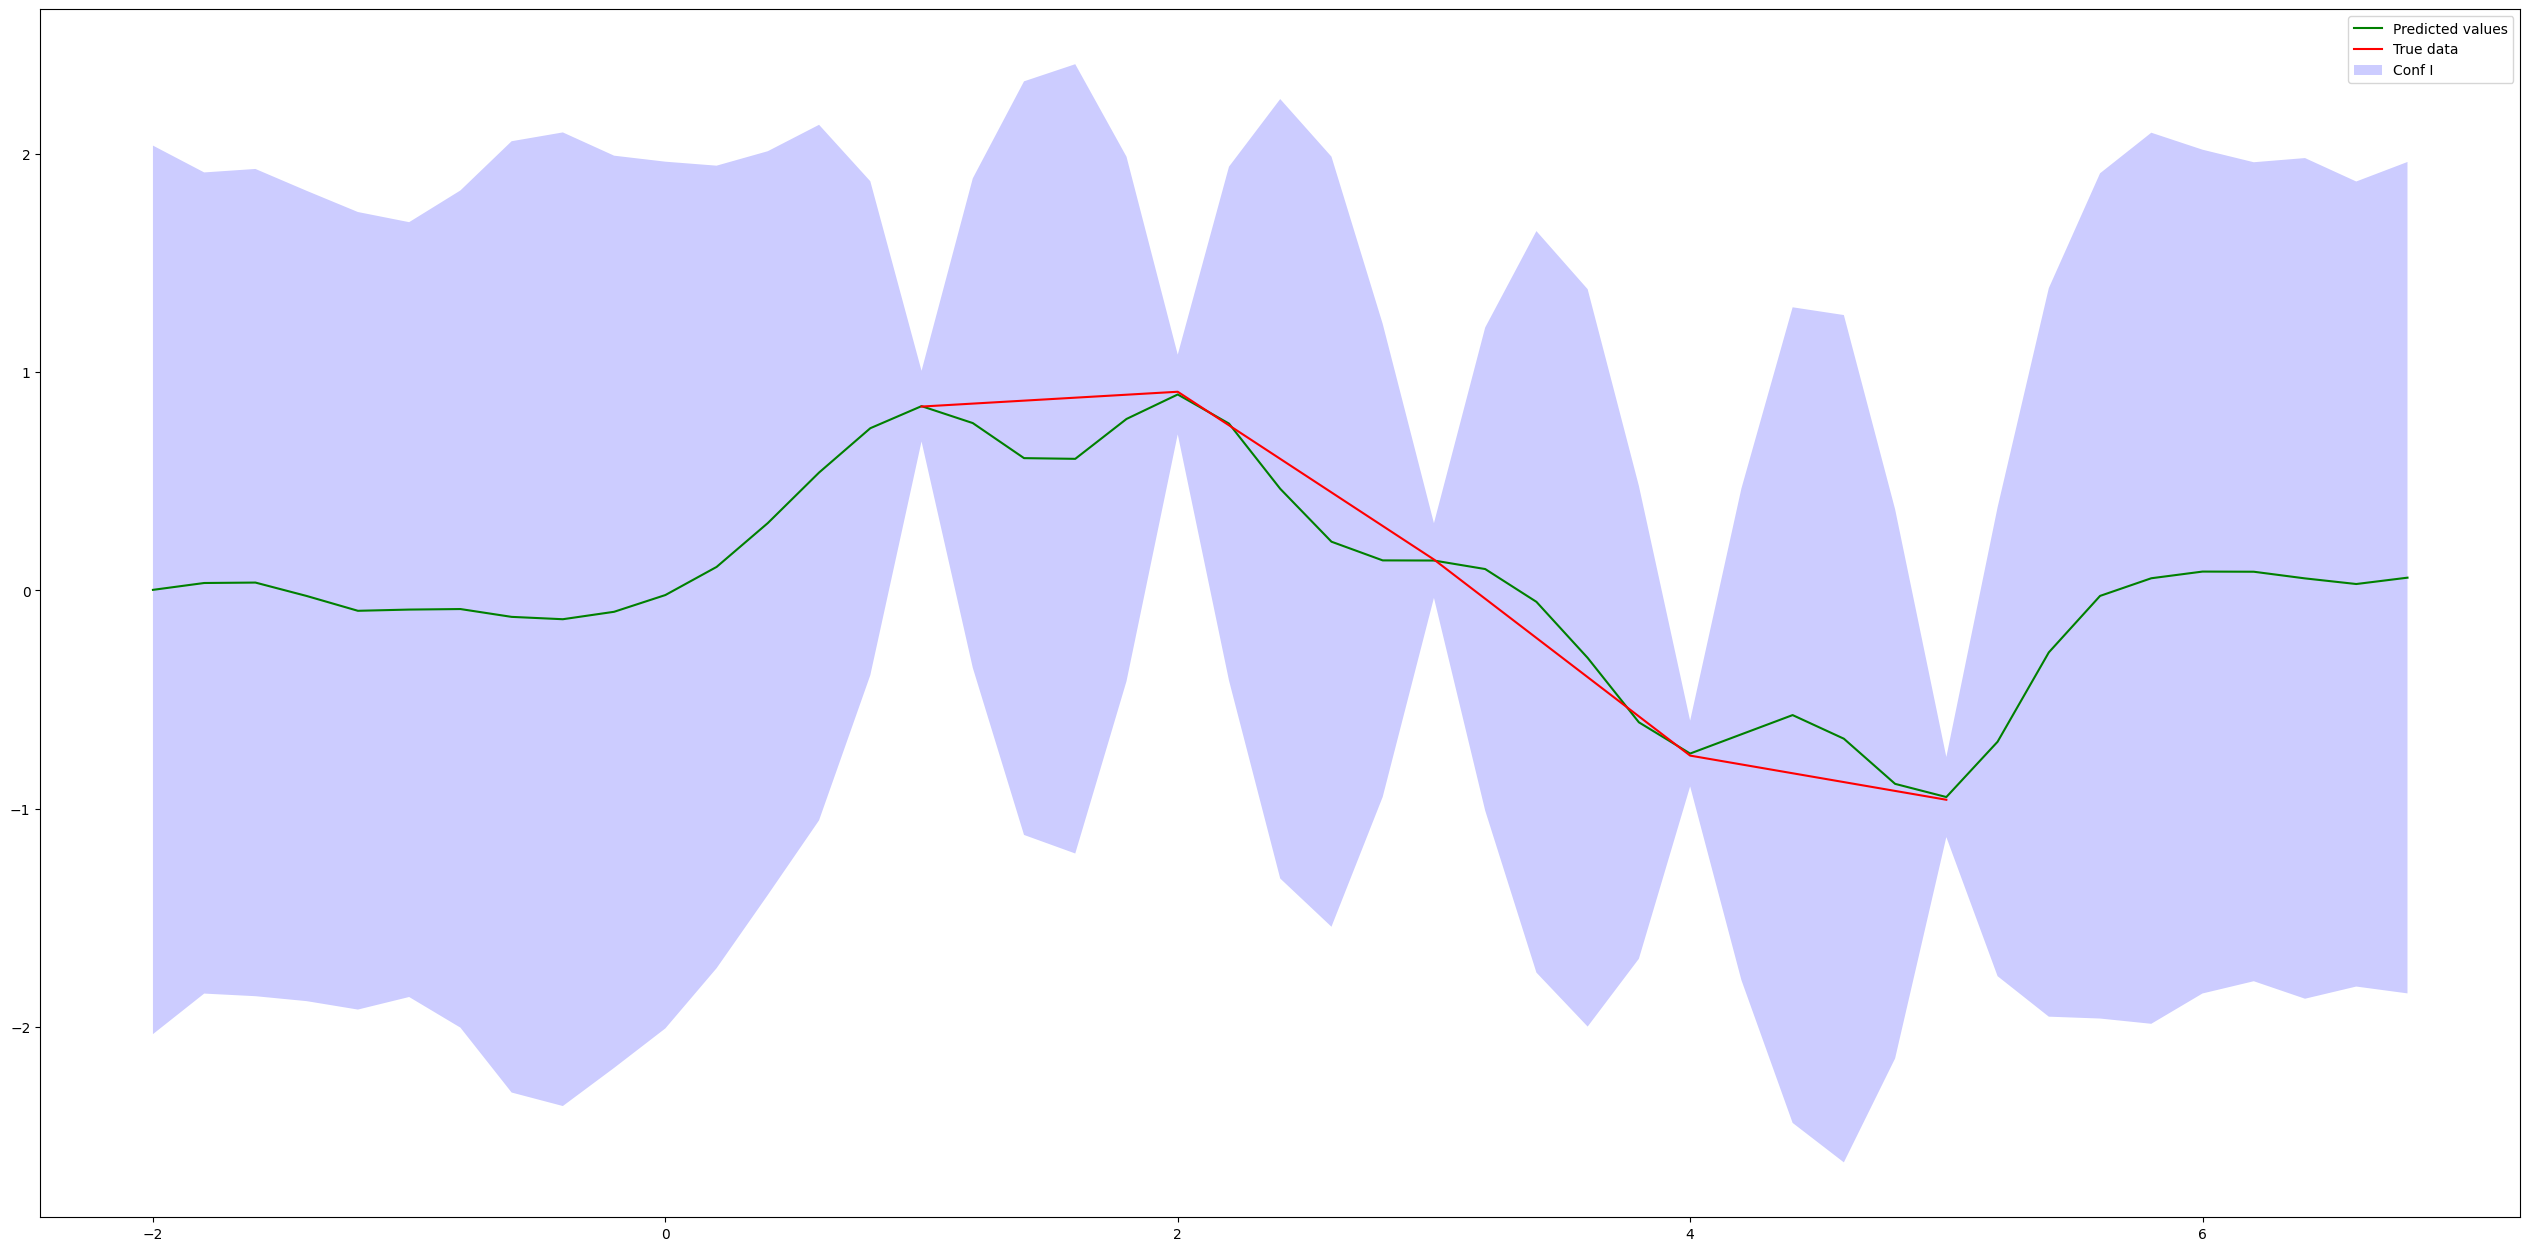

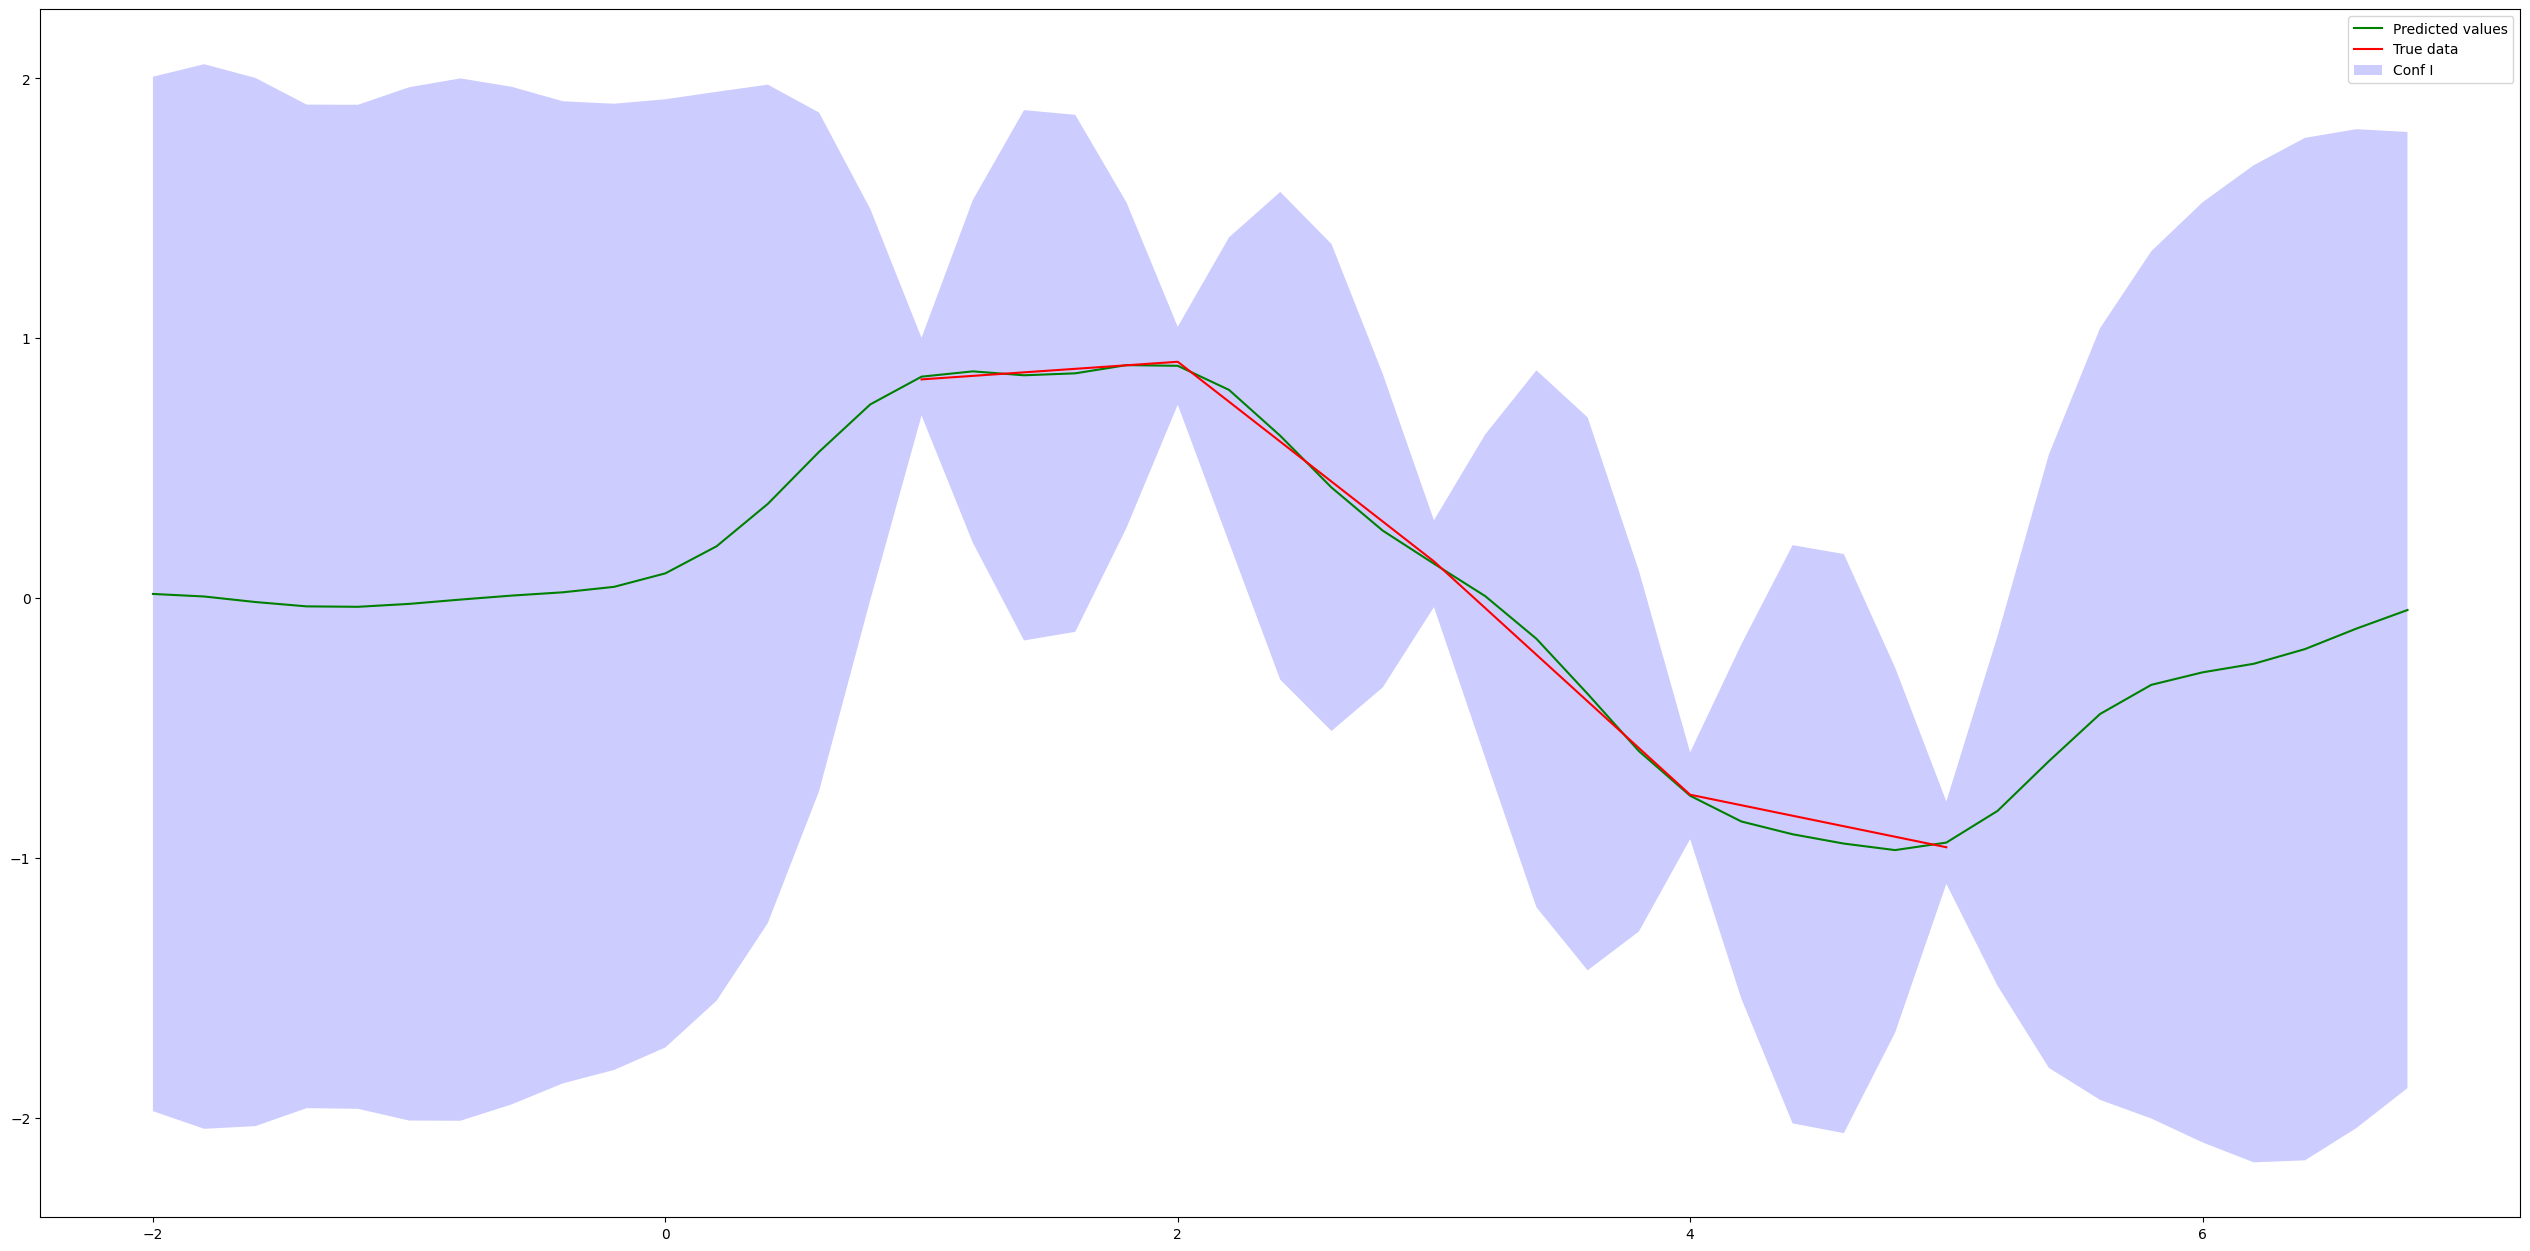

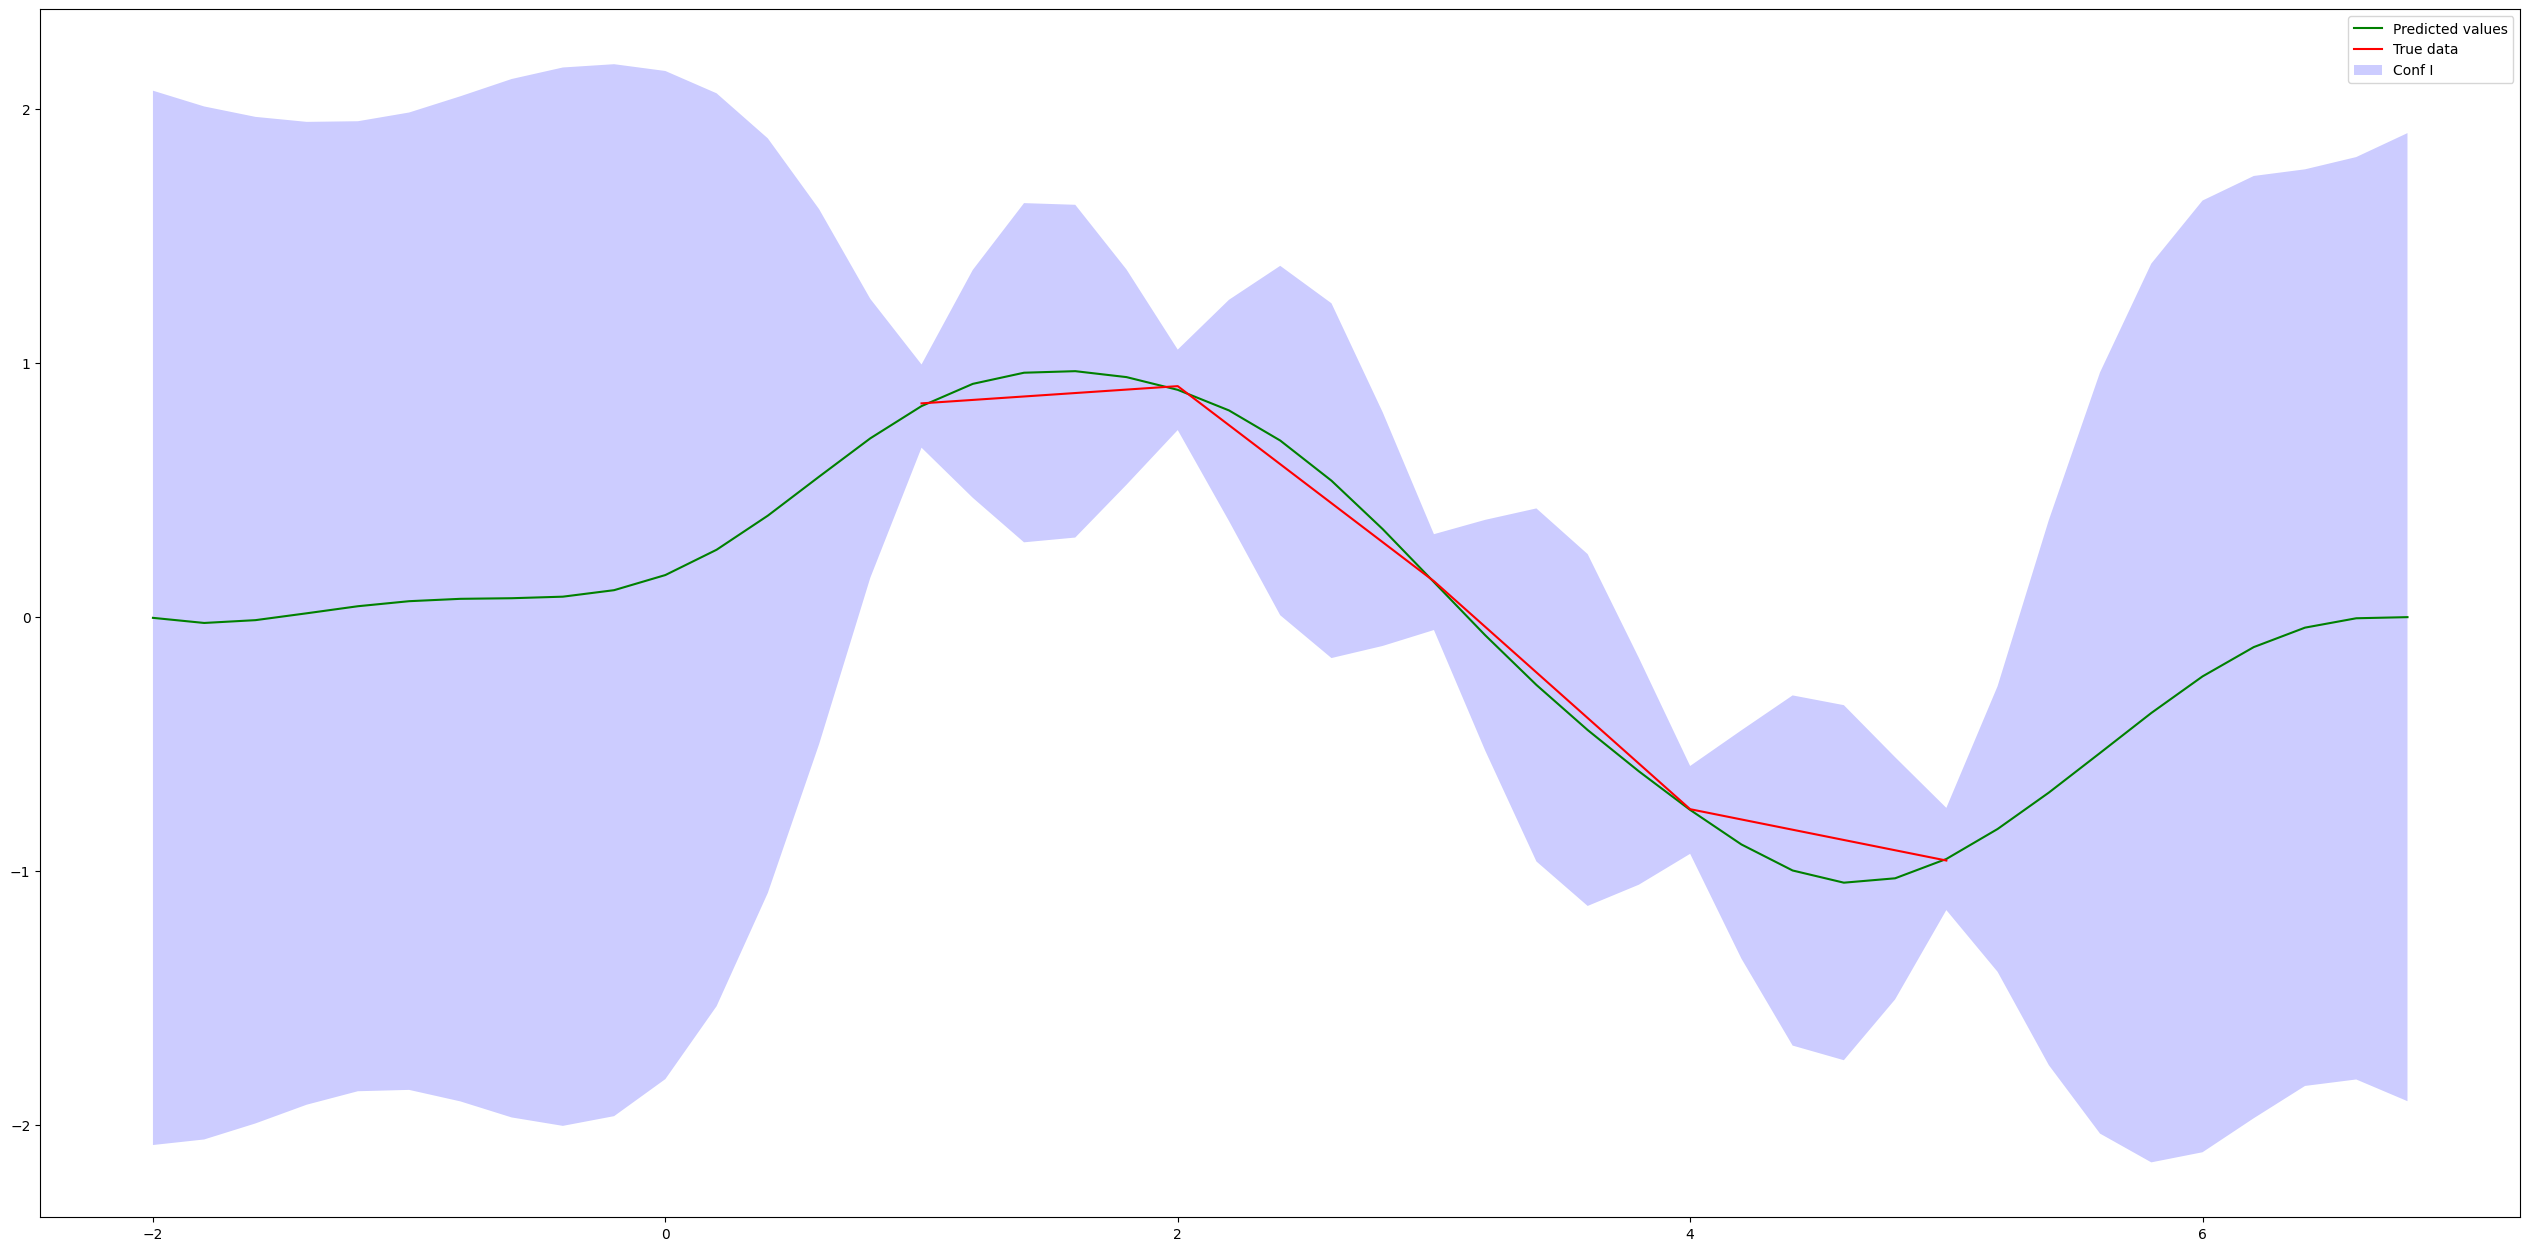

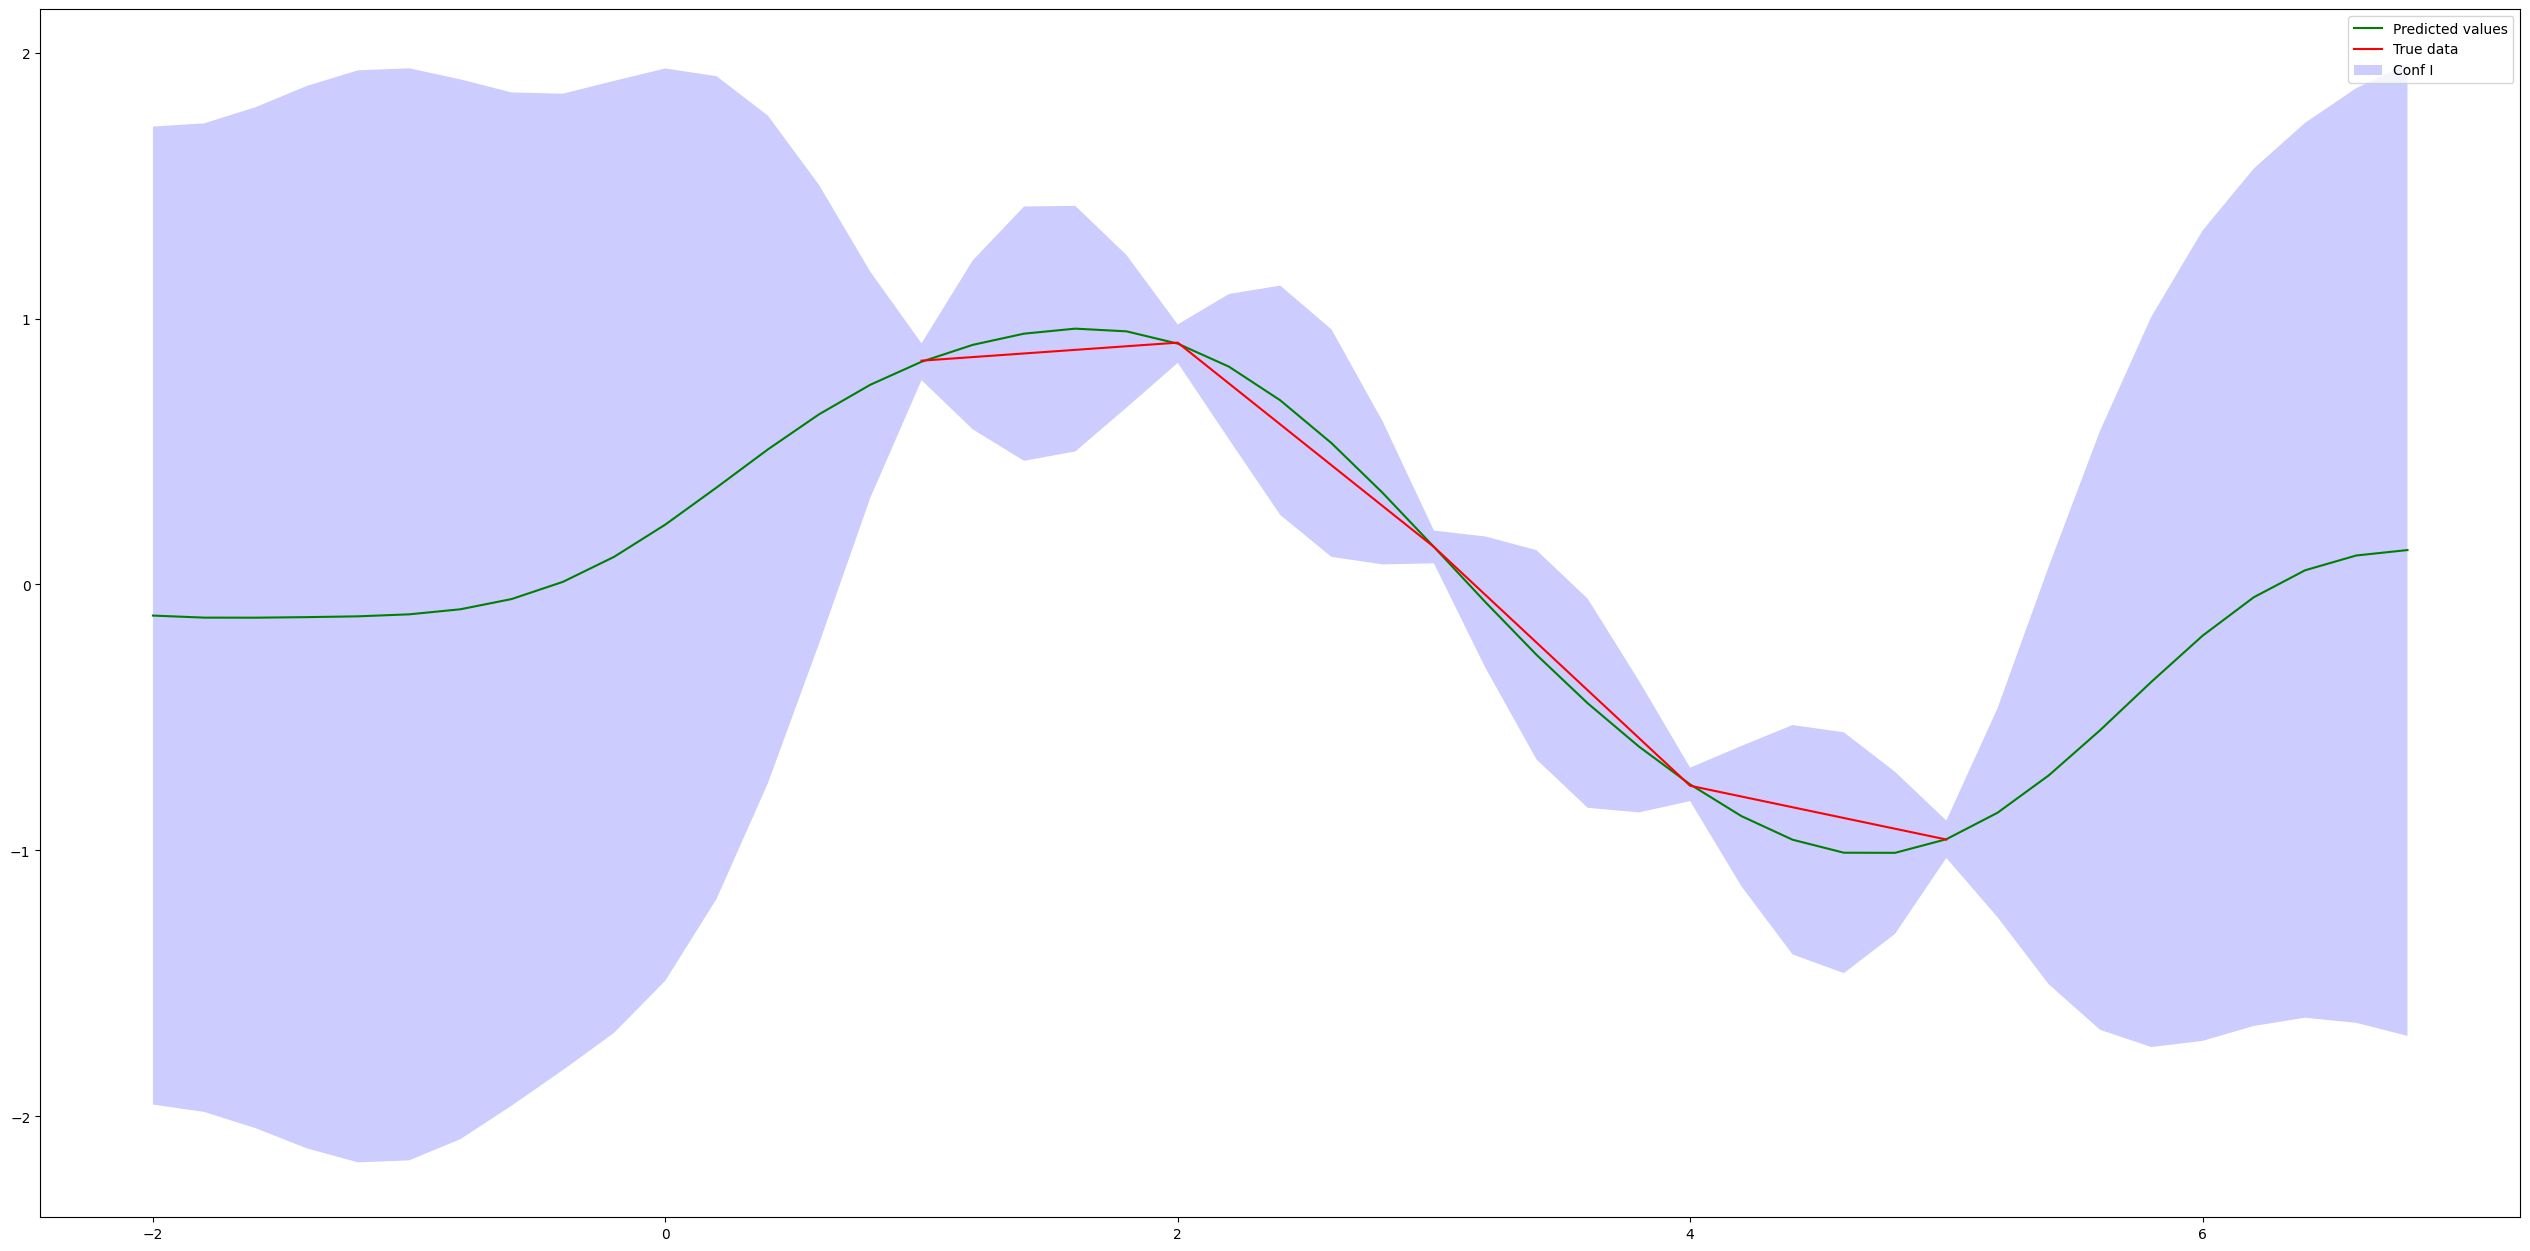

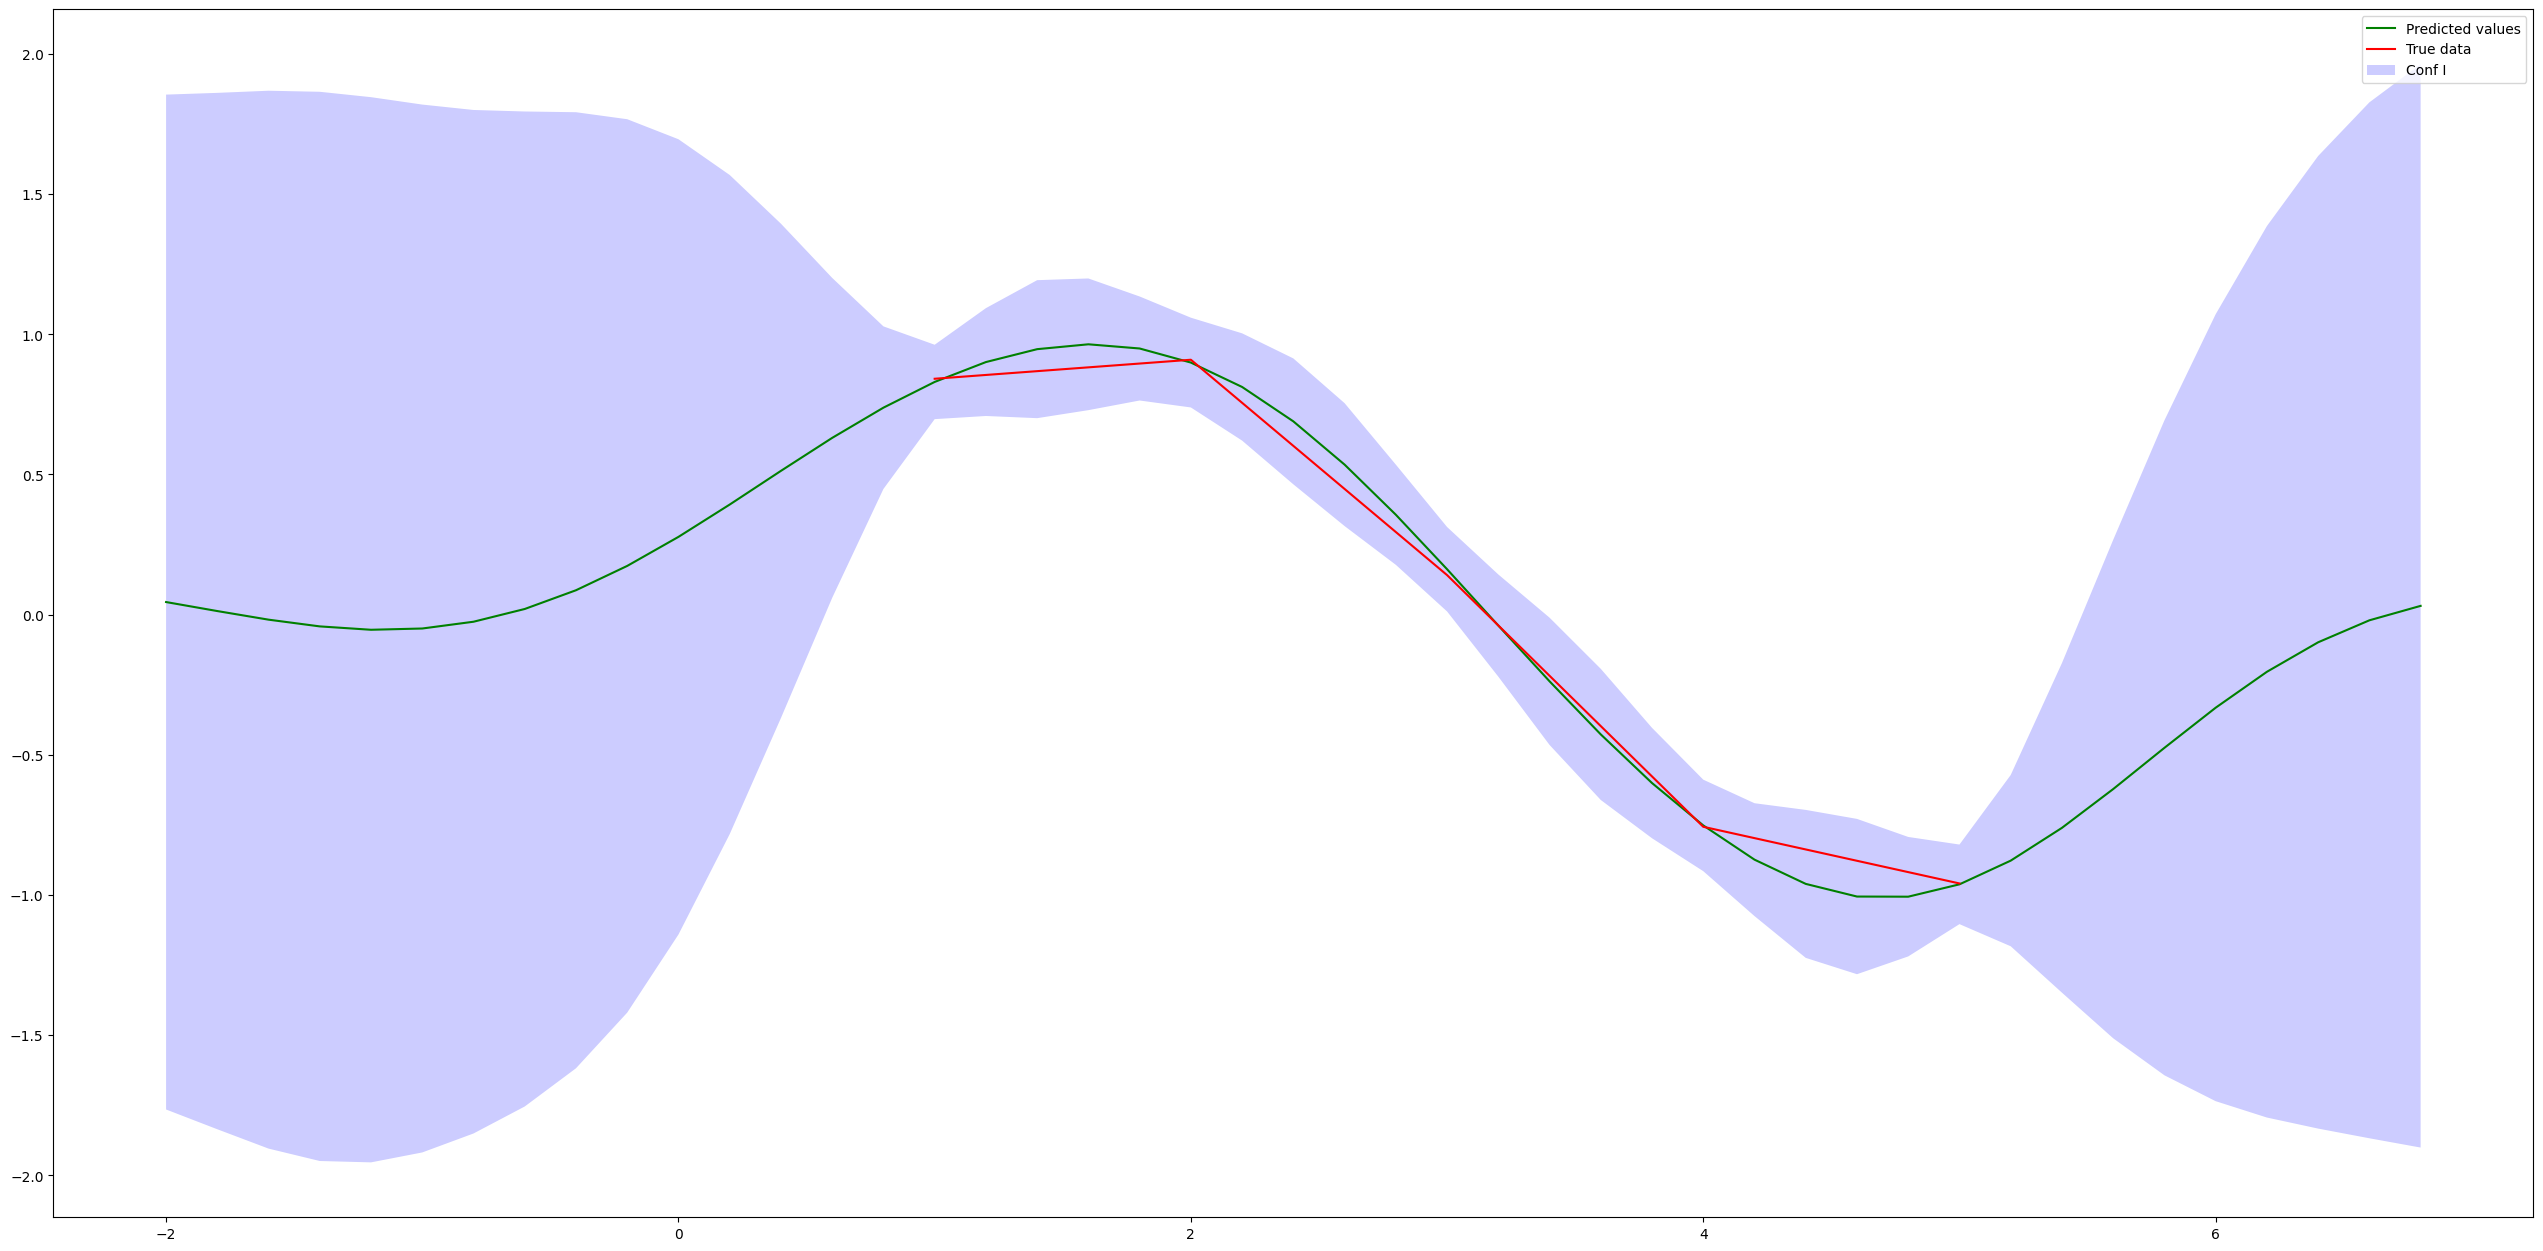

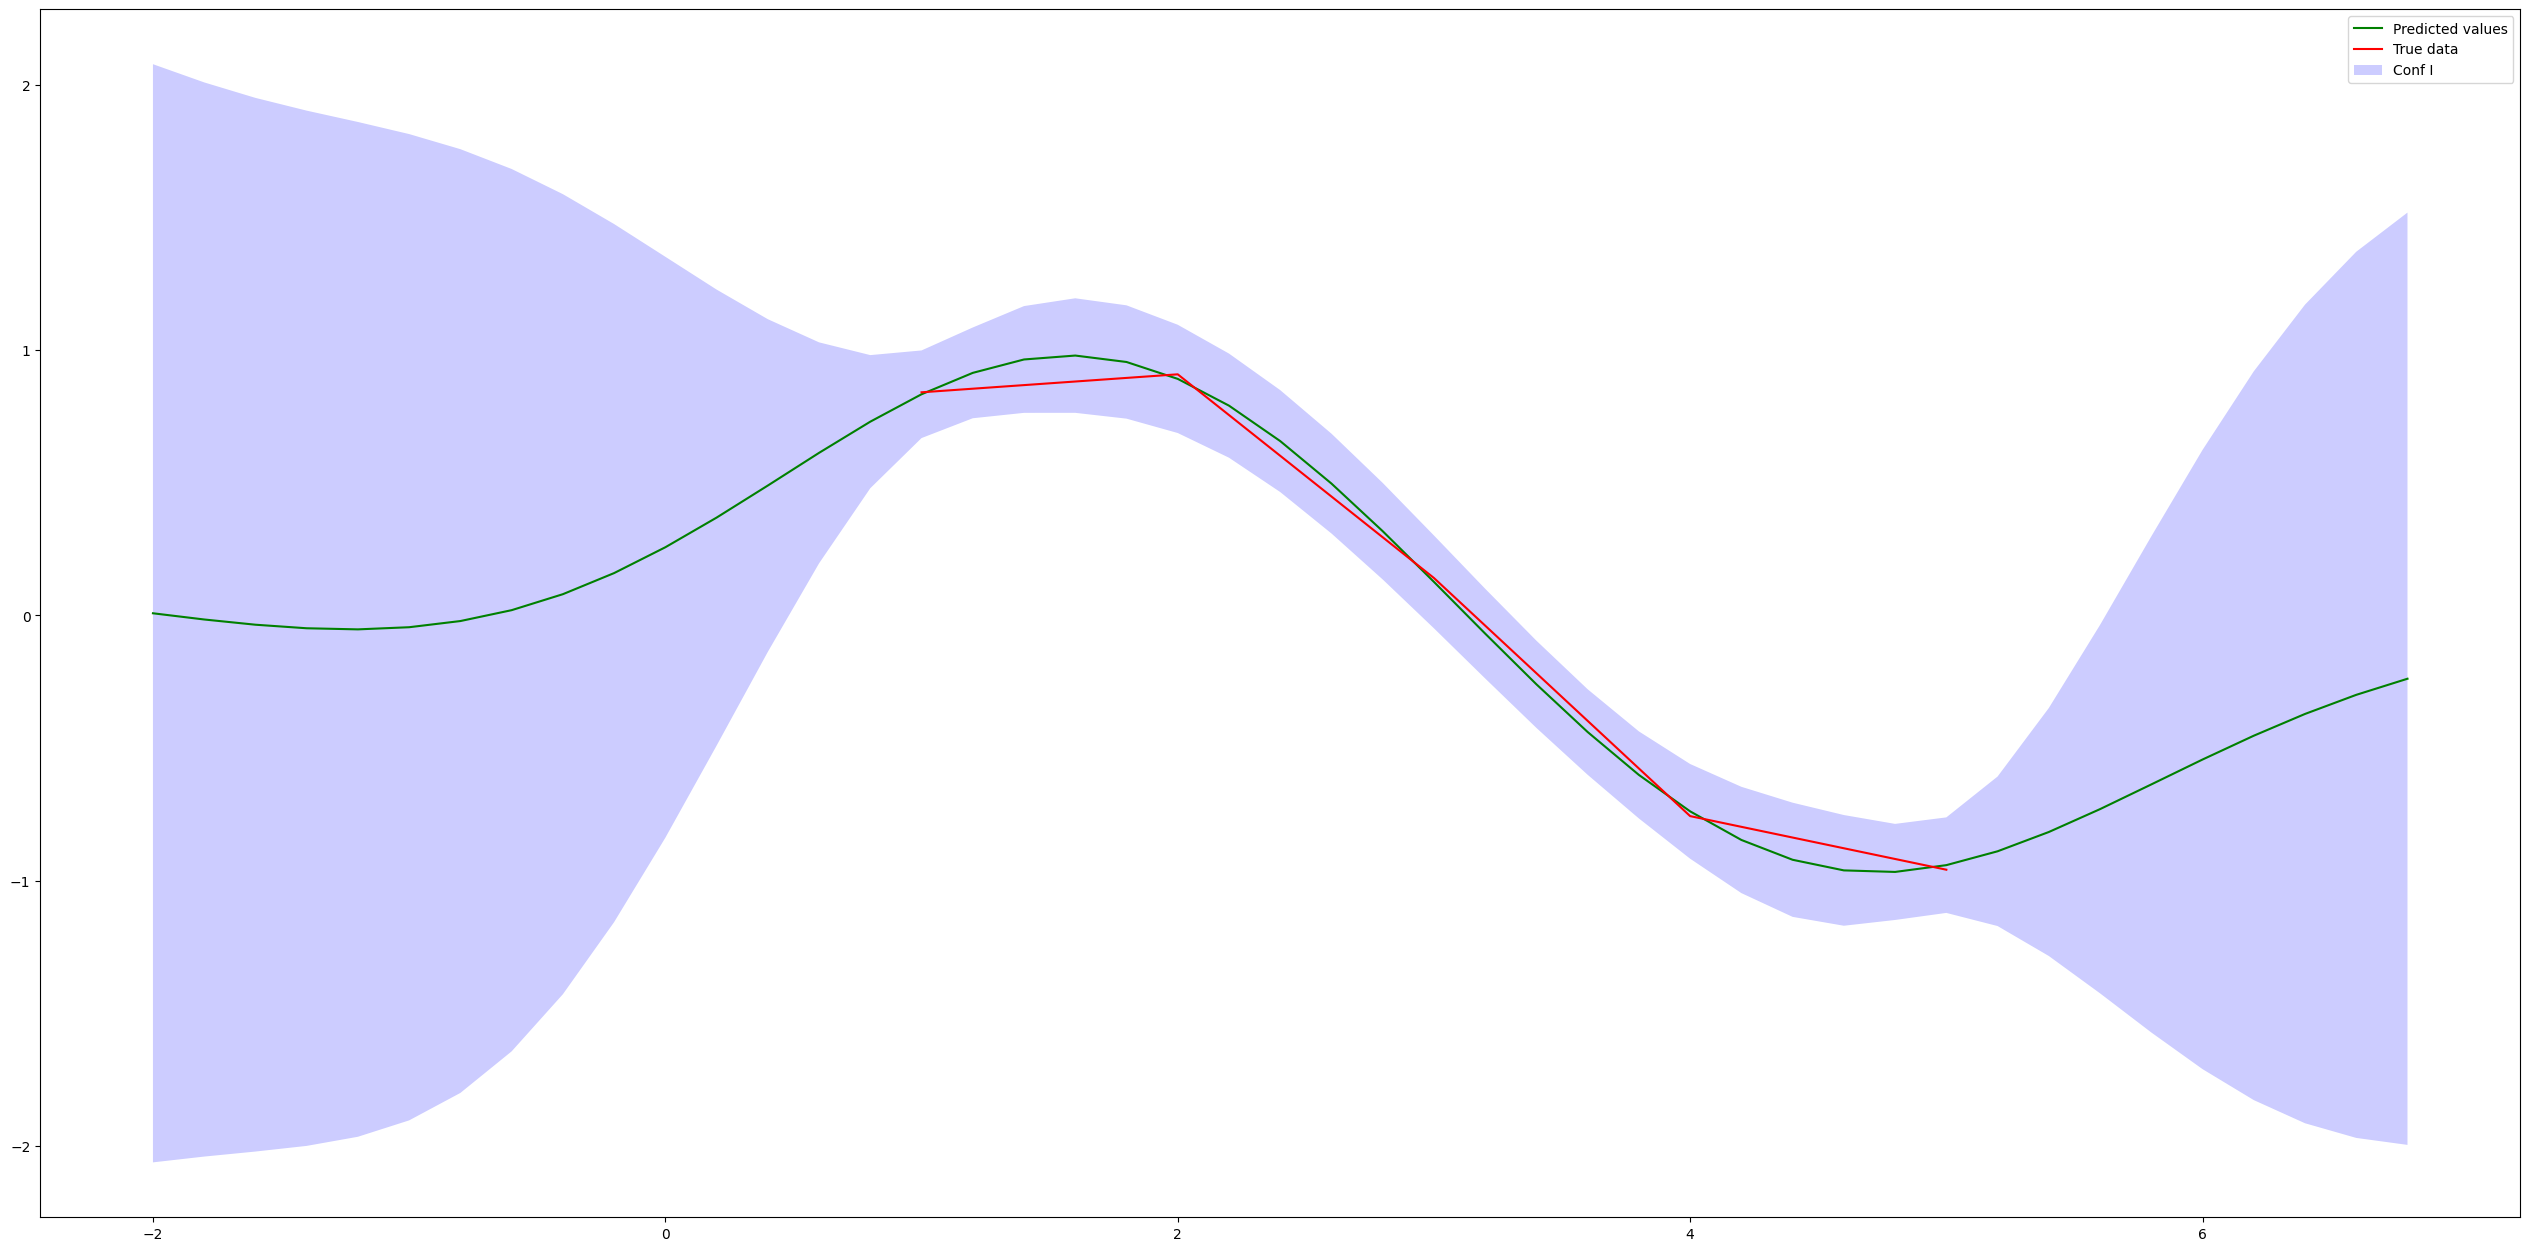

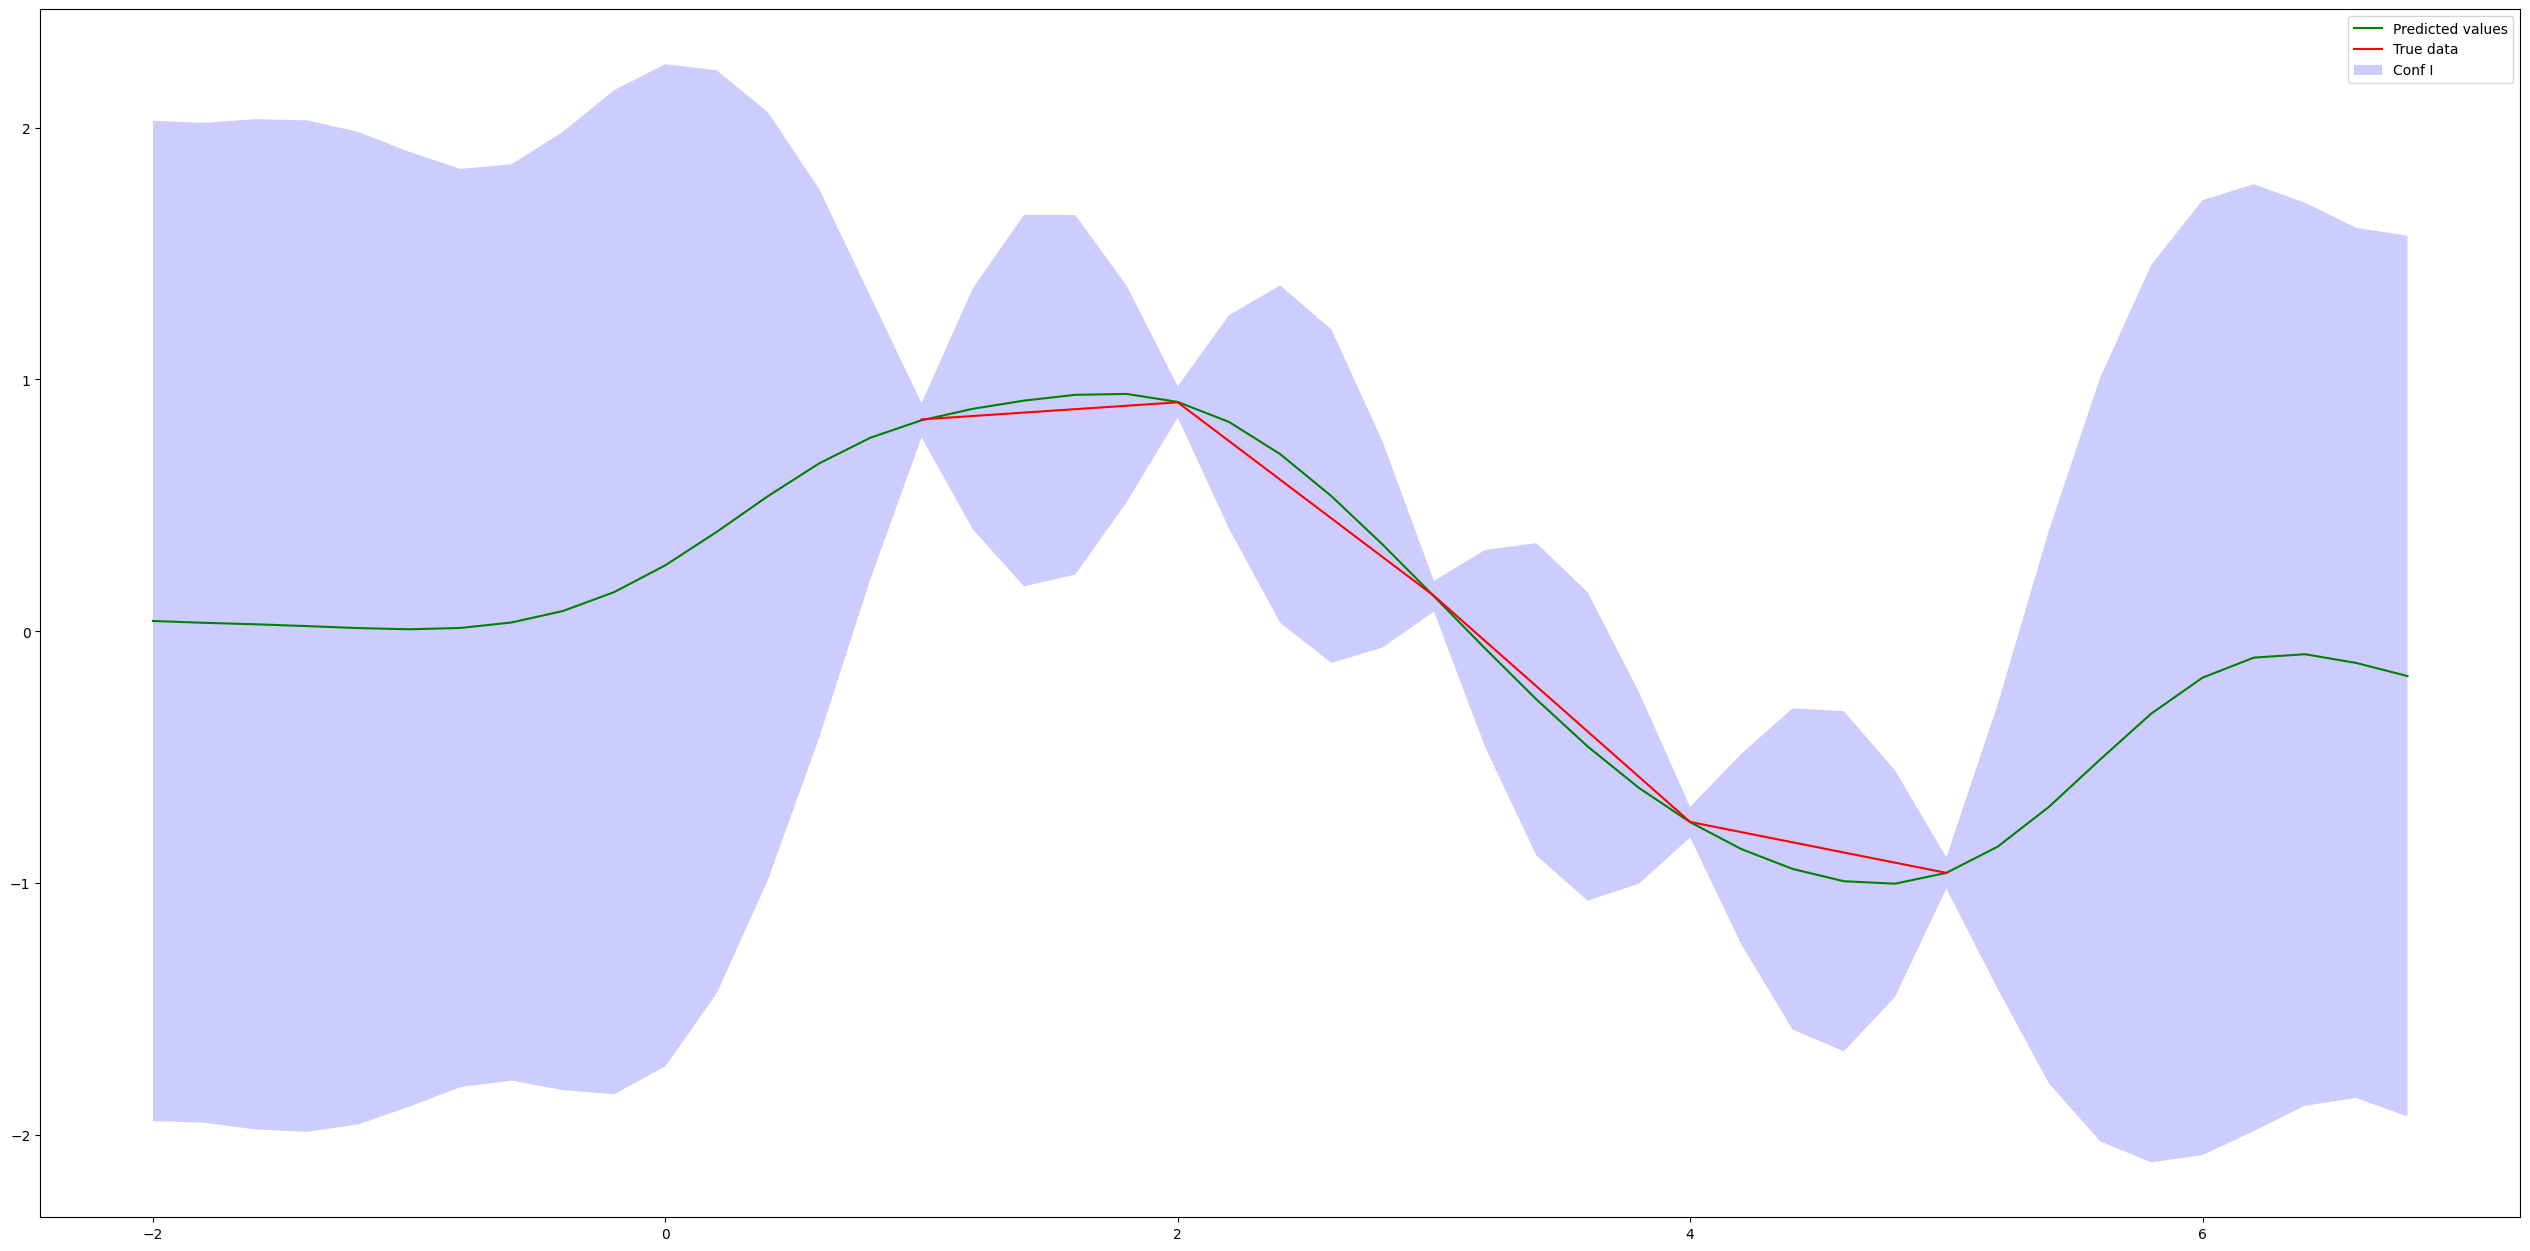

In [695]:
X_train = np.array(np.linspace(1,5,5)).reshape(-1, 1)
Y_train = np.sin(X_train)

X_s = np.arange(-2, 7, 0.2).reshape(-1, 1)

ll = [(0.3),(13),(3.0),(2.0),(1.5),(1.3),(1.0),(0.8),(1.5)]



for i, (l) in enumerate(ll):
    mu_s, cov_s = compute_posterior( X_train, Y_train,X_s,kernel="ExpQuad" , l=l)
    mean,stdp,stdi=get_values(mu_s.reshape(-1,),cov_s,nb_samples=10000)
    plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)
    plt.show()

# Si l'on souhaite maintenant maintenant utiliser ces processus gaussiens afin de faire de la régression 

On prépare les données 
----------------------------------

(178,)


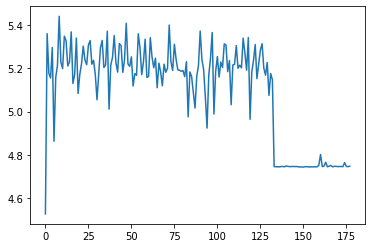

In [639]:
Y_train = pd.read_csv("105.csv")["x"]
print(Y_train.shape)
%matplotlib inline
plt.plot(Y_train)

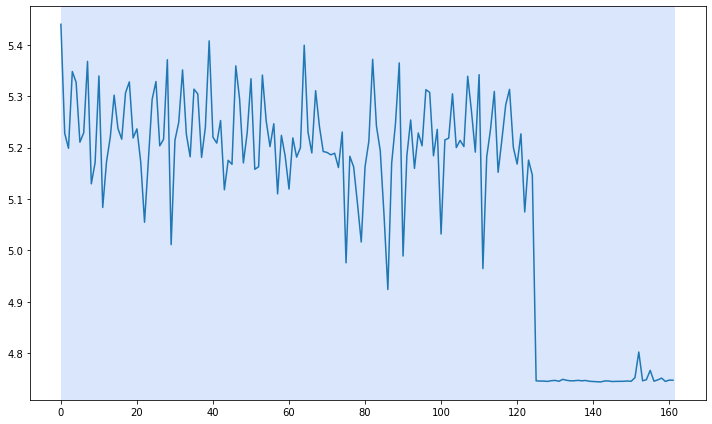

[162]


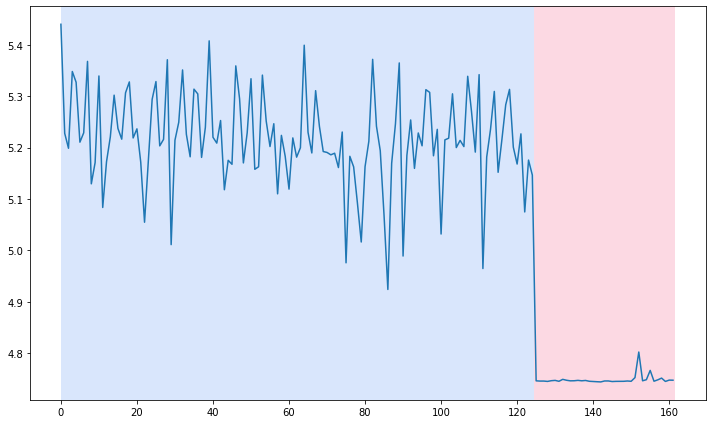

[125, 162]


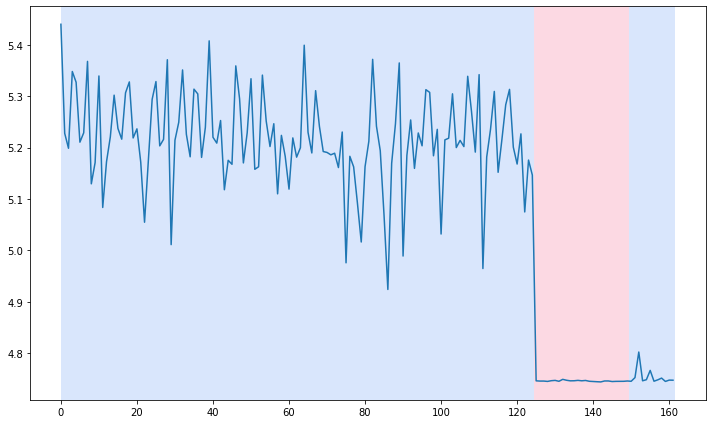

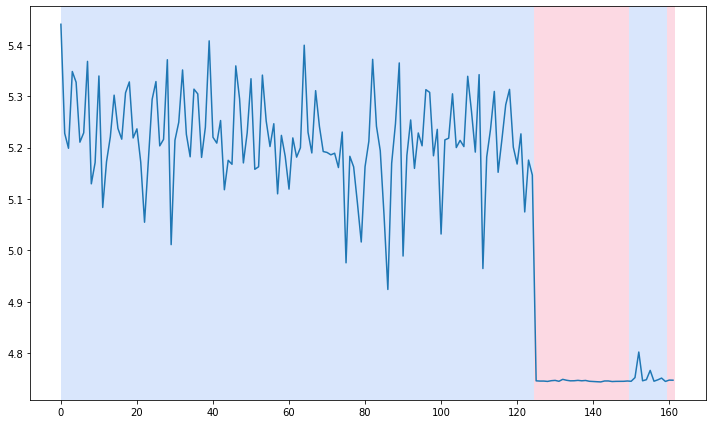

res {'best': [0, 125, 162]}


In [640]:
dic = changepoint_detection(Y_train)            
print("res",dic)

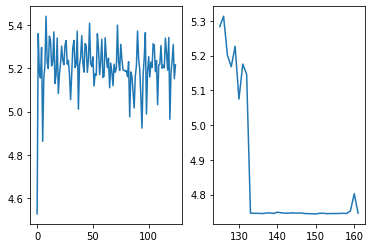

In [641]:
Y_train_arr = [Y_train[dic["best"][i]:dic["best"][i+1]] for i in range(len(dic["best"])-1)]
fig,ax=plt.subplots(1,len(Y_train_arr))
if len(Y_train_arr) > 1 :
    for i in range(len(Y_train_arr)) :
        ax[i].plot(Y_train_arr[i])
else :
    ax.plot(Y_train_arr[0])
plt.show()

In [642]:
Y_train = Y_train_arr[0]
Y_train,X_train,X_s,Y_test = prepare_data(Y_train,split=True,test_percent=0.2)
test_size = len(Y_test)

Calcul du postérior et sampling afin d'obtenir la variance
--------------------------------------

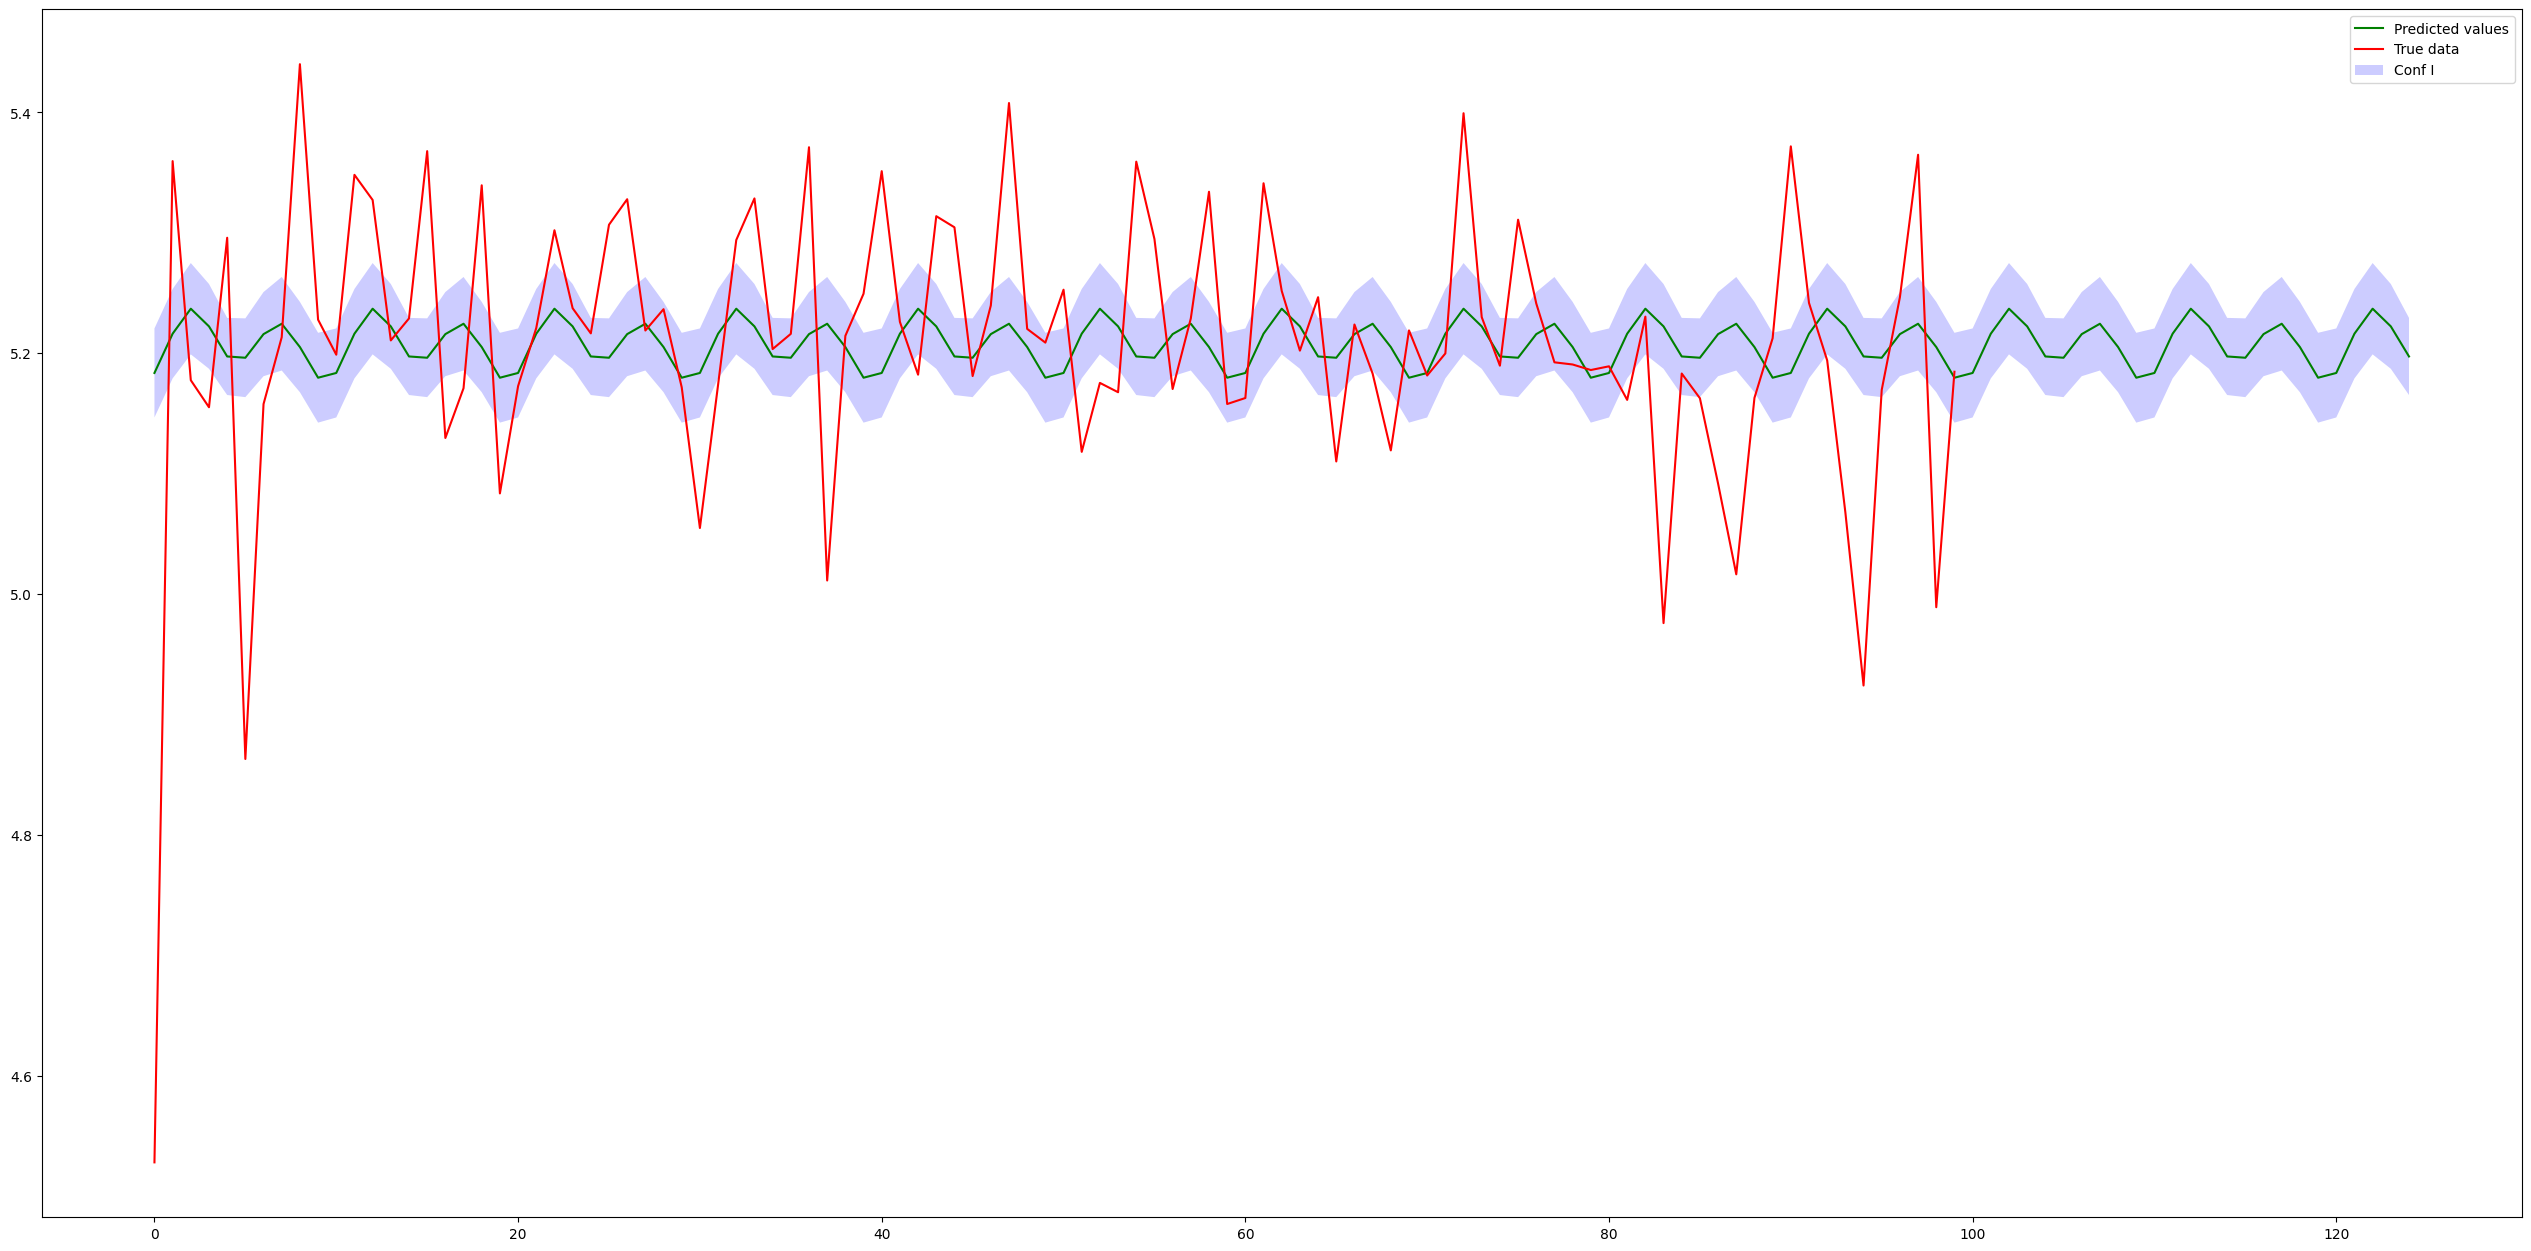

In [643]:
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=10,sigma=10,l=10)
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=100)
%matplotlib inline
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

Hyperparameters tunning 
-----------------------------

 - Par grid search (exemple pour le kernel cosinus)

In [644]:
parameters_dic_periodic = {
"p": np.linspace(0.1,5,20),
"sigma" : np.linspace(0.1,5,20),
"l": np.linspace(0.1,5,20)
}
best_res = {"parameters":0,"score":10e13}
for l in parameters_dic_periodic["l"] :
    for sigma in parameters_dic_periodic["sigma"] :
        for p in parameters_dic_periodic["p"] :
            mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=p,sigma=sigma,l=l)
            param = [p,sigma,l]
            mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
            score = mse(mean[-test_size:],Y_test)
            print(score)
            if score < np.min(best_res["score"]) : 
                best_res["parameters"]=param 
                best_res["score"]=score
print("Best parameters periodic",best_res)

0.011788325142530033
0.011930047630665887
0.01195738031141695
0.011964392741905352
0.011776515002139314
0.01295362290073296
0.011934545234509954
0.012262250980461804
0.012242984413747797
0.012568839032921542
0.011774657151974432
0.011760207669918081
0.01206770563302268
0.011781442141185185
0.011769354338729636
0.011945565176898092
0.012757138778614237
0.011833160002267798
0.011852313065942022
0.012126381339357587
0.012983217669202842
0.012891269559197347
0.012950635869151213
0.01312233389415069
0.013153474547239077
0.01316186785696799
0.012963099617551299
0.01286313837576107
0.013074266893150246
0.012809259229743044
0.012866613501402713
0.013069484887381237
0.012918349060359945
0.013079938833229436
0.01287491889108313
0.012976883005482935
0.013056752896572526
0.012833908227510968
0.01291875387586625
0.012945214486876697
0.01308432926426227
0.013108574627639272
0.013036757056060732
0.013164255238628974
0.013117380708595375
0.013071231383403959
0.013199813730713899
0.013118810718015642
0

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013129293250006143
0.013127592295954695
0.013213501089244198
0.013229156819861497
0.01316960968135108
0.013194899312589483
0.012961813452363151
0.01313735152823982
0.013240695729741025
0.013007953363778415
0.01313822832325507
0.01302324820590941
0.013032327737865456
0.013291218909781856
0.013147995199265879
0.013093995563808565
0.013133208287656364
0.013174799607248459
0.013158457282315355
0.013203764553891188
0.01317618719609937
0.01313696938726962
0.013255424859811477
0.013183012500007578
0.01308174965631891
0.013155627242784301
0.013053800979904419
0.01312276814667706
0.013109858181897045
0.013097210451881613
0.013080446425918303


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013129706599521635
0.013217568950801284
0.01317333097474174
0.013115348909940644
0.013067545632642707
0.01315780487853471
0.01314015715537752
0.01314135380401394
0.013211862198255337
0.013080349730555116
0.01316829367687111
0.013156945253675301
0.013167704143503243
0.01315535549641617
0.01319657803521839
0.013135309419851672
0.013222568649375268
0.01313092999168934
0.013087443824459376
0.013144949776502492
0.013247856965948414
0.01314922120352931
0.013137924981152273
0.013143017342486962
0.013262379372747055
0.013099264250496703
0.013187235476802388
0.013140721826816517
0.01303207685603406
0.013110639648907827
0.013144793426981211
0.013114820717245101
0.013104581813496448
0.013157164220232378
0.013144105283008089
0.013139975883709062
0.01310380738711239
0.013124105939464191
0.013167207664997134
0.013106527629580802
0.01312033347796961
0.01314996735764276
0.013007650797862272
0.013119010936229922
0.013226044943843973
0.013109640673643152


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013140093217467768
0.013094190749920888
0.013103944523702574
0.0130850887212298
0.013091387965325184


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013131198743715567
0.013020243650732934
0.013143735989306325
0.013138204094999627


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013125553766858313
0.013120240771500402
0.013170953053821814
0.013185079116880822
0.013079458428995147
0.013135211218995215
0.01323582369451767
0.013131181200727877
0.013163554721013106
0.013103784986621361
0.013115258250467594
0.013119742903817901
0.013115037001962376


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013132885165406385
0.013031625273702578
0.013208372113542793
0.012993096665223742
0.013230229909251805


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013164953959398838
0.013167280327384203
0.0132049530193703
0.013142767123291212
0.013128894398882634
0.013130694748853271
0.013212332735839811
0.013235039322475302
0.013110210040018283
0.013149825119582832
0.013078810381380167


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013129683025061581
0.013058137364010569
0.013172819237651153
0.013148579094413148
0.013176629533522229
0.013180659163640989
0.013175559220403017
0.013128685023171929
0.013120256555553343


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01315468064553128
0.01324130656315556
0.013132399751278136
0.01314047464659395


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013160775705463772
0.013200306654171124
0.013148877625689965
0.013072014263000302


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013133941401087146
0.051562852856341816
0.021054487003105207
0.018471171599405253
0.013181930609180555
0.012468117056135118
0.012870336787045158
0.012965604225892276
0.011986709038352451
0.012308089173765363
0.01196306087221536
0.01186538450404055
0.011773662156651845
0.01209920170539213
0.012069607552919142
0.01253671509563803
0.0120371433417311
0.011920117159989183
0.01168180451494332
0.01169015621487591
0.011916419006326453
0.017187184279405982
0.016591985181257478
0.014440288448126011
0.0140986445832552
0.014202044419135786
0.014639833249558287
0.013815694055642314
0.013604895541809641
0.013806323476481547
0.013684140303801759
0.013657552692734267
0.013723647826286448
0.013495382192399215
0.013713020871372597
0.013111499360075324
0.01328468456995448
0.013556466762299784
0.012981517654134704
0.013181033505714116
0.013011462953141859
0.017233603558364362
0.019236510014802463
0.015313111116111222
0.014839423510866973
0.014465532308773382
0.014176230996807973
0.013940663908555832
0.0

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015154629534708903
0.014306270121082139
0.014251117659983494
0.014223655410570545
0.014202643157031241
0.014140624737662784
0.014057432547023739
0.013956527615869813
0.013573464803192214
0.013809545530302513
0.01885754138518531
0.01888676413569189
0.01678344606350811
0.01544598567539821
0.015189868793325843
0.015050030320854795
0.0146730345893115
0.01448255033444494
0.014689553190234707
0.014284955197528267
0.014526389961887813
0.014335924878026067
0.014088276286082382
0.014116343041321217
0.014079248062603215
0.013923818597400738
0.014380439233398217
0.013972831737527924
0.013861636385342362
0.013841075491118172
0.01864276026382528
0.019458123001604034
0.01685169596321809
0.015272660843882178
0.015216265500743396
0.015259450322853495
0.014669718982108252
0.014443663299787642
0.014531767511831953
0.01445008959474224
0.014171559247768011
0.014366383459515766
0.014164876709701488
0.014327911381188498
0.014239172237098587
0.014036003731929083
0.014295760914798027
0.014302842231993311
0.

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014362937457811621
0.014071924736881326
0.013946299991517119
0.018594267357511046
0.018959894868903048
0.016636915225417836
0.015254041760231665
0.015009551500900855
0.0148479889756502
0.014934677257304825
0.014602080645564796
0.014493954044548658
0.014514149125526081
0.014238684378276967
0.014530548582194665
0.014406483059517545
0.013988197554509004
0.014108820672216605
0.014326518777707471
0.014177321694507415
0.014091051709551515
0.013950164704641797
0.013922281285017234
0.018739682125378052
0.019241716664951017
0.01689804193937068
0.015949625253263475
0.015190301207105154
0.015425343839898666
0.015111170554766717
0.014499178126015406
0.01469243193146923
0.014560947264081046
0.01437137145889029
0.014483484719713835
0.014271545107577631
0.01418586560338574
0.014202219614530817
0.014026514347173129
0.014193531809230234
0.013999780157090523
0.014125516193016652
0.014254870410224916
0.018451818665936908
0.019023359495923358
0.01662558634623165
0.015298452743597687
0.015365140976343332

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014840858658645826
0.014323900564785138
0.01420948737624319
0.014189272532462695
0.014193399645369848
0.01425503126432226
0.014026788354615355
0.013879688830602498
0.013960424972044852
0.013966925396639915
0.44498174536119783
0.021100067411726098
0.014647092478198375
0.017114206487185306
0.013854572104268017
0.013216553931556137
0.013024380479008004
0.01275144090841645
0.012572645766351882
0.013489140099755001
0.012532293053178297
0.014234773114659623
0.012494882809218889
0.013330902087752472
0.012718040472179903
0.013013603464072501
0.012271934371701192
0.013274296174034549
0.012631226768933962
0.012235566993131696
0.2828917902085933
0.021204470550123183
0.01555787474958583
0.015389105981356892
0.015695037082180317
0.015223754259559092
0.015539763380796344
0.015155250417652439
0.014708217109146084
0.01423868080771115
0.015610925922246938
0.014117748826647902
0.01424933525325432
0.014371869659836684
0.013918687795615774
0.013984659355504603
0.013796788110746933
0.01400124420940735
0.

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.016176828145299395
0.016112851936185175
0.01595308724743827
0.015799921821249886
0.015899485941607845
0.015701066379302114
0.015605842257461026
0.015505263364627176
0.015843726881263065
0.016097340735669416
0.01512245140228407
0.015340076763321308
0.01591247976403071
0.014885368697461564
0.22920666181354954
0.02689493602222245
0.019110558614229008
0.016989885527223244
0.015744097789712762
0.01617782053469282
0.015812790140332034
0.01620485378856373
0.0161238218067405
0.015933012725326694
0.015994365206087605
0.015802808326007833
0.01578688279243368
0.015676450027689456
0.01566886596395081
0.016019918728930212
0.015646838989795468
0.01563449532788407
0.015255727346352237
0.014918609407664018
0.31739784041921026
0.026628609026602974
0.018196880298170917
0.01617692503116935
0.015617727025306253
0.015851150172333173
0.015864575224998248
0.016426781413097367
0.01620591378306986
0.01601125749870659
0.016091706748485233
0.01587439943288723
0.015968761238414036
0.015439408034235037
0.0157543

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01609541467299011
0.24978582497450122
0.026143671670272733
0.0178435383235394
0.016980890593690047
0.016913442490376886
0.015827568299509195
0.015931286173870983
0.01594411938635952
0.0160632857306447
0.016138142635710555
0.016179677599162817
0.016079756198961306
0.01600986190920681
0.01600171814745023
0.015803532575827527
0.015629989273796392
0.01534518881413422
0.01494820374537601
0.0156724723208599
0.015831341125161255
0.2832336531413754
0.02683407244377059
0.01794931989414851
0.0167256630419486
0.016153790591514266
0.015874009684050464
0.016071242313523405
0.01617381857250594
0.016098644603423383
0.016092251721975145
0.016061139908625975
0.015944225519947466
0.016138615283445575
0.01613625197476052
0.015850554648210235
0.015397359192910028
0.015610717685702515
0.015344571980833166
0.015281265921529865
0.014943773305019416
0.8427896373543246
0.018331368773679274
0.018021532520370757
0.015165858480037247
0.014726218880035462
0.013987953620977864
0.014353497783024556
0.0136855604174

0.01563029625453646
0.015492235914037115
0.01602992236855255
0.015518414906702542
0.026233184252324723
0.023926930969304316
0.021967384348020286
0.019317081826554706
0.01816101586693123
0.017405254847493067
0.01699523123085542
0.01639026220836106
0.016270457476157844
0.016340786930725923
0.01640765490617686
0.016337515054860866
0.01638418603773904
0.01632911117416935
0.01623602891985281
0.015597014493982833
0.015710045600818175
0.015722185412385653
0.015779553742616435
0.016103795424631365
0.026206686469466854


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.02401946384462106
0.02214980327137446
0.02005210416106093
0.018414349353956094
0.01801273613259071
0.01692800274705182
0.016424658837194402
0.01632693668580792
0.016154737028231704
0.01616367788347127
0.01638018969718911
0.016216219462411096
0.016191372288270143
0.01611718476122787
0.015892193881399615
0.016005108978347032
0.015516051389877163
0.01616066250954983
0.015616390600849399
0.21109935083858633
0.05319892425379984
0.015666579211426033
0.012443303573654507
0.011300382255501822
0.011144291988855824
0.011070122590463478
0.012331557157656691
0.011536027166577785
0.011715821673561035
0.01136267329922896
0.011309221529643651
0.011502748167910715
0.011849192146597763
0.01132586372752282
0.011404736413727778
0.011264606227649143
0.01144265405716109
0.01128905520860592
0.011813627815919318
0.01733160654445636
0.012725954758109295
0.012619566775209654
0.013472515558500313
0.012251195774825854
0.012224671072978796
0.012245039693170954
0.012150432785515164
0.012283132334199826
0.0124478

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.012543356223240208
0.016758647106417383
0.013067966495011511
0.013061595896576817
0.013438203941777487
0.013565425888909183
0.013531014736569718
0.01259212414092692
0.012466874513662676


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013358679248063802
0.012583490353548237
0.01253686002475345
0.012678249787401225
0.012557313497735135
0.012551794807545823
0.012454897032649846
0.012546022902761413
0.012525472022300622
0.012572663698007937


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.012561750746866461
0.012626089387951784
0.01643671612605873
0.01401427212455796
0.013162972662115847
0.01345842326556215
0.013558998366019998
0.013530937769781941
0.012715164383837964
0.012749782865334701
0.012476967195027338


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.012653918064265612
0.012571190580512603


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.012469548571175826
0.012557924224186716
0.012536230743797032
0.012543106310224547
0.01257218730802313
0.012539196162094484
0.012419097049056091
0.012564443754566668
0.012542947095647582
0.016298587848088086
0.013037911788579507
0.013025336719393692
0.013638086200468177
0.013272122097041948
0.013395761181706337
0.013012204017816265
0.012666765811044797
0.012604215113014683
0.012491847288825688
0.012489993665429452
0.012632247288708875
0.012543142735952835
0.012616131051518374
0.012588040931350759
0.012548647964508712
0.01259956998517971
0.012482249458570906
0.012455778818080066
0.012540295761646858
0.5062491775830487
0.07134810560227575
0.02456015645343
0.010946683483810333
0.010338780734708833
0.011837670372955184
0.011479418149141581
0.011535252552947217
0.0118069626758183
0.011237289966605063
0.011444330612920628
0.012072215007307882
0.01165923469850677
0.012391565317667847
0.012431446652331514
0.011478171890392724
0.011511507061882895
0.012081505508436816
0.011410173533890296
0.01

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.010834024694122344


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01080154294728778
0.011174200065021938
0.011205217010076344
0.011513743881040117
0.011685761786568655
0.011825306157970956
0.011891935534056739
0.01203302421508233
0.011782688553522137
0.020827242767688266
0.010932904613470717
0.010696636797370469
0.01108815751893779
0.011016989366512903
0.01125584688443897
0.01086562027878488
0.010841485215836872
0.011153964258390776
0.011064583432916138
0.011159895441610706
0.011246156313216986
0.01122824950710549
0.011490327958675774
0.011286422911931542
0.011326496816328614
0.011646133508177909
0.011656720379452
0.011438536944283364
0.011991241829319597
0.026280345970857596
0.010789901261272383
0.01067844463504322
0.011028402004655928
0.011323965757400068
0.01120473659064688
0.010815146156000956
0.010934006860764662
0.010886479790841043
0.01104320650344811
0.011034035098464765
0.01118193386040861
0.011416075745096349
0.011429924169032935
0.011459637597388017
0.011545469510753305
0.011370474760228675
0.011783436508241372
0.012085809144346244
0.012

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015072736982190667
0.014815761058864814
0.014578953668312276
0.08290196221235017
0.01543170760643492
0.016276477919426862
0.015507273002914195
0.014955999143983439
0.01520384511594478
0.01527028634703244
0.01505324091179711
0.015239321744700966
0.015102694522672171
0.01523757800633366
0.015121111659938942
0.015090620695710601
0.014916611705709008
0.014806735786955223
0.01464415768118947
0.014863168590492191
0.014993768006109713
0.014763124147803546
0.014288382764949101
0.07463625625847034
0.015211286099208996
0.016112961613224216
0.015360374782396855
0.015528098864329482


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015244985505247586
0.015169650073857947
0.01532072631945366
0.014847538576040258
0.015240536023798606
0.014989978217194588
0.01493023118185718
0.014913303348577907
0.015035771736399558
0.014846669985645362
0.015036629558657472
0.014722864828600066
0.01501088704621193
0.014530213349498944


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015035623019738606
0.07917978092250527
0.015590256271628102
0.016283218784445407
0.015653747898981565
0.015302145141971599
0.015096972475108035
0.014991252541662605
0.01513869212687043
0.015248324410490432
0.01530179095634193
0.015034498068096086
0.015081966701339924
0.015059834282987366
0.014992757163339771
0.01488820208409412
0.014600596293217256
0.014625835703863046
0.014571647421961972
0.014720563332277418
0.014495110614787494
0.08556466034135314
0.01597837209804539
0.016072261361355627
0.015405996388643086
0.015342889963564635
0.015415793534529312
0.015176662450253372
0.015466732409602169
0.015260616509397423
0.015057602454092229
0.014993965927393358
0.015069405967296395
0.01501690968275467
0.01475583807787825
0.014847289114891448
0.014780004391107273
0.014629270809365063
0.014858570694531925
0.014771214911053408
0.014688445780514217
0.07749014342014228
0.01590043528708504
0.016132721579361627
0.015588226924056297
0.015095347109014163
0.015137332523024653


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015120956350933683


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015138599315228232
0.015184782593963459
0.015090053104253588
0.015217115505925482
0.01508260703110508


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015244050064818628
0.01502027191228972
0.014933930269543112
0.01485378523326152
0.01488524035195843
0.01491560487873075
0.01441263167714047
0.014722226040447954
1.0390504865527672
0.01621170302352572
0.013150955410507736
0.015133291557291935
0.012463924546774556
0.013316228352544136
0.012916276711499636
0.011886385449846921
0.012161901554687837
0.011684169695606983
0.011933092666287917
0.012167787214956639
0.0120539780513764
0.01185568118655354
0.012684244573455732
0.01260359216510037
0.011612189822103691
0.011555208922925908
0.011619322156890922
0.011655878125319959
0.021006672890776824
0.0165438965484869
0.013879394934028937
0.013543686545851348
0.013404625413487635
0.013612216494086901
0.013363391075792673
0.01292079157458889
0.013192358488239044
0.013127503403680196
0.012866941959903707
0.013015377232195932
0.01317910006033778
0.013049668393455094
0.013103654844051738
0.012796145502707522
0.012794126611179166
0.013182786449396449
0.012417612914419167
0.013003405641867022
0.023553

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.013870273879987974
0.013480321254280747
0.013304496322817796
0.028202325311790233
0.01900448188644964
0.015346205544542735
0.01404764196957874
0.014460110752666759
0.014176149854963255
0.013919692224408274
0.013830631370956102
0.013725902710208975
0.013829379122337398
0.013777408811866034
0.013901216764489592
0.013823963820246867
0.013853040848672922
0.013768050656157436
0.013612272627445368
0.013733271490477974
0.013620176137825004
0.013399342863495796
0.013236913680624112
0.0308872472831379
0.018922567714100013
0.015569220846407416
0.014136395885743343


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01412830909718311
0.014160582129334996
0.014077705131159069
0.013751195835029865
0.013796419159329047
0.013889184196896298
0.013825841966531506
0.013858300261109348
0.013760044590184919
0.01382213602626575
0.013697004785401172
0.013878483247774891
0.013883345541801867
0.013457313064796186
0.013570807092214714
0.013563862125450021
0.03884216243493584
0.018591031980690217
0.015063109369602588
0.014494096628446975
0.014386701518069853
0.014188752393365029
0.013929846582879091
0.013730740986604732
0.013834826870654713
0.0139275831929966
0.013901537111973582
0.013838334872227902
0.013821592274310462
0.013681944472068547
0.013891336859099254
0.013621761573866697
0.01393748437248945
0.013399518406552038
0.01343477220689236
0.013613643817000724
0.03448062734551089
0.018941719142655772
0.016013126270857457
0.014376311669748338
0.014218075469218917
0.01429960248006611
0.014209153354787039


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014316121805743773
0.013706792006452997
0.01374460725257318
0.013824238629621071
0.013859032647466098
0.013853683199130188
0.013847152946600622
0.01391373012454259
0.013806883960705238
0.013579071230742774
0.01358468411336576
0.01331229596238076
0.013383190943356318
0.023833679303026337
0.06335563461548242
0.018431303283607002
0.012026806646342042
0.012825778729504897
0.013133709809168065
0.012277671191663824
0.012240775446155896
0.012575899730369941
0.012619033248708918
0.012609414511792255
0.012681357545740322
0.01269853223738807
0.012547025128437526
0.012655996825072768
0.01336704534542227
0.013044145715799068
0.012590345157273607
0.012494685519695405
0.01238788187816412
0.02138937269127609
0.013207188648288121
0.012260859863718013
0.012301103734683946
0.01324605187120787
0.013092148008855397
0.013166061197350799
0.013326280387081004
0.013200701706560654
0.013080467486867309
0.013357057199901263
0.013420293873211451
0.013518107870875318
0.013257154897136011
0.01336149581664964
0.0

0.012464563341673632
0.012760405542685229
0.013110833343505999
0.0131559222029458
0.012996985276225703
0.013021790191526154
0.01304929733728132
0.013050826237779643
0.013460296553388054
0.013079285797850757
0.013680348833302564
0.0131945153160776
0.013574294565482087
0.013473219371187473
0.013582495940577055
0.013438112112383747
0.013430546734291416
0.013452578329800307
0.2729354198460709
0.07437522328335502
0.03316657717707651
0.01447180761290761
0.014122168534807557
0.015175754607335437
0.013116869305366487
0.012602659095247803
0.01285213084655635
0.01215359467901692
0.013243625406303599
0.012462576243069385
0.011780716072344979
0.011702224049468407
0.012844245913864414
0.011592919486946457
0.01167039597556632
0.011714373391221323
0.012027067770994937
0.011714799441254227
0.013978109248729656
0.014306951598209055
0.015066931817552452
0.01568156355667992
0.015324798470992882
0.015170070091163279
0.014967550973062915
0.015339108807857271
0.01518131427843502
0.015168674688422477
0.01415

0.015678096197736496
0.0155181900419556
0.015481157283991534
0.017856042941251878
0.016930278012424048
0.01587543829214404
0.016248422859303936
0.015939931805953357
0.015803437840525677
0.01540385518152564
0.015338938845828922
0.015435372944541588
0.015555921281122678
0.015786002381657265
0.015466582571907432
0.015677557100012257
0.015302297651282094
0.015558018767797168
0.015425198809944037
0.015476334589996404
0.01518461185490611
0.01550259193793578
0.015521261407545488
0.04798154666716111
0.07180742858984789
0.021009629335876877
0.01434250504824137
0.012301828252467237
0.012176726563876193
0.012280413213249308
0.012815986631371061
0.01323076117945722
0.012122820682079467
0.012236178064776636
0.012615713654799719
0.012107997215590149
0.01223239400006147
0.012307633572427088
0.012452322039333887
0.012540471346430921
0.012361564700562966
0.012012711478250036
0.012752416717541055
0.013349894244437513
0.012919648088872472
0.012187334339224991
0.01258765459100811
0.01296777993520494
0.012

0.013029762822364012
0.013155781273019133
0.013012633127809071
0.013146238331010307
0.013217227769790545
0.013278547749690204
0.013241974098408594
0.013085281980837632
0.013451361028608335
0.03462478719389161
0.015019808299407498
0.01505863687863754
0.01287890070744026
0.01249065820618416
0.01285954717702638
0.013201070284419119
0.013124089898808023
0.01322470249565827
0.012990640929092447
0.013060236203118017
0.013194471824891314
0.012987679585468368
0.013028254783440328
0.013049754448522258
0.01303671969346936
0.01315694599393682
0.013413860343142457
0.01338417760657819
0.01334016998986402
0.7565415002688748
0.054383975918314634
0.01750079609147291
0.01336409551883425
0.012779263003158167
0.013898717833415042
0.012566563010556468
0.01251232713538331
0.012937479802938516
0.012465300454739165
0.01257415098297011
0.01244974071856807
0.013044176680349946
0.01231479331484544
0.01232805217083013
0.012261202469213448
0.012084533486103628
0.013650291881404812
0.012335877906939942
0.012314667

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.016177757608812862
0.0153102416025019
0.0151305854256454
0.015011045333361183
0.015325143926501346
0.015826627601570616
0.014111434655378514
0.01413557821601814
0.030205150338655604
0.020193662285618728
0.020160655122410723
0.01781476219136392
0.01707771274243015
0.01663510541955716
0.016347406119297397
0.01635304462088191
0.016193780218971995
0.016072815206553685
0.01616845747836068
0.015769698868197086
0.015374398458383478
0.01505375210048803
0.014811384059455725
0.0150716634286481
0.014368429107426674
0.014358786773269107
0.014102721840199839
0.014247568001810207
0.03165904222417247
0.020301308062222575
0.019552605578231366
0.01741183720309933
0.017595090635099994
0.016882415058439727
0.016787042250029985
0.016215480127549267
0.01597984368982721
0.016105933648360483
0.016018789378521983
0.015908568634607524
0.015780405920530777
0.01538413637999965
0.015847856727499436
0.01489088319438427
0.015231625072321602
0.014363393383081442
0.014599433500992725
0.014761284558149543
0.03391682

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.016756205306369395
0.015982322655727358
0.015701331173061158
0.01584950282552908
0.015848807065214788
0.015538062628163983
0.015107034020577765
0.015137255417450944
0.014716074667486782
0.015170856421964099
0.014346103778340401
0.015263279832774838
0.03170989901795124
0.020431430387156023
0.020092752601061137


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.02029191971883642
0.016850424866619473
0.016809924736450276
0.01625956721746058
0.01610311446440101
0.015944204311527554
0.01612819918417139
0.0159780393418699
0.015998839104258745
0.015981257767351785
0.015755990848688402
0.015545742498804936
0.015309447949090052
0.014972463505685672
0.015295694522889305
0.014979258297185603
0.01427417327989239
0.03127529208406779
0.020581085665098878
0.020214496188746
0.017509953273271574
0.016961294844315647
0.016924200898293423
0.016537493869641727
0.016144754160908534
0.016126846357305352
0.01597778386559158
0.016095937204084188
0.015833448339550363
0.016066799476220625
0.01564033593625552
0.015993372007732553
0.015435411143139786
0.014809863230311228
0.014650856333925218
0.014287869154380088
0.01434911321854412
0.03201045532857594
0.020758546928624094
0.02018852703943806
0.01744637914144731
0.017107070902092965
0.01688203712341514
0.01636342516036923
0.016215894535727044
0.016531035799227295
0.016069207105318443
0.016036513727369563
0.015595885

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01670330412233412
0.01619216861557522
0.01616740481450574
0.015588743568328114
0.015465057704027736
0.01547678440471246
0.015096397760541962
0.015561382996832646
0.014421744724947193
0.014376166949822744
0.08613562151359958
0.022337620026039683
0.02080741711360059
0.01737862605723633
0.017256757621758535
0.01702700587002473
0.01647308116717257
0.01666373736069051
0.01635651934026636
0.016226997806468187
0.016162721212597726
0.015830611845937512
0.016009024916880707


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.01632506364260121
0.015349978394303956
0.01576403241668085
0.014836382744700345
0.015604608608324428
0.014524175993285126
0.014431750110079935
0.07480176075044062
0.02237773021918744
0.019785284042495636
0.017729170951306127
0.016903117384659546
0.01695867888938846
0.016462771786782265
0.01596534002759969
0.016354944397883563
0.016480686546507767
0.016187529131113616
0.016069843591130298
0.016178450903746654
0.015855397118185493
0.015827839580403794
0.015141508208594447
0.015865694985006586
0.01565940402917402
0.015157652984671073
0.01521251770537745
0.07455870141707738
0.02232984427804656
0.02054454026520756
0.017528649604112836
0.016956000994911388
0.01666567240995192
0.016370615619917577
0.016469579694811498
0.016340079506223012
0.016354363705756894
0.016236433382484018
0.016089689803536943
0.016126947291573827
0.015982627370753608
0.01584175780771253
0.015745702820480757
0.014971872901152976
0.015237250840044037
0.01589915417492156
0.0147471789835285
0.03629068453315663
0.0326427

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.015005771127834347
0.04776303611915691
0.01641026246854417
0.015808973225245822
0.015906505651830237
0.015447611910798438
0.014832941556359893
0.014853818272314235
0.014572069684901554
0.014896400683556507
0.014995291973818891
0.014901249078570886
0.01483626714238388
0.014896451273260254
0.014828041293208891
0.015061117105425065
0.014874884628268739
0.014742964647789283
0.014834360163001674
0.015002184194413699
0.014935308175860982
0.03732175019912837
0.01616816585215584
0.015622696903236309
0.015966065407763783
0.01521737041927294
0.014693922691200876
0.014709690952103808
0.014859488292216165
0.014536642346647947
0.014794076551592296
0.015041772596010146
0.014844045099322037
0.01478122642847511
0.015007332765224497
0.014966814304525127
0.015061639907518892
0.014974203042831731
0.014745536757248677
0.014863874737524539
0.014944890612706959
0.04631765692755438
0.01617149841886845
0.01578954788196372
0.015852976535159557
0.015113903762810705
0.01516456282379087
0.01471550139692785
0.01

 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014713535501029598
0.015079564145852748
0.014800836207500312
0.014817444654990347
0.014791322874558371
0.014897370760733506
0.045389595714167674
0.01607745650294101
0.01602013238889458
0.01569300559944256
0.015321487673349305
0.014740467808177051
0.014271311236342692
0.014786531620143135
0.014896873435502986
0.014908321266961398
0.014542149708736437
0.014931318979354916
0.014838474259269768
0.014851408171929582
0.014746756558005076
0.014874525607937198
0.014815026579616903


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014852465809595997
0.014555244915566489
0.014881063112207446
0.10105089679069755
0.01601552071546418
0.015733987325430257
0.015790379844544237
0.015200142274627631
0.014655038993128335
0.01492019542184727
0.014524670076034496
0.014586168966053303
0.014714093567618814
0.014782620982745836
0.0148406096826578


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014701953019509401


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.014763585771031802
0.014948167051520564
0.014899388766209984
0.014666591267679939
0.014765213078431417
0.014577679078786559
0.014801085604950935
1.0976137144095792
0.03192776326613159
0.015786512915648466
0.013831522185329494
0.013394045928048486
0.01320297668672309
0.012601883753575557
0.012714343804729043
0.011940071208721047
0.011759404913676063
0.014877086546883482
0.011646970437830206
0.012075275122653833
0.011281416667686072
0.01127757289219032
0.012334322306302365
0.012152445257011315
0.011463590105398278
0.011145522504597676
0.013403699173910958
0.05626058568216509
0.01612543052295244
0.014703065164872067
0.014597065908482913
0.014962183283349579
0.015127146681881691
0.015185029350055978
0.014311766008613254
0.015288892901419777
0.013983413354237622
0.013730793181882733
0.013825012942554872
0.013238463909543313
0.013822589244958746
0.014275580193941555
0.012657845323602783
0.013358176895832519
0.01392074416940565
0.013280564482570869
0.012429028216028934
0.049789625818466465


 <ipython-input-564-0f3334f32afc>:3: RuntimeWarning:covariance is not positive-semidefinite.


0.0157485923506635
0.01504720181283928
0.015182167567856513
0.015266502290371808
0.015191116707580807
0.015331256161848073
0.015429307908115964
0.014946531898850382
0.014837397487554799
0.015026047457535828
0.014672335486341481
0.014695921444888422
0.014556188145758944
0.01445619070822036
0.014915451909845556
0.06023310629764829
0.016317995044413548
0.016402681649386745
0.015973647510628772
0.01564958061336359
0.01502348524384693
0.015178006608071606
0.015292347557284276
0.015252855540801778
0.015404026267149169
0.01524466970954817
0.015141866145601358
0.015045474454739183
0.015476648716639927
0.014536307274811129
0.014659076646929533
0.01448825498191939
0.014553849977954014
0.014484912534955324
0.014554912441432491
0.059420331090097235
0.016258677512969544
0.01671211275274895
0.01568711382545825
0.015214968270874783
0.015230074590901664
0.015188294442506821
0.015251011595354646
0.015486319532725812
0.015269204372368434
0.015225450070465205
0.01518324340066066
0.015305796905751814
0.01

KeyboardInterrupt: 

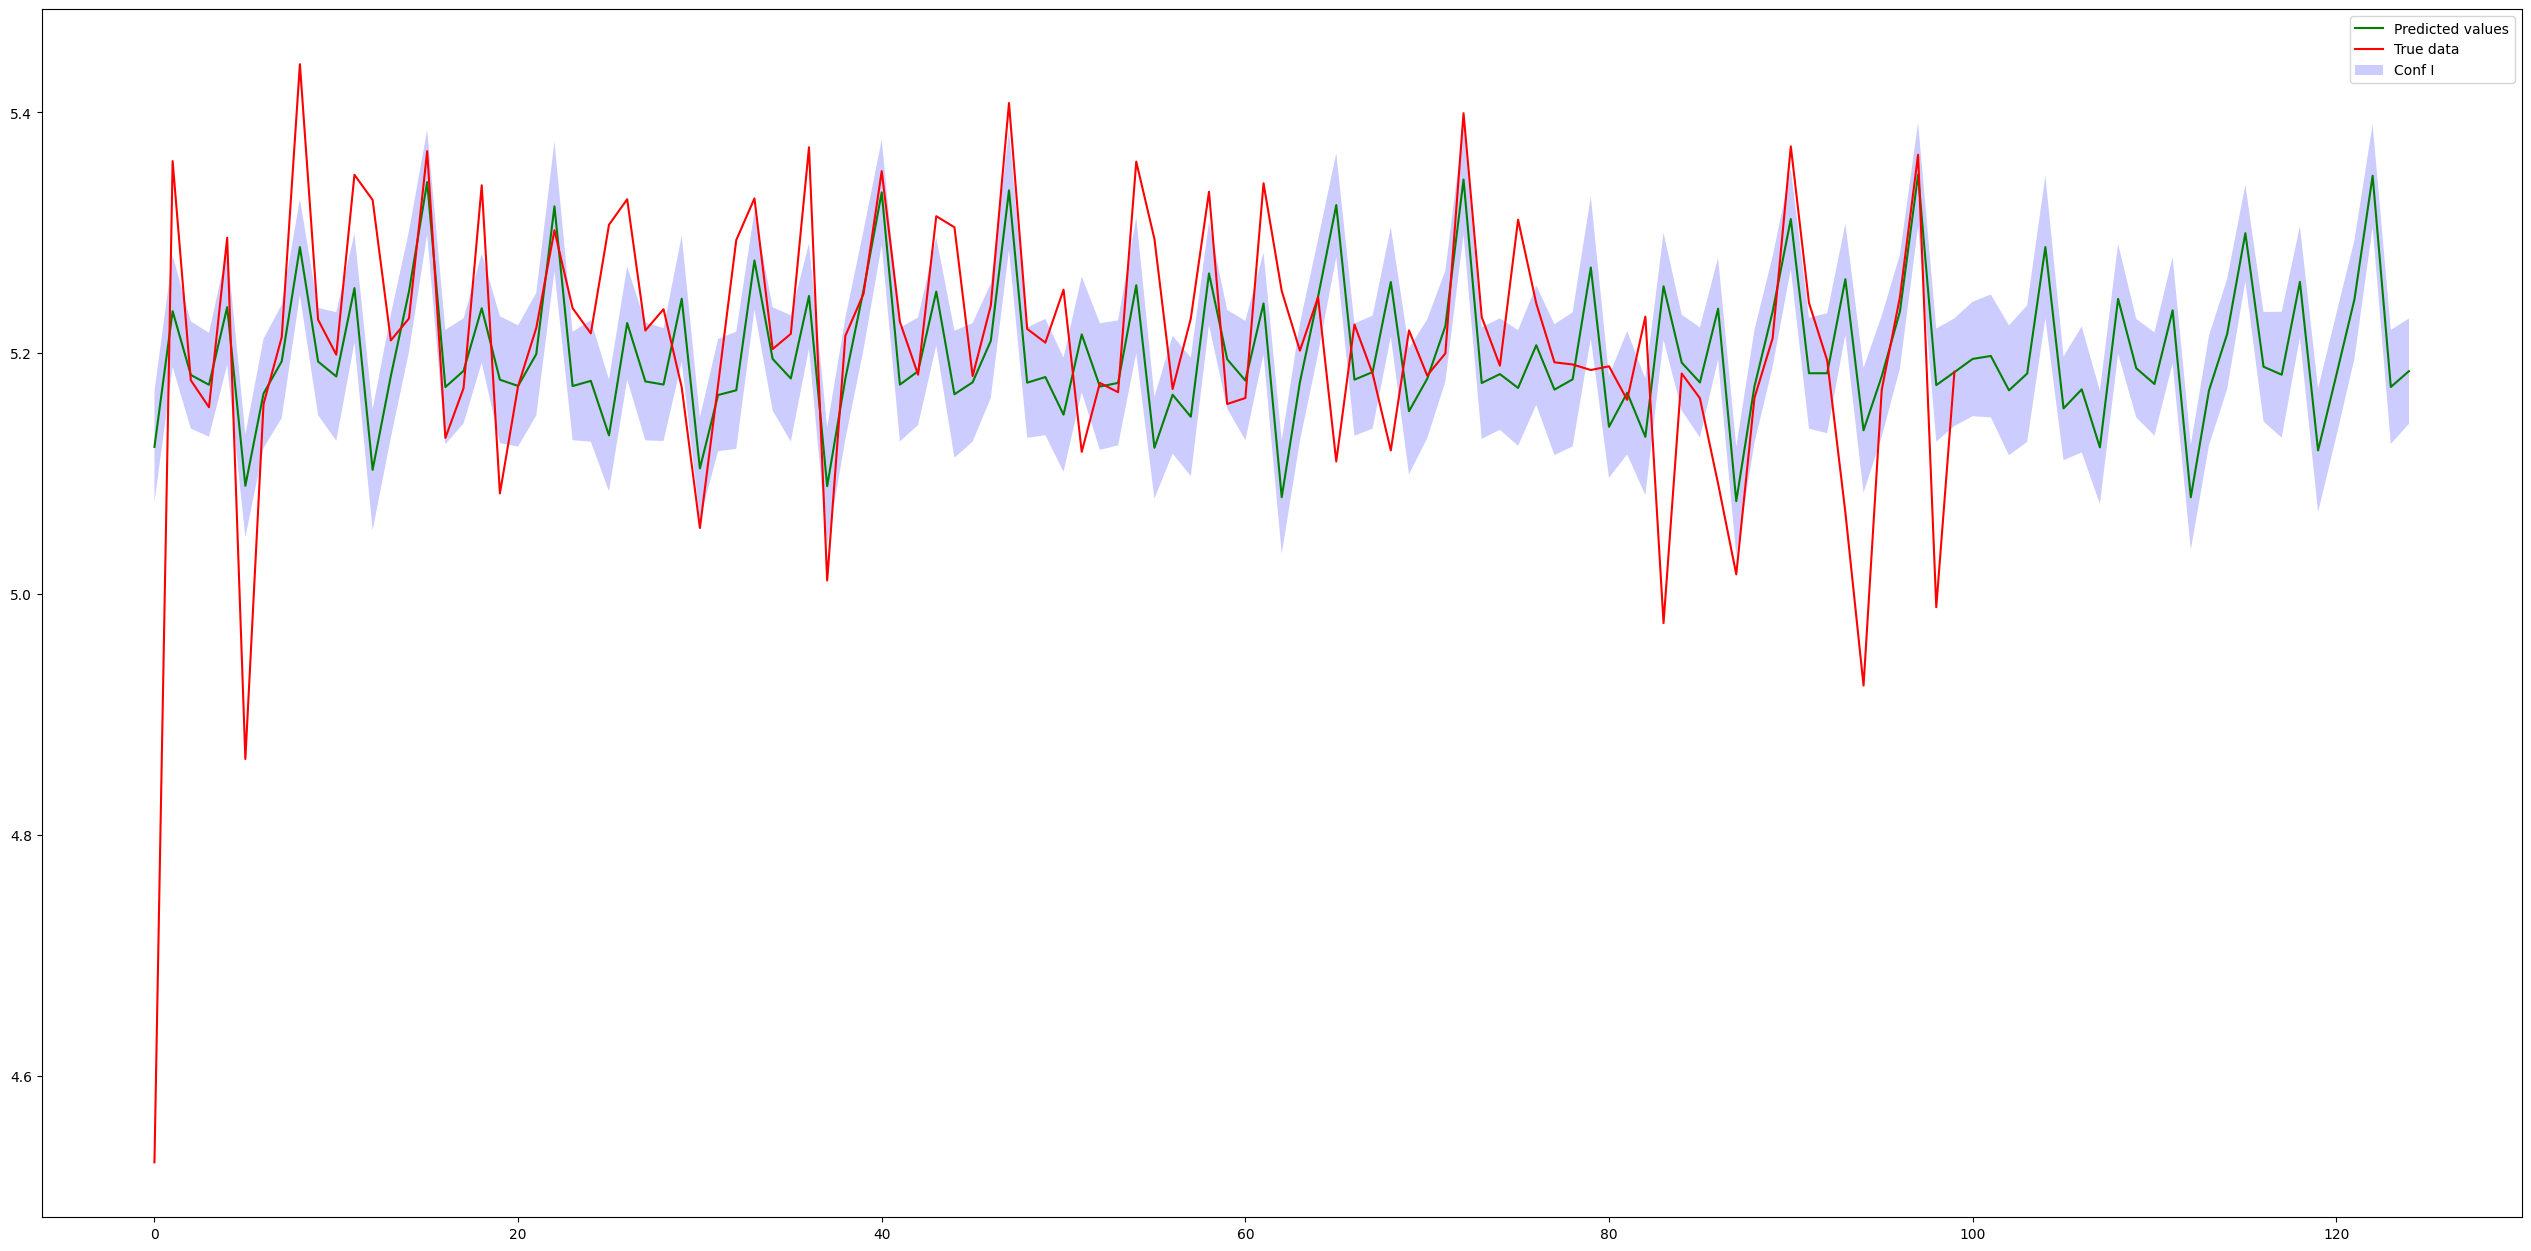

In [645]:
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=best_res["parameters"][0],sigma=best_res["parameters"][1],l=best_res["parameters"][2])
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

In [646]:
#exemple kernel exponentiel
parameters_dic_exp = {
    "l": [0.0001,0.0005,0.001,0.05,0.0014,0.1,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
}


best_res = {"parameters":0,"score":10e13}
for l in parameters_dic_exp["l"] :
    mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Exponential_kernel",l=l)
    param = [l]
    mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
    score = mse(mean[-test_size:],Y_test)
    if score < np.min(best_res["score"]) : 
        best_res["parameters"]=param 
        best_res["score"]=score
print("Best parameters exp",best_res)

Best parameters exp {'parameters': [0.001], 'score': 0.01280363477881069}


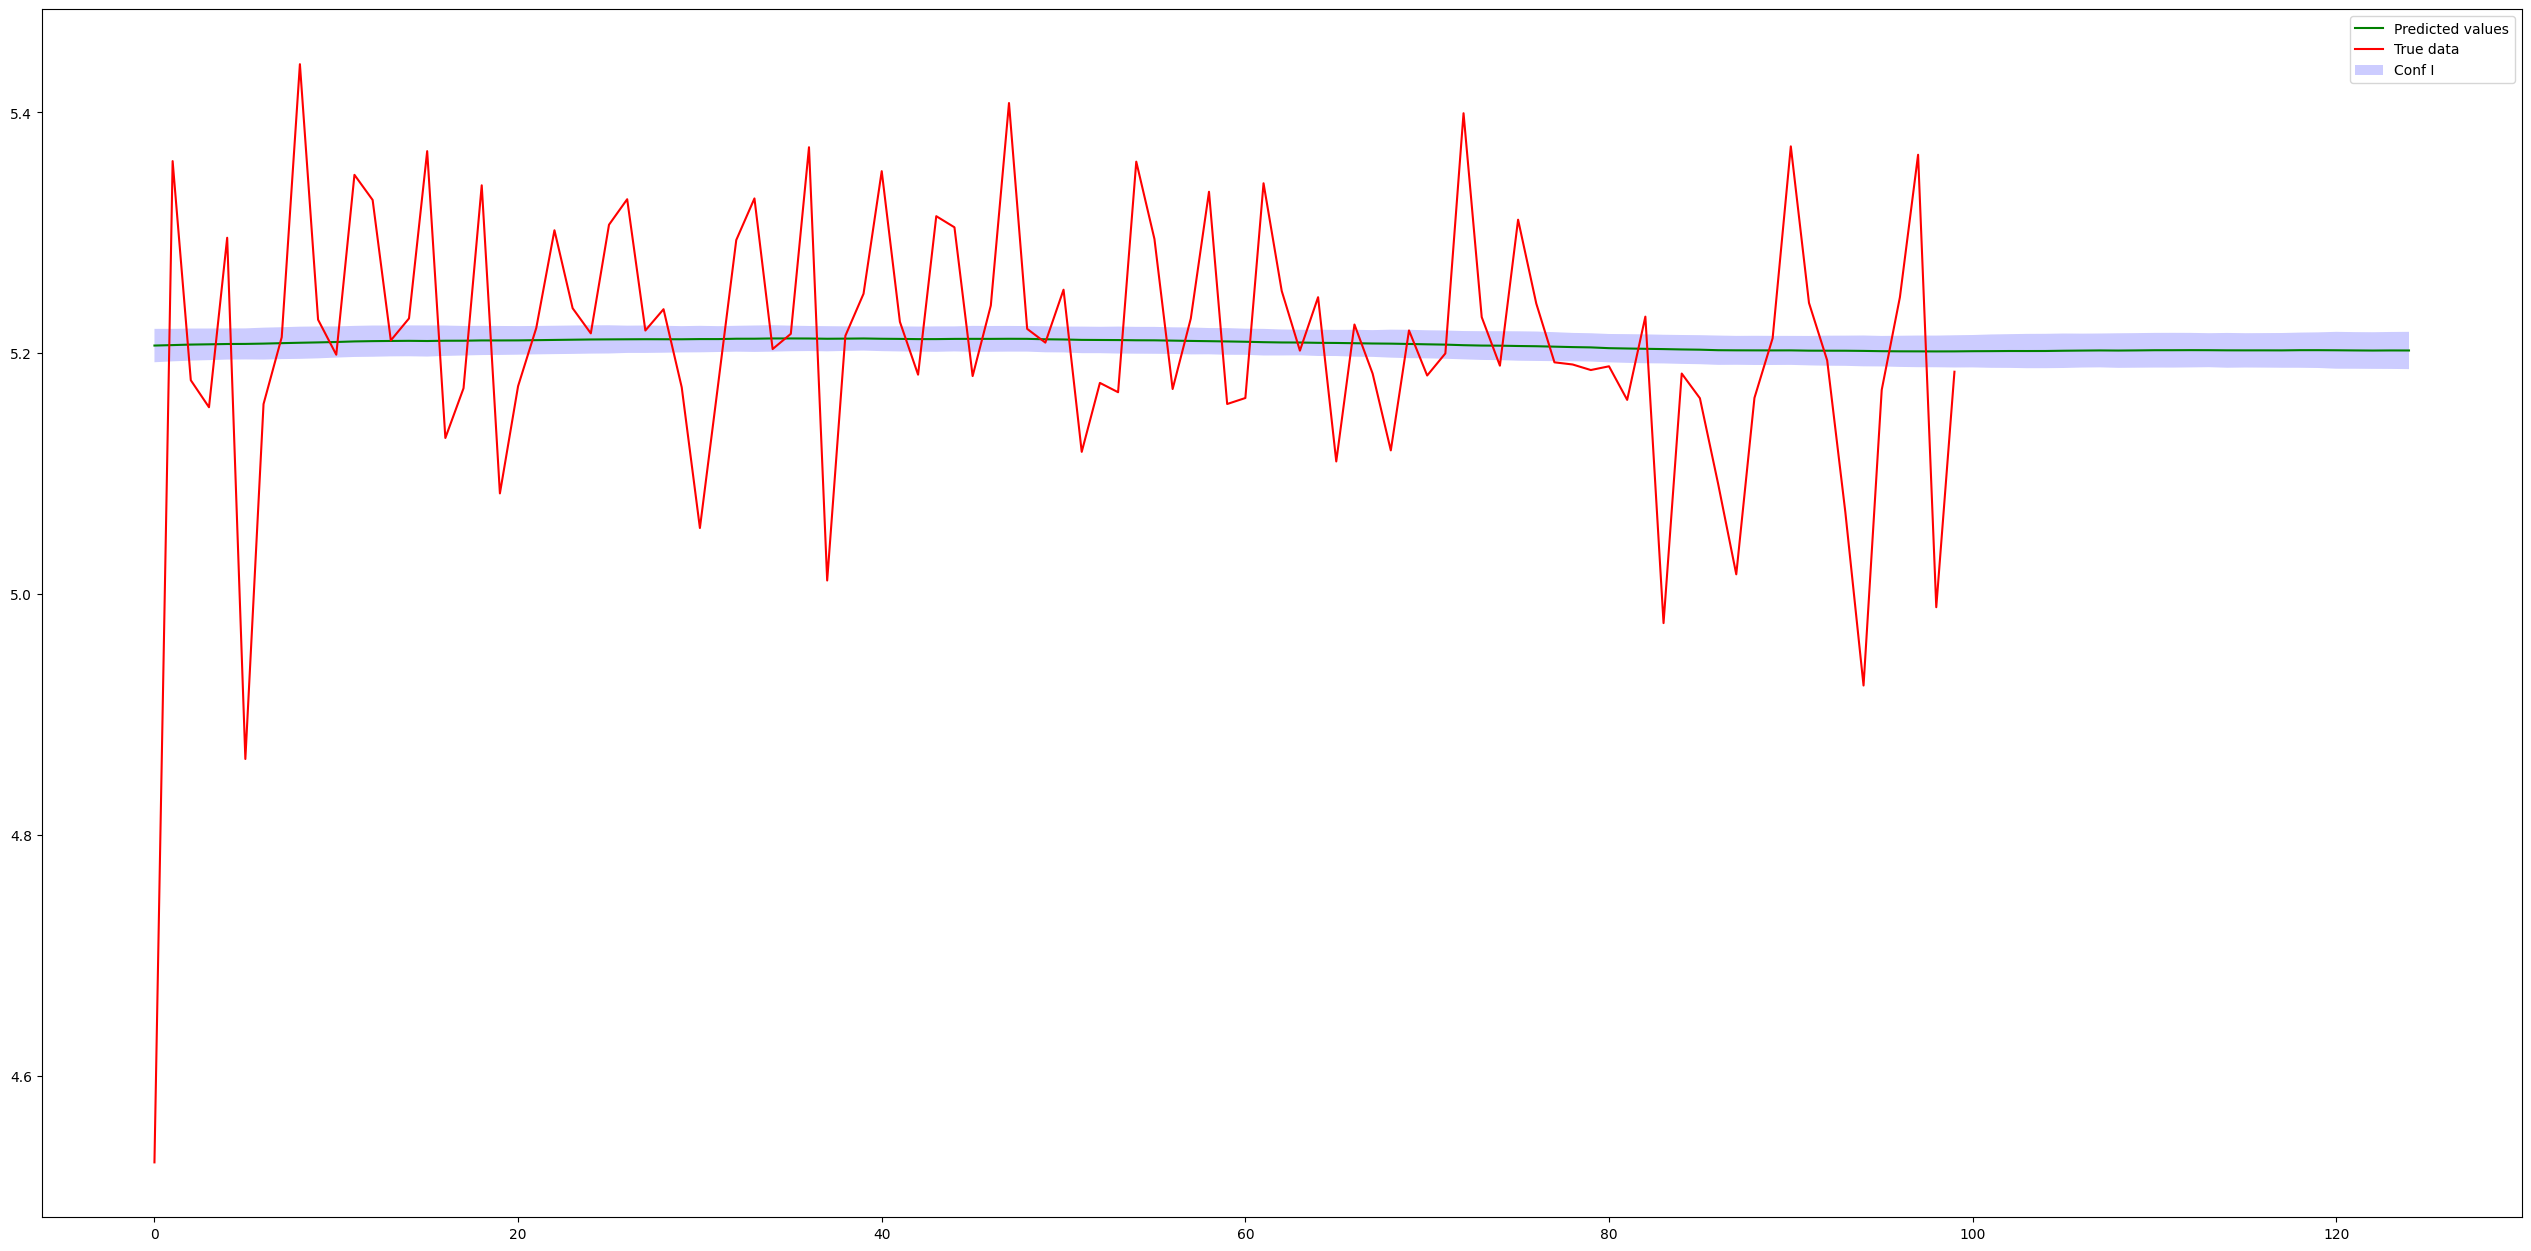

In [647]:
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Exponential_kernel",l=best_res["parameters"][0])
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

 - Par maximisation de la log likelihood

In [688]:
p,sigma,l = optimize(X_train,Y_train,kernel="Periodic",num_restart=10)

Roound n°  0/10 started at point :  0.375547076167817 1.6089833763512518 2.0820701370527495
            score : 14.085584576093126
            ended at point : [0.37378303 1.61512054 2.08863397]
Roound n°  1/10 started at point :  8.086106334612898 4.84926217954758 7.503985524798625
            score : -50.604560632139126
            ended at point : [8.09985225 5.07293487 7.50747769]
Roound n°  2/10 started at point :  4.130856899638463 9.518166270916685 8.693676422103552
            score : -43.604160103808155
            ended at point : [4.23420095 9.7540437  8.47617021]
Roound n°  3/10 started at point :  9.278690367630059 2.745411963338519 0.00754698615072491
            score : -54.24945006374374
            ended at point : [9.51063362e+00 2.76829062e+00 7.60987183e-03]
Roound n°  4/10 started at point :  3.3690089551784332 1.4553291943436353 1.6388628083796963
            score : -44.7468030298716
            ended at point : [3.39751099 1.4911226  1.63937056]
Roound n°  5/10 

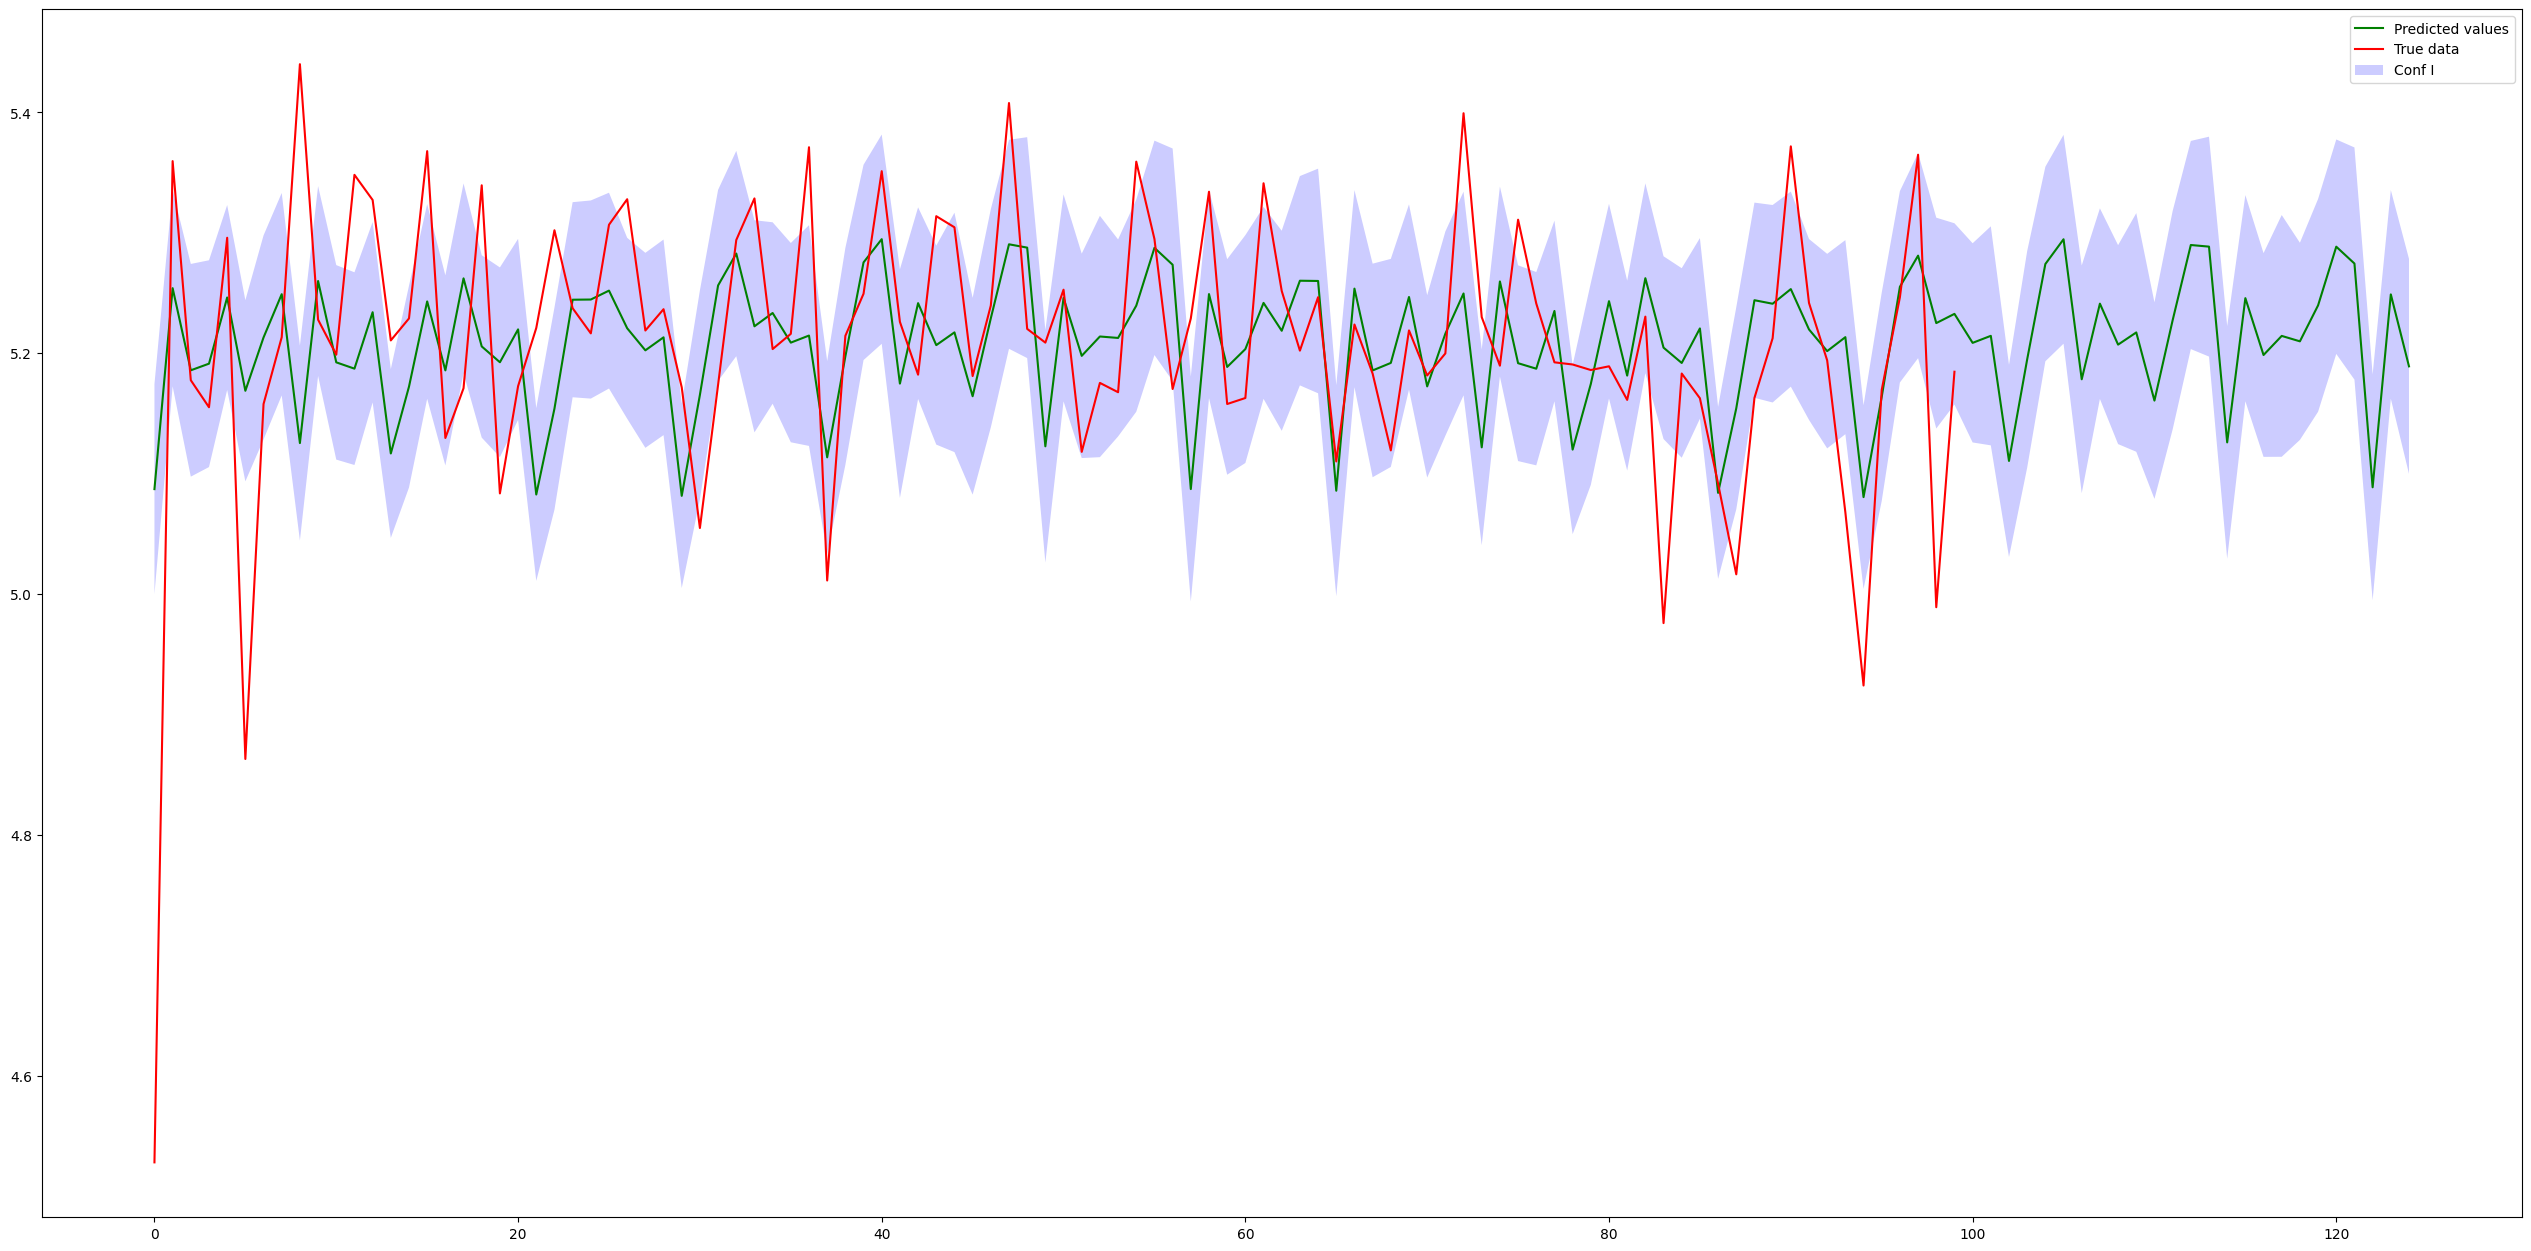

In [689]:
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=p,sigma=sigma,l=l)
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

Roound n°  0/10 started at point :  9.96121525602873


 /usr/lib64/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning:Method Nelder-Mead cannot handle constraints nor bounds.


            score : 217.34161446654335
            ended at point : [10.71049514]
Roound n°  1/10 started at point :  7.58630842267737
            score : 217.3399156166056
            ended at point : [8.06046427]
Roound n°  2/10 started at point :  8.096173037760822
            score : 217.33890185381892
            ended at point : [8.90579034]
Roound n°  3/10 started at point :  9.057891614414785
            score : 217.35111029242208
            ended at point : [9.05789161]
Roound n°  4/10 started at point :  5.9574503937207925
            score : 217.34622746704488
            ended at point : [6.13889374]
Roound n°  5/10 started at point :  4.62441797304821
            score : 217.32160671988126
            ended at point : [4.50114438]
Roound n°  6/10 started at point :  5.094636125377785
            score : 217.34457086615194
            ended at point : [5.09264604]
Roound n°  7/10 started at point :  1.8744019281526036
            score : -57.58717634799346
            ende

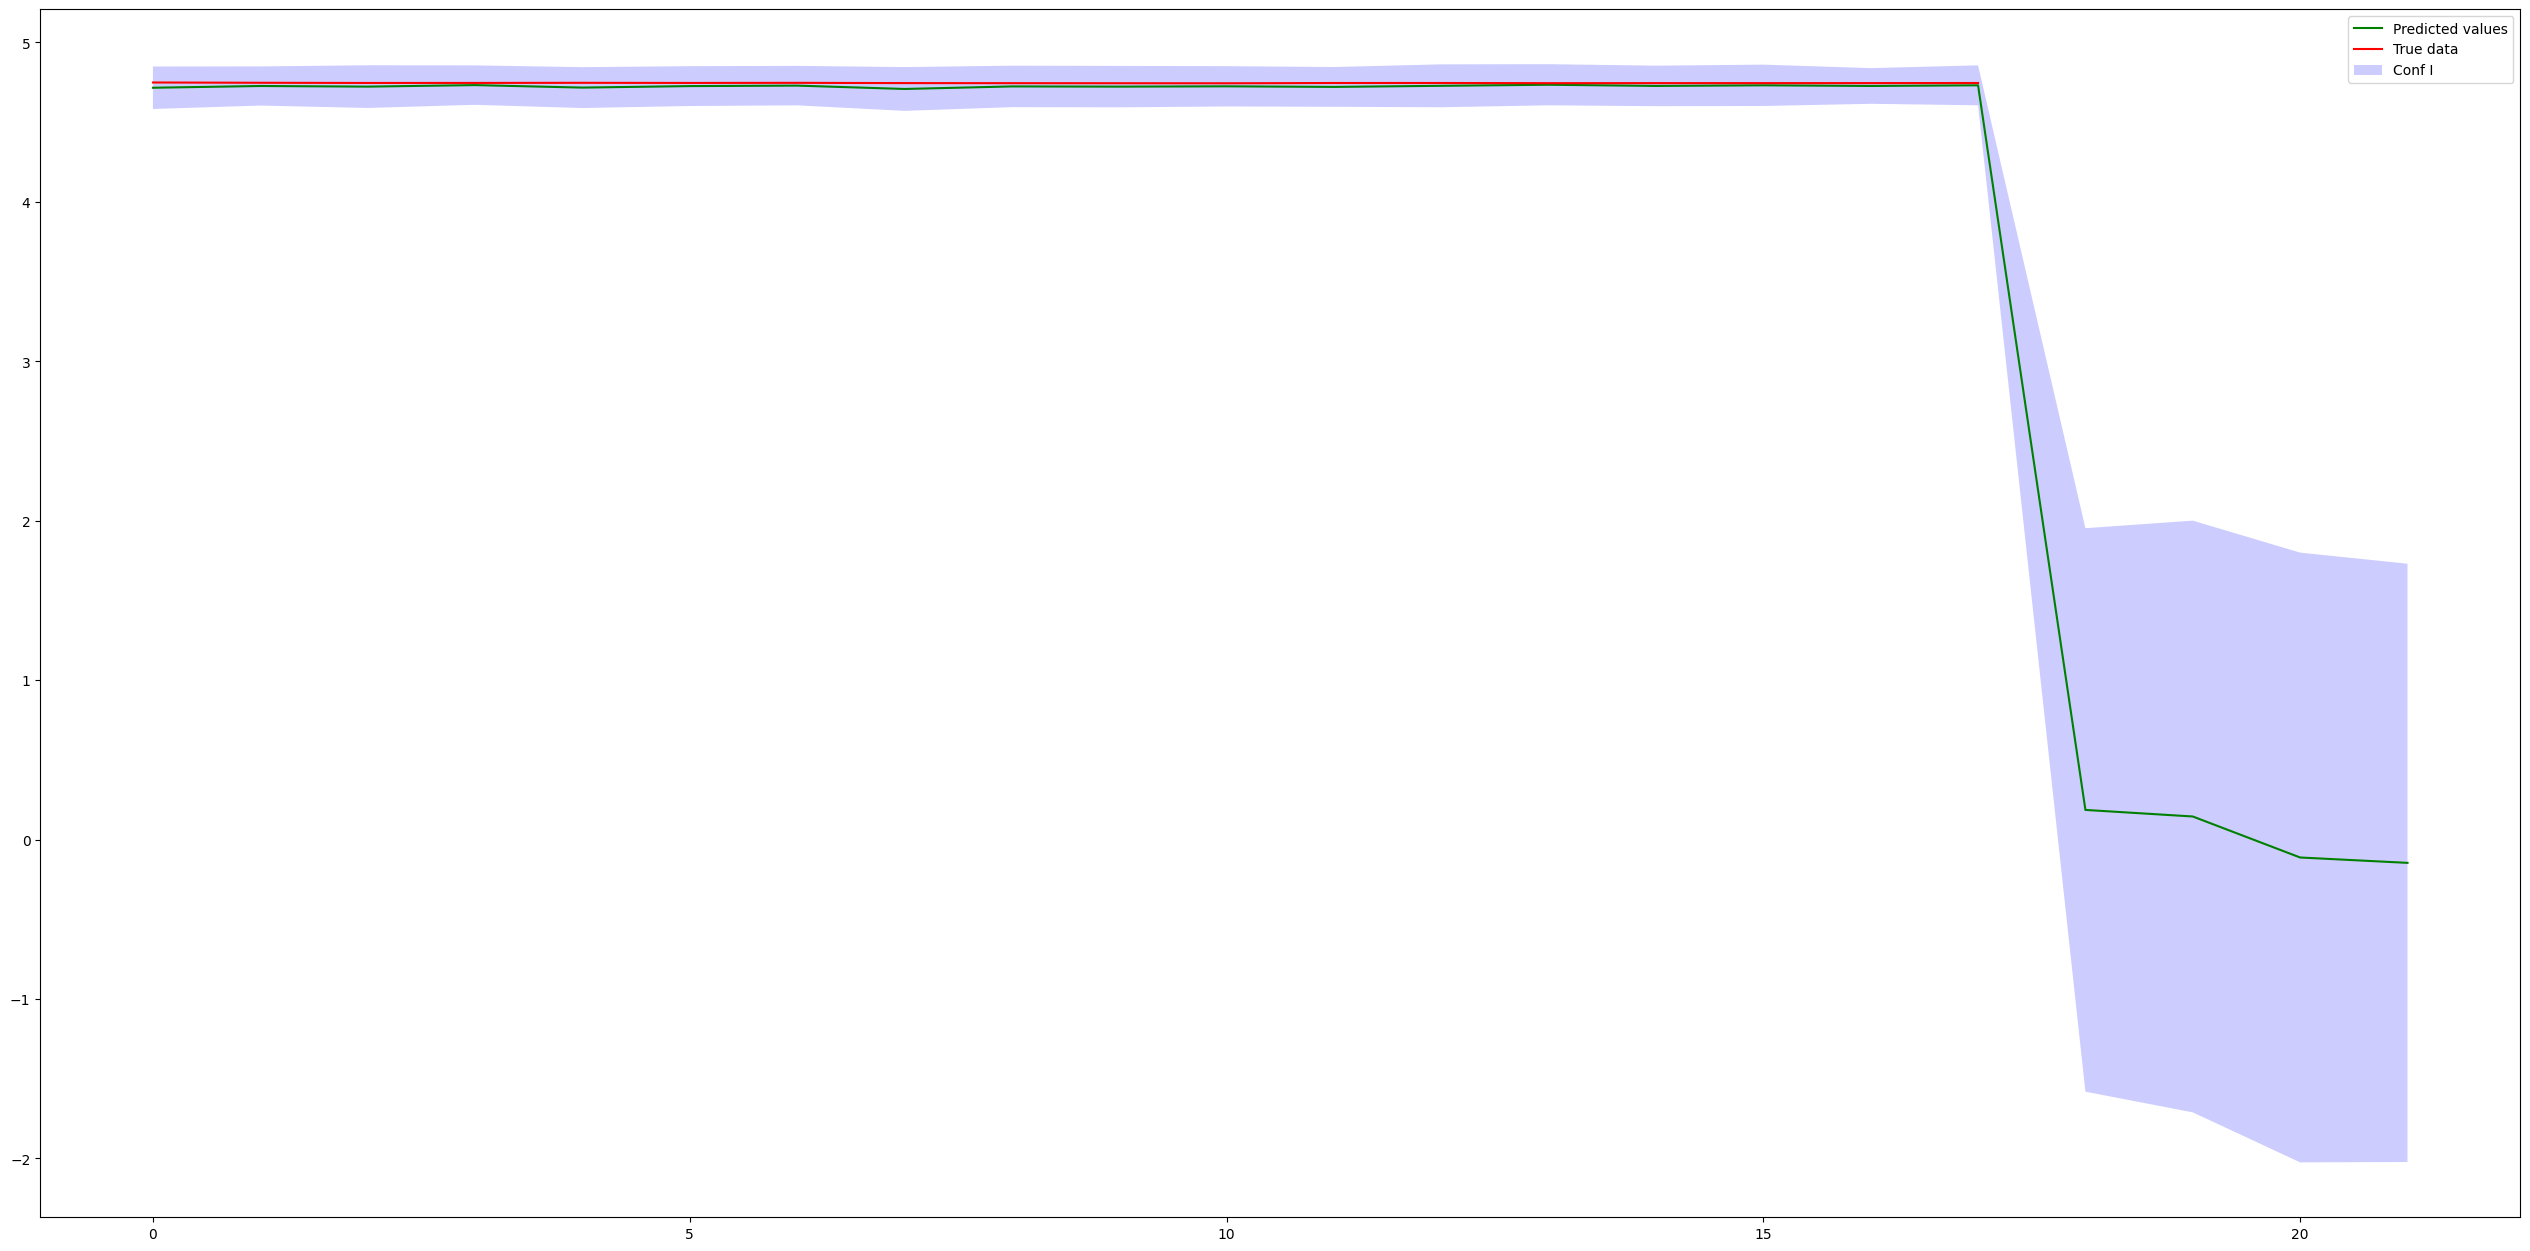

In [702]:
Y_train = Y_train_arr[1][15 :]
Y_train,X_train,X_s,Y_test = prepare_data(Y_train,split=True,test_percent=0.2)
test_size = len(Y_test)
l = optimize_one(X_train,Y_train,kernel="ExpQuad",num_restart=10,bounds=10,method="Nelder-Mead",disp=False)
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="ExpQuad",l=l)
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

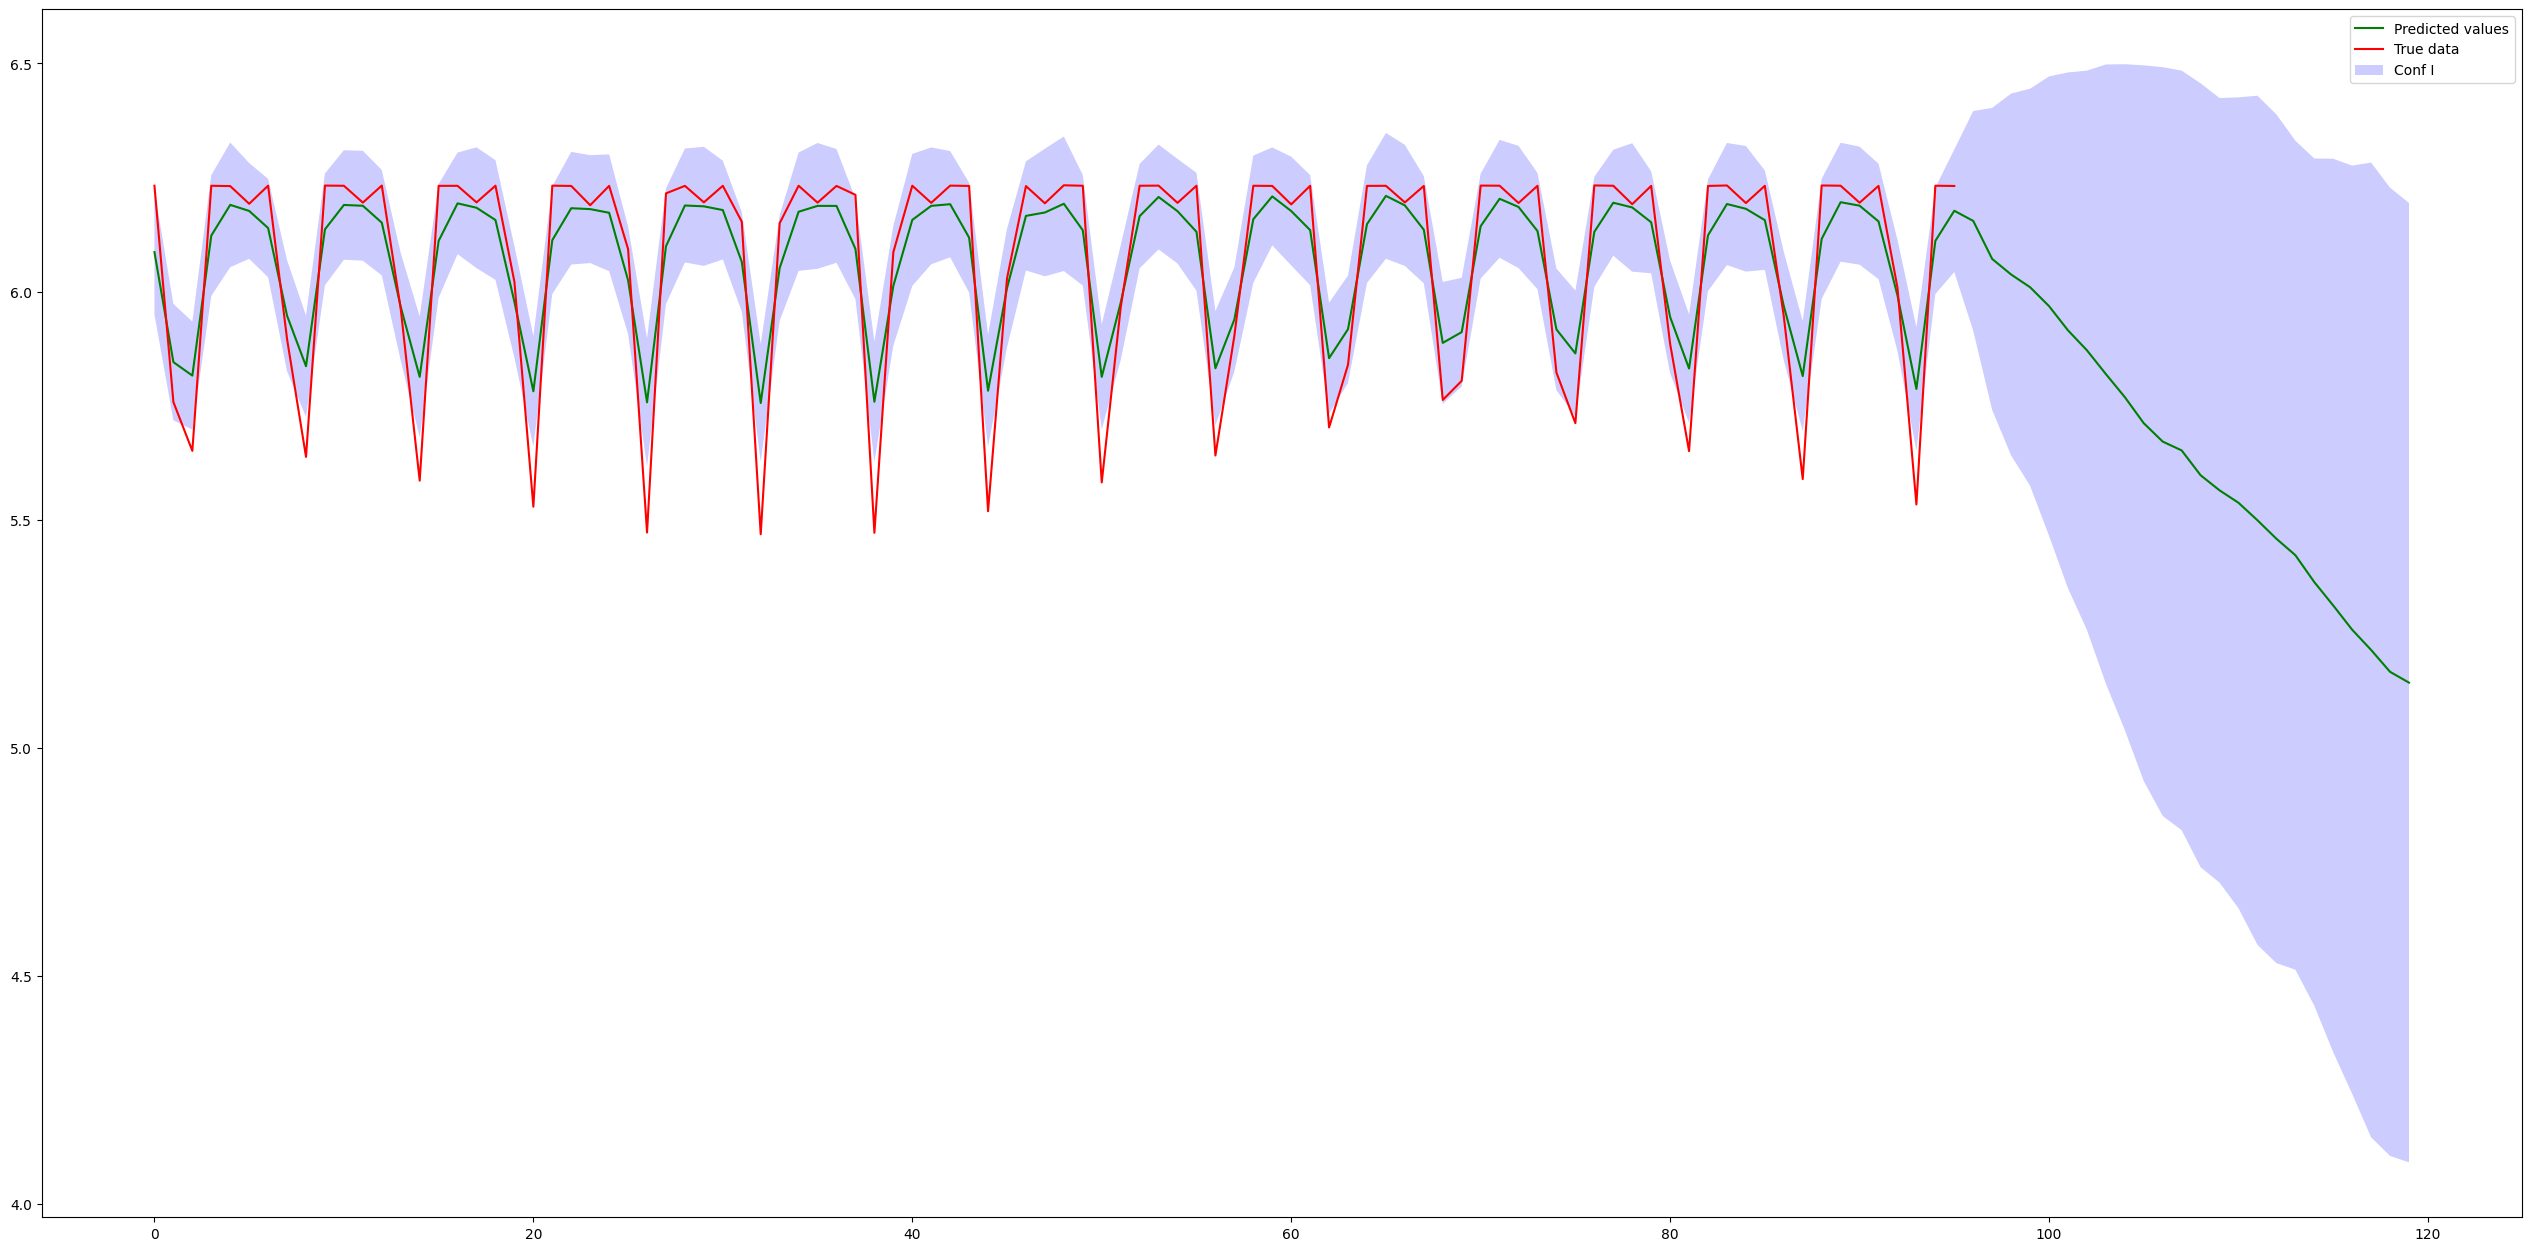

In [302]:

l = 0.12
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Exponential_kernel",l=l)
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)

# Idem en utilisant la librairie GPy


In [542]:
import GPy
Y_train = np.array(pd.read_csv("105.csv")["x"][:125]).reshape(-1,1)
X_train = np.linspace(0,len(Y_train)-1,len(Y_train)).reshape(-1,1)

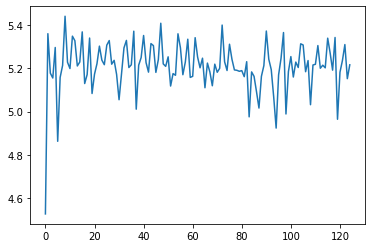

In [543]:
plt.plot(Y_train)

In [544]:
np.array(X_train).reshape(-1,1)
np.array(Y_train).reshape(-1,1)
kerns = [GPy.kern.RBF(1) ,GPy.kern.Exponential(1), GPy.kern.Matern32(1),GPy.kern.StdPeriodic(1,1), GPy.kern.Matern52(1), GPy.kern.Brownian(1), GPy.kern.Bias(1), GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1)]

In [545]:
best_models = {"ll":0,"params":0,"model":0}
for kernel in kerns :
    print(kernel)
    m = GPy.models.GPRegression(X_train,Y_train,kernel)
    m.optimize_restarts(num_restarts = 50)
    if  m.log_likelihood() > best_models["ll"] :
        best_models["ll"] = m.log_likelihood()
        best_models["params"] = m.param_array
        best_models["kernel"] = kernel
        best_models["model"] = m
print(best_models)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        
Optimization restart 1/50, f = -81.33442410894301
Optimization restart 2/50, f = -81.33442452533815
Optimization restart 3/50, f = -81.33442452527454
Optimization restart 4/50, f = -81.33442452535431
Optimization restart 5/50, f = -81.33442452535219
Optimization restart 6/50, f = -81.33442452359505
Optimization restart 7/50, f = -81.3344245253331
Optimization restart 8/50, f = -81.33442452534942
Optimization restart 9/50, f = -81.33442452533353
Optimization restart 10/50, f = -81.33442452540352
Optimization restart 11/50, f = -81.33442452533853
Optimization restart 12/50, f = -81.33442452536545
Optimization restart 13/50, f = -81.33442452525361
Optimization restart 14/50, f = -81.33442452519299
Optimization restart 15/50, f = -81.33442452526948
Optimization restart 16/50, f = -81.3344245206633
Optimization restart 17/50, f = -81.334424

Optimization restart 2/50, f = -85.63155734856267
Optimization restart 3/50, f = -84.65963918735476
Optimization restart 4/50, f = -85.96358763735608
Optimization restart 5/50, f = -86.7147796636664
Optimization restart 6/50, f = -88.67054954714179
Optimization restart 7/50, f = -88.67054970520972
Optimization restart 8/50, f = -83.90930691990768
Optimization restart 9/50, f = -84.74859883461048
Optimization restart 10/50, f = -88.67054970396008
Optimization restart 11/50, f = -84.04516792537535
Optimization restart 12/50, f = -88.64492121853563
Optimization restart 13/50, f = -85.2555847833351
Optimization restart 14/50, f = -85.39123478059705
Optimization restart 15/50, f = -87.50019601234273
Optimization restart 16/50, f = -41.87114720654808
Optimization restart 17/50, f = -86.1054099689951
Optimization restart 18/50, f = -85.73752442362701
Optimization restart 19/50, f = -86.03852253521572
Optimization restart 20/50, f = -86.03906248218482
Optimization restart 21/50, f = -86.485866

Optimization restart 6/50, f = -85.96358764453211
Optimization restart 7/50, f = -85.96358765084418
Optimization restart 8/50, f = -85.96358765092438
Optimization restart 9/50, f = -85.96358765094371
Optimization restart 10/50, f = -85.96358762367299
Optimization restart 11/50, f = -85.96358765093143
Optimization restart 12/50, f = -85.96358765094506
Optimization restart 13/50, f = -85.96358765069806
Optimization restart 14/50, f = -85.96358765012828
Optimization restart 15/50, f = -85.96358763806938
Optimization restart 16/50, f = -85.9635876508043
Optimization restart 17/50, f = -85.96358760600228
Optimization restart 18/50, f = -85.96358765093873
Optimization restart 19/50, f = -85.9635876415242
Optimization restart 20/50, f = -85.96358765008361
Optimization restart 21/50, f = -85.96358765093547
Optimization restart 22/50, f = -85.9635876174791
Optimization restart 23/50, f = -85.9635876502341
Optimization restart 24/50, f = -85.96358765092346
Optimization restart 25/50, f = -85.963

Optimization restart 17/50, f = 383.71848043887303
Optimization restart 18/50, f = 383.7184804388736
Optimization restart 19/50, f = 383.7184804388767
Optimization restart 20/50, f = 383.71848043887286
Optimization restart 21/50, f = 383.7184804388728
Optimization restart 22/50, f = 383.7184804389659
Optimization restart 23/50, f = 383.71848043889344
Optimization restart 24/50, f = 383.7184804388729
Optimization restart 25/50, f = 383.7184804389045
Optimization restart 26/50, f = 383.7184804388728
Optimization restart 27/50, f = 383.7184804394611
Optimization restart 28/50, f = 383.71848043890736
Optimization restart 29/50, f = 383.7184804388749
Optimization restart 30/50, f = 383.7184804388729
Optimization restart 31/50, f = 383.71848043887513
Optimization restart 32/50, f = 383.71848043889827
Optimization restart 33/50, f = 383.718480438873
Optimization restart 34/50, f = 383.7184804388729
Optimization restart 35/50, f = 383.71848043887303
Optimization restart 36/50, f = 383.71848043

Optimization restart 1/50, f = -85.96358765092049
Optimization restart 2/50, f = -87.39058594617431
Optimization restart 3/50, f = -86.64395113138738
Optimization restart 4/50, f = -88.72321772753885
Optimization restart 5/50, f = -76.28616494951824
Optimization restart 6/50, f = -86.13413520063736
Optimization restart 7/50, f = -85.20150421687009
Optimization restart 8/50, f = -88.67052477414052
Optimization restart 9/50, f = -85.35862379873325
Optimization restart 10/50, f = -86.2255337716436
Optimization restart 11/50, f = -85.22301201826801
Optimization restart 12/50, f = -85.62160024063529
Optimization restart 13/50, f = -84.71706005947024
Optimization restart 14/50, f = 28.508466413478196
Optimization restart 15/50, f = -86.31294656291222
Optimization restart 16/50, f = -85.97248586195099
Optimization restart 17/50, f = -86.83699534679533
Optimization restart 18/50, f = -85.85421685204584
Optimization restart 19/50, f = -86.2082659386287
Optimization restart 20/50, f = -84.580012

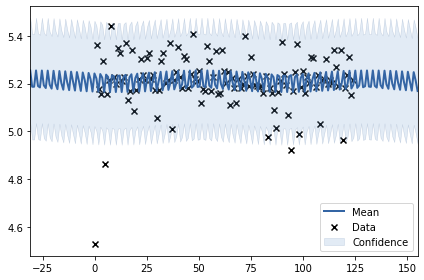

In [546]:
kernel = GPy.kern.StdPeriodic(1,1)
m = GPy.models.GPRegression(X_train,Y_train,kernel)
m.optimize_restarts(num_restarts = 50)
fig = m.plot()

In [547]:
print(type(m))

<class 'GPy.models.gp_regression.GPRegression'>


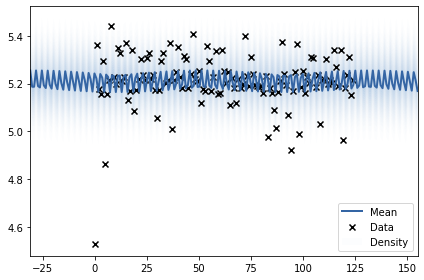

In [548]:
fig = m.plot(plot_density=True)

In [549]:
print(m.log_likelihood())

88.72321772753885


In [551]:
Y_train = np.array(pd.read_csv("105.csv")["x"][126:]).reshape(-1,1)
X_train = np.linspace(0,len(Y_train)-1,len(Y_train)).reshape(-1,1)
best_models = {"ll":0,"params":0,"model":0}
for kernel in kerns :
    print(kernel)
    m = GPy.models.GPRegression(X_train,Y_train,kernel)
    m.optimize_restarts(num_restarts = 50)
    if  m.log_likelihood() > best_models["ll"] :
        best_models["ll"] = m.log_likelihood()
        best_models["params"] = m.param_array
        best_models["kernel"] = kernel
        best_models["model"] = m
print(best_models)

  rbf.         |               value  |  constraints  |  priors
  variance     |  18.306406032996303  |      +ve      |        
  lengthscale  |  155.09196300240507  |      +ve      |        
Optimization restart 1/50, f = -55.17865360224234
Optimization restart 2/50, f = -55.17865360175312
Optimization restart 3/50, f = -55.178653602001006
Optimization restart 4/50, f = -55.17865344973556
Optimization restart 5/50, f = -55.17865360227556
Optimization restart 6/50, f = -55.17865360072746
Optimization restart 7/50, f = -55.178653602237986
Optimization restart 8/50, f = -55.178653602116604
Optimization restart 9/50, f = -55.17865355874061
Optimization restart 10/50, f = -55.178653602027964
Optimization restart 11/50, f = -55.17865360188877
Optimization restart 12/50, f = 58.32206733864786
Optimization restart 13/50, f = -55.17865359598295
Optimization restart 14/50, f = -55.17865360233512
Optimization restart 15/50, f = -55.178653602272085
Optimization restart 16/50, f = -55.178653602266

Optimization restart 1/50, f = -18.31197947230035
Optimization restart 2/50, f = -57.19273827576903
Optimization restart 3/50, f = -20.584918758165117
Optimization restart 4/50, f = -54.59215615766253
Optimization restart 5/50, f = -57.19273827141849
Optimization restart 6/50, f = -39.63110354907356
Optimization restart 7/50, f = -18.31197152998871
Optimization restart 8/50, f = -18.31198811060664
Optimization restart 9/50, f = -29.572787963138847
Optimization restart 10/50, f = -17.796689751899887
Optimization restart 11/50, f = -57.1927382735516
Optimization restart 12/50, f = -17.94725692110827
Optimization restart 13/50, f = -18.31190290196881
Optimization restart 14/50, f = -22.78771517026274
Optimization restart 15/50, f = -57.192738226961126
Optimization restart 16/50, f = -22.593475784077267
Optimization restart 17/50, f = -17.30169417150943
Optimization restart 18/50, f = -16.65270484659466
Optimization restart 19/50, f = -57.192738275941636
Optimization restart 20/50, f = -57

Optimization restart 10/50, f = -18.311988584604535
Optimization restart 11/50, f = -18.31198858454532
Optimization restart 12/50, f = -18.311988584229212
Optimization restart 13/50, f = -18.311988584638836
Optimization restart 14/50, f = -18.311988584625052
Optimization restart 15/50, f = -18.311988584564194
Optimization restart 16/50, f = -18.31198858460494
Optimization restart 17/50, f = -18.31198858460818
Optimization restart 18/50, f = -18.311988584591596
Optimization restart 19/50, f = -18.311988583956147
Optimization restart 20/50, f = -18.311988584412905
Optimization restart 21/50, f = -18.31198858461102
Optimization restart 22/50, f = -18.311988584600936
Optimization restart 23/50, f = -18.3119885841908
Optimization restart 24/50, f = -18.311988584432637
Optimization restart 25/50, f = -18.311988584475273
Optimization restart 26/50, f = -18.31198858461702
Optimization restart 27/50, f = -18.31198857725162
Optimization restart 28/50, f = -18.311988584142195
Optimization restart

Optimization restart 10/50, f = 155.46040898497822
Optimization restart 11/50, f = 155.46040898539192
Optimization restart 12/50, f = 155.4604089849766
Optimization restart 13/50, f = 155.46040898497768
Optimization restart 14/50, f = 155.46040898497697
Optimization restart 15/50, f = 155.4604089849766
Optimization restart 16/50, f = 155.46040898497654
Optimization restart 17/50, f = 155.46040898502653
Optimization restart 18/50, f = 155.46040898504097
Optimization restart 19/50, f = 155.46040898519615
Optimization restart 20/50, f = 155.46040898531422
Optimization restart 21/50, f = 155.46040898551894
Optimization restart 22/50, f = 155.46040898563098
Optimization restart 23/50, f = 155.4604089850292
Optimization restart 24/50, f = 155.4604089849766
Optimization restart 25/50, f = 155.46040898555606
Optimization restart 26/50, f = 155.4604089849766
Optimization restart 27/50, f = 155.4604089850148
Optimization restart 28/50, f = 155.46040898599384
Optimization restart 29/50, f = 155.4

Optimization restart 1/50, f = -63.60960031594346
Optimization restart 2/50, f = -63.60959997029496
Optimization restart 3/50, f = -63.60960031322524
Optimization restart 4/50, f = -63.609600319819386
Optimization restart 5/50, f = -61.31938542178041
Optimization restart 6/50, f = -60.64360102827145
Optimization restart 7/50, f = -63.609600312371995
Optimization restart 8/50, f = -63.60960031934495
Optimization restart 9/50, f = -63.60960030396269
Optimization restart 10/50, f = -63.60960031979212
Optimization restart 11/50, f = -63.60960031188504
Optimization restart 12/50, f = -63.609599961246744
Optimization restart 13/50, f = -63.60960028385481
Optimization restart 14/50, f = -63.60959224222639
Optimization restart 15/50, f = -63.60960031435338
Optimization restart 16/50, f = -63.60960031650833
Optimization restart 17/50, f = -63.6096003041646
Optimization restart 18/50, f = -58.774139479571616
Optimization restart 19/50, f = -63.60960031796908
Optimization restart 20/50, f = 155.4

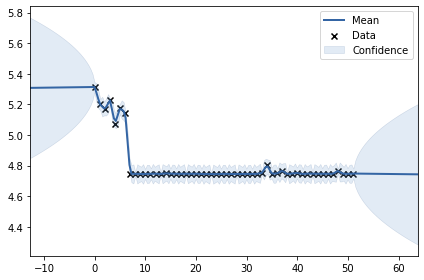

In [552]:
kernel = GPy.kern.Exponential(1)
m = GPy.models.GPRegression(X_train,Y_train,kernel)
m.optimize_restarts(num_restarts = 50)
fig = m.plot()

(983,)


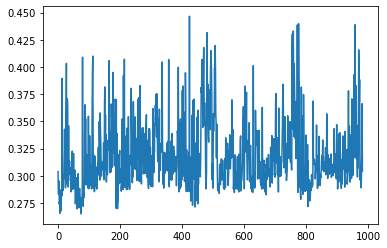

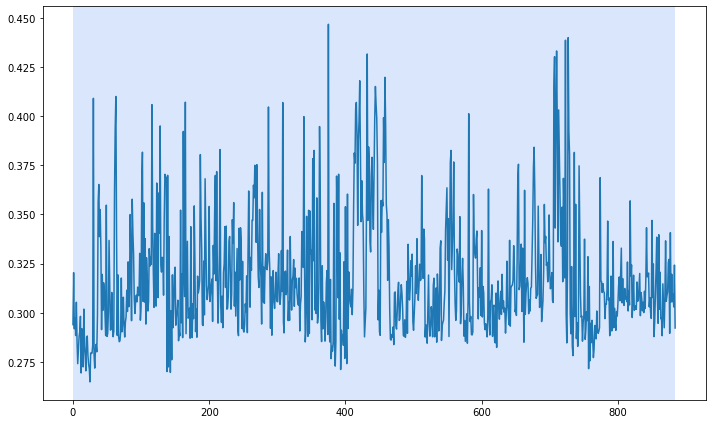

res {'best': [0, 983]}
Roound n°  0/10 started at point :  9.7804985188639 4.8050863667045 1.7430664236062132


 /usr/lib64/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning:Method Nelder-Mead cannot handle constraints nor bounds.


            score : -1561.5899089314548
            ended at point : [10.12007987  4.96659055  1.65513446]
Roound n°  1/10 started at point :  9.761185369202924 0.21831438661053082 4.1991107517310535


KeyboardInterrupt: 

In [707]:
Y_train = pd.read_csv("432.csv")["x"]
print(Y_train.shape)
%matplotlib inline
plt.plot(Y_train)
dic = changepoint_detection(Y_train)            
print("res",dic)
Y_train_arr = [Y_train[dic["best"][i]:dic["best"][i+1]] for i in range(len(dic["best"])-1)]
Y_train = Y_train_arr[0]
Y_train,X_train,X_s,Y_test = prepare_data(Y_train,split=True,test_percent=0.2)
test_size = len(Y_test)
p,sigma,l = optimize(X_train,Y_train,kernel="Periodic",num_restart=10)
mu_s, cov_s = compute_posterior(X_train,Y_train,X_s,kernel="Periodic",p=p,sigma=sigma,l=l)
mean,stdp,stdi=get_values(mu_s,cov_s,nb_samples=10000)
plot_gs(Y_train,mean,X_train,X_s,stdp,stdi)